In [1]:
import sys, os, argparse, shutil, inspect

import numpy as np
import tensorflow as tf
from tensorflow import keras

import tf_datasets, tf_network

import logging, pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
sys.argv = ['scenes/tf_train.py', '--mve', '-o', '/tmp/tfmodel/', '/tmp/tdata/']

In [3]:
parser = argparse.ArgumentParser(description='Generate Training Data', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('-o', '--output', default='/tmp/tfmodel/',   help='output directory')
parser.add_argument('-l', '--load',   action="store_true",       help='load and resume the training')
parser.add_argument(      '--lstep',  default=100,   type=int,   help='log summary; e.g., every 10th steps')
parser.add_argument('-s', '--steps',  default=10000, type=int,   help='maximum training steps')
parser.add_argument('-b', '--batch',  default=5000,  type=int,   help='batch size for one step training')
parser.add_argument('-t', '--ftest',  default=0.25,  type=float, help='fraction for the test data set')
parser.add_argument('-d', '--dnet',   default='27-34-2',         help='detection networks int-int-...')
parser.add_argument('-m', '--mnet',   default='27-34-2',         help='modification networks int-int-...')
parser.add_argument(      '--dact',   default='none-tanh-tanh',  help='activation function for detection networks')
parser.add_argument(      '--mact',   default='none-tanh-tanh',  help='activation function for modification networks')
parser.add_argument(      '--stats',  action="store_true",       help='write the stats')
parser.add_argument('-v', '--mve',    action="store_true",       help='turn on mean-variance learning')
parser.add_argument(      '--nosmax', action="store_true",       help='do not use the softmax model')
parser.add_argument('-r', '--decay',  default=0.1,   type=float, help='regularization coefficient')
parser.add_argument(      '--ddrop',  default=0.1,   type=float, help='dropout rate (detection)')
parser.add_argument(      '--mdrop',  default=0.1,   type=float, help='dropout rate (modification)')
parser.add_argument('datadirs', action="store", nargs="+",       help='path(s) to the training data')
pargs = parser.parse_args()

In [4]:
pargs.nosmax

False

In [5]:
# pargs.dnet = "27-34-17-2"
# pargs.mnet = "27-34-17-2"
# pargs.dact = "none-tanh-tanh-tanh"
# pargs.mact = "none-tanh-tanh-tanh"

pargs.output = "models/keras_mods/"
pargs.dnet = "27-34-2"
pargs.mnet = "27-34-2"
pargs.dact = "none-tanh-tanh"
pargs.mact = "none-tanh-tanh"

In [6]:
pargs.output = os.path.normpath(pargs.output)
os.path.isdir(pargs.output) or os.makedirs(pargs.output)

shutil.copy(inspect.stack()[-1][1], pargs.output+'/')
with open(pargs.output+'/run_args.pickle', 'wb') as f: 
    pickle.dump(vars(pargs), f)
with open(pargs.output+'/run_cmd.txt', 'w') as f: 
    f.write(' '.join(os.uname()) + '\n' + ' '.join(sys.argv))

data_sets, N_tuple = tf_datasets.read_data_sets(dirs=sorted(pargs.datadirs), use_softmax=(not pargs.nosmax), frac_test=pargs.ftest)
scale = { i: max(abs(data_sets.train.get_data()[i].min()), abs(data_sets.train.get_data()[i].max())) for i in data_sets.train.get_data() }
with open(pargs.output+'/scale.pickle', 'wb') as f: 
    pickle.dump(scale, f)

logging.basicConfig(filename='{}/training-info.log'.format(pargs.output), level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())
logging.info('tensorflow-{} ({}, {})'.format(tf.__version__, tf.sysconfig.get_include(), tf.sysconfig.get_lib()))
logging.info(pargs)
logging.info('{} tuples have been loaded; randomly selected {} for the training set and {} for the test set'.format(
    N_tuple, data_sets.train._num_examples, data_sets.test._num_examples))
logging.info(scale)

tensorflow-2.5.0 (/usr/local/lib/python3.8/dist-packages/tensorflow/include, /usr/local/lib/python3.8/dist-packages/tensorflow)
Namespace(batch=5000, dact='none-tanh-tanh', datadirs=['/tmp/tdata/'], ddrop=0.1, decay=0.1, dnet='27-34-2', ftest=0.25, load=False, lstep=100, mact='none-tanh-tanh', mdrop=0.1, mnet='27-34-2', mve=True, nosmax=False, output='models/keras_mods', stats=False, steps=10000)
8376 tuples have been loaded; randomly selected 6282 for the training set and 2094 for the test set
{'inputs': 3.7656653, 'labels': 1.0, 'modvel': 2.749637}


In [7]:
# statistics
if pargs.stats and (not pargs.load):
    with PdfPages(pargs.output+'/histogram.pdf') as pdf, open(pargs.output+'/dataset_stats.pickle', 'wb') as log:
        l = data_sets.train.get_data()['labels']
        if not pargs.nosmax: l = l[:,0]
        dataset_stats = {}
        for i in sorted(data_sets.train.get_data()):
            d = data_sets.train.get_data()[i][(l==1).reshape(-1)] # only splash particles
            dataset_stats[i] = [None]*d.shape[1]
            for j in range(d.shape[1]):
                d_row = d[:,j].reshape(-1)
                dataset_stats[i][j] = { 'mean': np.mean(d_row), 'std': np.std(d_row), 'min': np.amin(d_row), 'max': np.amax(d_row) }
                plt.figure()
                plt.hist(d_row, bins='auto')
                plt.title('Histogram of {}[{}]'.format(i, j))
                plt.savefig(pdf, format='pdf')
                plt.close()

        pickle.dump(dataset_stats, log)

In [8]:
# tf.set_random_seed(1)
tf.random.set_seed(1)

def parse_act(act):
    if act == 'tanh':    return tf.nn.tanh
    if act == 'sigmoid': return tf.nn.sigmoid
    if act == 'relu':    return tf.nn.relu
    return tf.nn.tanh

In [9]:
# init_weights = { 'w': {'mean': float, 'stddev': float}, 'b': {'value': float} }
def weight_variable(shape, init_weights=None):
    params = dict(shape=shape)
    if init_weights and 'w' in init_weights: params.update(init_weights['w'])
    initial = tf.truncated_normal(**params)
    return tf.Variable(initial)

In [10]:
def bias_variable(shape, init_weights=None):
    params = dict(value=0.1, shape=shape)
    if init_weights and 'b' in init_weights: params.update(init_weights['b'])
    initial = tf.constant(**params)
    return tf.Variable(initial)

In [11]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar(name='mean/' + name, tensor=mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))

        tf.summary.scalar(name='stddev/' + name, tensor=stddev)
        tf.summary.scalar(name='max/' + name, tensor=tf.reduce_max(var))
        tf.summary.scalar(name='min/' + name, tensor=tf.reduce_min(var))
        tf.summary.histogram(name=name, values=var)

In [12]:
# def nn_layer(input_tensor, input_dim, output_dim, layer_name,
#              init_weights=None, drop=None, bn=False, is_training=True, act=tf.nn.tanh):
    
#     x = keras.layers.Dense(input_dim, activation=act)(input_tensor)    
#     if bn:
#         x = layers.BatchNormalization(momentum=0.99, #0.999 
#             epsilon=0.001, # 1e-4
#          )(x)
        
#     x = keras.layers.Dropout(drop)(x)
    
#     return x

In [13]:
# def build_network(layers, layers_act=None, input_x_holder=None, input_y_holder=None, dropout_holder=None,
#                   init_weights=None, bn=False, is_training=True, scope=''):
#     with tf.name_scope('{}input'.format(scope)):
#         x  =  input_x_holder
#         y_ = input_y_holder

#     lp = x

#     for i in range(1, len(layers)-1):
#         lp = nn_layer(input_tensor=lp, input_dim=layers[i-1], output_dim=layers[i], layer_name='{}layer{}'.format(scope, i),
#                       init_weights=init_weights, drop=dropout_holder, bn=bn, is_training=is_training,
#                       act=layers_act[i] if layers_act else tf.nn.tanh)

#     y = nn_layer(input_tensor=lp, input_dim=layers[i], output_dim=layers[i+1], layer_name='{}layer_full'.format(scope),
#                  init_weights=init_weights, drop=dropout_holder, bn=bn, is_training=is_training,
#                  act=layers_act[i+1] if layers_act else tf.nn.tanh)

#     return x, y_, y

In [14]:
# logging.info('Neural network structure: detection {} and modification {}'.format(pargs.dnet, pargs.mnet))
# dlayers    = list(map(int, pargs.dnet.split('-')))
# mlayers    = list(map(int, pargs.mnet.split('-')))
# dact       = list(map(tf_network.parse_act, pargs.dact.split('-')))
# mact       = list(map(tf_network.parse_act, pargs.mact.split('-')))
# init_w     = {'w': {'stddev': 0.1}, 'b': {'value': 0.5}}
# # x          = tf.placeholder(tf.float32, shape=[None, dlayers[0]], name='x-input')
# # keep_prob  = tf.placeholder(tf.float32, name='keep_prob_detector') if pargs.ddrop>0.0 else None
# # keep_prob2 = tf.placeholder(tf.float32, name='keep_prob_modifier') if pargs.mdrop>0.0 else None
# y_,  y     = tf_network.build_network(dlayers, dact, init_weights=init_w, input_x_holder=x, dropout_holder=keep_prob,  bn=True, scope='detector/')[1:]
# y2_, y2    = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, dropout_holder=keep_prob2, bn=True, scope='modifier/')[1:]
# if pargs.mve:
#     s      = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, input_y_holder=y2_, dropout_holder=keep_prob2, bn=True, scope='modifier_var/')[2]

# global_step = tf.Variable(0, trainable=False, name='global_step')

In [15]:
logging.info('Neural network structure: detection {} and modification {}'.format(pargs.dnet, pargs.mnet))
dlayers    = list(map(int, pargs.dnet.split('-')))
mlayers    = list(map(int, pargs.mnet.split('-')))
dact       = list(map(tf_network.parse_act, pargs.dact.split('-')))
mact       = list(map(tf_network.parse_act, pargs.mact.split('-')))
init_w     = {'w': {'stddev': 0.1}, 'b': {'value': 0.5}}

Neural network structure: detection 27-34-2 and modification 27-34-2


In [16]:
x = keras.Input(shape=(dlayers[0],))


def build_network(layers, layers_act=None, input_x_holder=None, input_y_holder=None, dropout_holder=None,
                  init_weights=None, bn=False, is_training=True, scope=''):
    lp = x

    for i in range(1, len(layers)-1):
        lp = nn_layer(input_tensor=lp, input_dim=layers[i-1], output_dim=layers[i], layer_name='{}layer{}'.format(scope, i),
                      init_weights=init_weights, keep_prob=dropout_holder, bn=bn, is_training=is_training,
                      act=layers_act[i] if layers_act else tf.nn.tanh)

    y = nn_layer(input_tensor=lp, input_dim=layers[i], output_dim=layers[i+1], layer_name='{}layer_full'.format(scope),
                 init_weights=init_weights, keep_prob=dropout_holder, bn=bn, is_training=is_training,
                 act=layers_act[i+1] if layers_act else tf.nn.tanh)

    print(layers)

    return x, y_, y


y_,  y     = tf_network.build_network(dlayers, dact, init_weights=init_w, input_x_holder=x, dropout_holder=pargs.ddrop, bn=True, scope='detector/')[1:]
y2_, y2    = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, dropout_holder=pargs.mdrop, bn=True, scope='modifier/')[1:]

if pargs.mve:
    s      = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, input_y_holder=y2_, dropout_holder=pargs.mdrop, bn=True, scope='modifier_var/')[2]


[27, 34, 2]
[27, 34, 2]
[27, 34, 2]


In [17]:
# ################################################################################
# # evaluation functions
# log_dict = {}
# with tf.name_scope('accuracy'):
#     with tf.name_scope('correct_prediction'):
#         if pargs.nosmax: corr, appx = tf.cast(tf.less(y_, 0.5), tf.int64), tf.cast(tf.less(y, 0.5), tf.int64) # f: splashing, t: non-splashing
#         else:            corr, appx = tf.argmax(y_, 1), tf.argmax(y, 1)                                       # 0: splashing, 1: non-splashing

#         correct_prediction = tf.equal(corr, appx)
#         accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#         y_b_appx           = tf.equal(appx, 0) # true: splashing, false: non-splashing
#         y_b_corr           = tf.equal(corr, 0)

#         N_corr_non_splas    = tf.reduce_sum(corr)
#         N_corr_splashing    = tf.cast(tf.shape(y_)[0], tf.int64) - N_corr_non_splas
#         diff_appx_corr      = tf.math.logical_xor(y_b_appx, y_b_corr)
#         N_corr_spl_appx_non = tf.reduce_sum(tf.cast(tf.logical_and(y_b_corr, diff_appx_corr), tf.float32))
#         N_corr_non_appx_spl = tf.reduce_sum(tf.cast(tf.logical_and(y_b_appx, diff_appx_corr), tf.float32))
#         false_negative      = N_corr_spl_appx_non/tf.cast(N_corr_splashing, tf.float32)
#         false_positive      = N_corr_non_appx_spl/tf.cast(N_corr_non_splas, tf.float32)

#         log_dict['accuracy']                     = accuracy
#         log_dict['false_negative_corr_T_appx_F'] = false_negative
#         log_dict['false_positive_corr_F_appx_T'] = false_positive
#         log_dict['splashes/corr']                = 1.0 - tf.reduce_mean(tf.cast(corr, tf.float32))
#         log_dict['splashes/appx']                = 1.0 - tf.reduce_mean(tf.cast(appx, tf.float32))

#     with tf.name_scope('loss'):
#         with tf.GradientTape() as tape:
#             loss_normalizer = 1.0/tf.cast(tf.shape(y2_)[0], tf.float32)

#             with tf.name_scope('detector'):
#                 if pargs.nosmax: loss_detector = tf.nn.l2_loss(y - y_)
#                 else:            loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
#                 log_dict['detector/loss'] = loss_detector*loss_normalizer if pargs.nosmax else loss_detector

#             with tf.name_scope('modifier'):
#                 loss_modifier = tf.nn.l2_loss(y2 - y2_)
#                 log_dict['modifier/loss'] = loss_modifier*loss_normalizer
#                 if pargs.mve:
#                     loss_modifier_mve = 0.5*tf.reduce_sum(((y2 - y2_)**2)/(s**2 + 1e-9)) + 0.5*tf.reduce_sum(tf.math.log(s**2 + 1e-9)) # mean variance estimate
#                     log_dict['modifier_mve/loss'] = loss_modifier_mve*loss_normalizer

#             loss = loss_detector + loss_modifier
#             log_dict['sum_loss'] = log_dict['detector/loss'] + log_dict['modifier/loss']
#             if pargs.mve:
#                 loss_mve = loss_detector + loss_modifier_mve
#                 log_dict['sum_loss_mve'] = log_dict['detector/loss'] + log_dict['modifier_mve/loss']

#             if pargs.decay>0.0:
#                 w_detector     = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "detector/")
#                 w_modifier     = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "modifier/")
#                 decay_detector = tf.add_n([tf.nn.l2_loss(v) for v in w_detector])*pargs.decay
#                 decay_modifier = tf.add_n([tf.nn.l2_loss(v) for v in w_modifier])*pargs.decay

#                 loss += decay_detector + decay_modifier

#                 log_dict['detector/decay'] = decay_detector
#                 log_dict['modifier/decay'] = decay_modifier
#                 log_dict['sum_loss'] += decay_detector + decay_modifier

#                 if pargs.mve:
#                     w_modifier_var = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "modifier_var/")
#                     decay_modifier_var = tf.add_n([tf.nn.l2_loss(v) for v in w_modifier_var])*pargs.decay
#                     loss_mve += decay_modifier_var
#                     log_dict['modifier_var/decay'] = decay_modifier_var
#                     log_dict['sum_loss_mve'] += decay_modifier_var

#     for i in log_dict:
#         tf.summary.scalar(name=i, data=log_dict[i])

In [18]:
# with tf.name_scope('train'):
#     opt = keras.optimizers.Adam(1e-4)
#     grads = tape.gradient(loss, [w_detector, w_modifier])
#     processed_grads = [process_gradient(g) for g in grads]
#     opt.apply_gradients(zip(processed_grads, [w_detector, w_modifier]))
    
# #     train_step = keras.optimizers.Adam(1e-4).minimize(loss, [w_detector, w_modifier])
    
#     if pargs.mve: 
#         opt_mve = keras.optimizers.Adam(1e-4)
#         grads_mve = tape.gradient(loss_mve, [w_modifier_var])
#         processed_grads_mve = [process_gradient(g) for g in grads_mve]
#         opt_mve.apply_gradients(zip(processed_grads_mve, [w_detector, w_modifier]))
        
# #         train_step_mve = keras.optimizers.Adam(1e-4).minimize(loss_mve, [w_modifier_var])

# increment_global_step = tf.assign_add(global_step, 1, name='increment_global_step')

In [19]:
def training_model():
    inputs = keras.layers.Input(dlayers[0],)
    
    y1 = keras.layers.Input(dlayers[-1],)
    y2 = keras.layers.Input(mlayers[-1],)
    
    x = inputs
    for i in range(1, len(dlayers)-1):
        x = keras.layers.Dense(dlayers[i], activation="tanh", 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                              bias_initializer=tf.keras.initializers.Constant(0.5))(x)    
        if 1:
            x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
        x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(dlayers[-1], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
    output1 = x
    
    x = inputs
    for i in range(1, len(mlayers)-1):
        x = keras.layers.Dense(mlayers[i], activation="tanh", 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                              bias_initializer=tf.keras.initializers.Constant(0.5))(x)    
        if 1:
            x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
        x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(mlayers[-1], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
    output2 = x
    
    x = inputs
    for i in range(1, len(mlayers)-1):
        x = keras.layers.Dense(mlayers[i], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)   
        if 1:
            x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
        x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(mlayers[-1], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
    output3 = x
        
    model = keras.Model([inputs, y1, y2], [output1, output2, output3])
    return model, y1, y2, output1, output2, output3

In [20]:
# def training_model():
#     inputs = keras.layers.Input(dlayers[0],)
    
#     y1 = keras.layers.Input(dlayers[-1],)
#     y2 = keras.layers.Input(mlayers[-1],)
    
#     x = inputs
#     for i in range(1, len(dlayers)-1):
#         x = keras.layers.Dense(dlayers[i], activation="tanh")(x)    
#         if 1:
#             x = keras.layers.BatchNormalization(momentum=0.99, #0.999 
#                 epsilon=0.001, # 1e-4
#              )(x)
#         x = keras.layers.Dropout(0.1)(x)
#     x = keras.layers.Dense(dlayers[-1], activation="sigmoid")(x)
#     output1 = x
    
#     x = inputs
#     for i in range(1, len(mlayers)-1):
#         x = keras.layers.Dense(mlayers[i], activation="tanh")(x)    
#         if 1:
#             x = keras.layers.BatchNormalization(momentum=0.99, #0.999 
#                 epsilon=0.001, # 1e-4
#              )(x)
#         x = keras.layers.Dropout(0.1)(x)
#     x = keras.layers.Dense(mlayers[-1], activation="linear")(x)
#     output2 = x
    
#     x = inputs
#     for i in range(1, len(mlayers)-1):
#         x = keras.layers.Dense(mlayers[i], activation="tanh")(x)    
#         if 1:
#             x = keras.layers.BatchNormalization(momentum=0.99, #0.999 
#                 epsilon=0.001, # 1e-4
#              )(x)
#         x = keras.layers.Dropout(0.1)(x)
#     x = keras.layers.Dense(mlayers[-1], activation="linear")(x)
#     output3 = x
        
#     model = keras.Model([inputs, y1, y2], [output1, output2, output3])
#     return model, y1, y2, output1, output2, output3

In [21]:
def plot_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
#     plt.plot(history.history["val_loss"], label="Validation Loss")
#     plt.plot(history.history["accuracy"], label="Training Accuracy")
#     plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.xscale('log')
#     plt.yscale('log')
    plt.grid()
    plt.show()

In [22]:
model, y1, y2, out1, out2, out3 = training_model()

Instructions for updating:
Colocations handled automatically by placer.


From /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/layers/normalization.py:534: _colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 34)           952         input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 34)           952         input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 34)           952         input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y1, logits=out1))
loss_modifier = tf.nn.l2_loss(out2 - y2)

loss_modifier_mve = 0.5*tf.reduce_sum(((out2 - y2)**2)/(out3**2 + 1e-4)) + 0.5*tf.reduce_sum(tf.math.log(out3**2 + 1e-4)) # mean variance estimate

loss = loss_detector + loss_modifier
model.add_loss(loss)

loss_mve = loss_detector + loss_modifier_mve
model.add_loss(loss_mve)



In [25]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt)

Output batch_normalization_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to batch_normalization_1.


Output batch_normalization_3 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to batch_normalization_3.


Output batch_normalization_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to batch_normalization_5.


In [26]:
train_data = data_sets.train.get_data()

In [27]:
train_data

{'inputs': array([[-0.17068496,  0.4027043 , -0.69680023, ...,  0.10940391,
         -0.29404616,  0.02719757],
        [ 0.05849464,  0.00347824,  0.02131195, ...,  0.70754004,
          0.21099249, -0.17094617],
        [ 0.01685617,  0.00360909,  0.01341228, ...,  0.8296526 ,
          0.13070609,  0.15954313],
        ...,
        [ 0.15409005, -0.17212169,  0.12631845, ...,  0.22322002,
          0.21710435,  0.22631665],
        [-0.28755996,  0.13450295, -0.28755996, ...,  0.09922855,
         -0.9256965 , -0.09824353],
        [ 0.03733248, -0.03818141,  0.03358207, ...,  0.17417565,
         -0.02955344, -0.30392572]], dtype=float32),
 'labels': array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]]),
 'modvel': array([[-0.24207886, -0.48731592],
        [-0.09503105,  0.01840759],
        [-0.00978813, -0.03523953],
        ...,
        [-0.03151188,  0.02256931],
        [-0.19747956, -0.19343984],
        [ 0.

In [28]:
# model.fit(x=[train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]], batch_size=pargs.batch, epochs=pargs.steps, verbose=1)
history = model.fit(x=[train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]], batch_size=pargs.batch, epochs=30000, verbose=2)

Train on 6282 samples
Epoch 1/30000
6282/6282 - 1s - loss: 313010.2734
Epoch 2/30000
6282/6282 - 0s - loss: 333912.9943
Epoch 3/30000
6282/6282 - 0s - loss: 349138.8647
Epoch 4/30000
6282/6282 - 0s - loss: 284530.2910
Epoch 5/30000
6282/6282 - 0s - loss: 313872.7819
Epoch 6/30000
6282/6282 - 0s - loss: 278141.1536
Epoch 7/30000
6282/6282 - 0s - loss: 329068.1152
Epoch 8/30000
6282/6282 - 0s - loss: 298950.1587
Epoch 9/30000
6282/6282 - 0s - loss: 275849.8859
Epoch 10/30000
6282/6282 - 0s - loss: 295252.5344
Epoch 11/30000
6282/6282 - 0s - loss: 290236.4449
Epoch 12/30000
6282/6282 - 0s - loss: 278333.0736
Epoch 13/30000
6282/6282 - 0s - loss: 239401.3457
Epoch 14/30000
6282/6282 - 0s - loss: 265623.6058
Epoch 15/30000
6282/6282 - 0s - loss: 273102.0322
Epoch 16/30000
6282/6282 - 0s - loss: 239567.6233
Epoch 17/30000
6282/6282 - 0s - loss: 257954.2619
Epoch 18/30000
6282/6282 - 0s - loss: 251467.8175
Epoch 19/30000
6282/6282 - 0s - loss: 323389.7855
Epoch 20/30000
6282/6282 - 0s - loss:

Epoch 164/30000
6282/6282 - 0s - loss: 157430.6057
Epoch 165/30000
6282/6282 - 0s - loss: 101345.1904
Epoch 166/30000
6282/6282 - 0s - loss: 86951.7549
Epoch 167/30000
6282/6282 - 0s - loss: 106421.3375
Epoch 168/30000
6282/6282 - 0s - loss: 98699.7035
Epoch 169/30000
6282/6282 - 0s - loss: 120887.8642
Epoch 170/30000
6282/6282 - 0s - loss: 120700.7176
Epoch 171/30000
6282/6282 - 0s - loss: 140637.7048
Epoch 172/30000
6282/6282 - 0s - loss: 115923.3352
Epoch 173/30000
6282/6282 - 0s - loss: 105346.6601
Epoch 174/30000
6282/6282 - 0s - loss: 123550.7498
Epoch 175/30000
6282/6282 - 0s - loss: 109253.1407
Epoch 176/30000
6282/6282 - 0s - loss: 120596.2567
Epoch 177/30000
6282/6282 - 0s - loss: 160878.5619
Epoch 178/30000
6282/6282 - 0s - loss: 108117.7815
Epoch 179/30000
6282/6282 - 0s - loss: 130324.0778
Epoch 180/30000
6282/6282 - 0s - loss: 153112.1370
Epoch 181/30000
6282/6282 - 0s - loss: 139524.4181
Epoch 182/30000
6282/6282 - 0s - loss: 90089.1097
Epoch 183/30000
6282/6282 - 0s - l

Epoch 327/30000
6282/6282 - 0s - loss: 82184.4714
Epoch 328/30000
6282/6282 - 0s - loss: 82769.6818
Epoch 329/30000
6282/6282 - 0s - loss: 72346.4490
Epoch 330/30000
6282/6282 - 0s - loss: 61275.3183
Epoch 331/30000
6282/6282 - 0s - loss: 86667.0091
Epoch 332/30000
6282/6282 - 0s - loss: 67656.1363
Epoch 333/30000
6282/6282 - 0s - loss: 92778.2460
Epoch 334/30000
6282/6282 - 0s - loss: 81589.7427
Epoch 335/30000
6282/6282 - 0s - loss: 63497.2725
Epoch 336/30000
6282/6282 - 0s - loss: 63105.0671
Epoch 337/30000
6282/6282 - 0s - loss: 72110.8360
Epoch 338/30000
6282/6282 - 0s - loss: 52995.7942
Epoch 339/30000
6282/6282 - 0s - loss: 102225.1561
Epoch 340/30000
6282/6282 - 0s - loss: 64105.7949
Epoch 341/30000
6282/6282 - 0s - loss: 77189.7006
Epoch 342/30000
6282/6282 - 0s - loss: 82138.4295
Epoch 343/30000
6282/6282 - 0s - loss: 96790.4902
Epoch 344/30000
6282/6282 - 0s - loss: 60791.2833
Epoch 345/30000
6282/6282 - 0s - loss: 78621.6648
Epoch 346/30000
6282/6282 - 0s - loss: 66368.5926

Epoch 491/30000
6282/6282 - 0s - loss: 65008.4841
Epoch 492/30000
6282/6282 - 0s - loss: 55480.1980
Epoch 493/30000
6282/6282 - 0s - loss: 70863.8042
Epoch 494/30000
6282/6282 - 0s - loss: 58450.1099
Epoch 495/30000
6282/6282 - 0s - loss: 55983.2740
Epoch 496/30000
6282/6282 - 0s - loss: 61850.6669
Epoch 497/30000
6282/6282 - 0s - loss: 82710.7794
Epoch 498/30000
6282/6282 - 0s - loss: 76495.7315
Epoch 499/30000
6282/6282 - 0s - loss: 52318.4028
Epoch 500/30000
6282/6282 - 0s - loss: 73882.4220
Epoch 501/30000
6282/6282 - 0s - loss: 88974.7614
Epoch 502/30000
6282/6282 - 0s - loss: 64193.5944
Epoch 503/30000
6282/6282 - 0s - loss: 54533.2616
Epoch 504/30000
6282/6282 - 0s - loss: 59478.4323
Epoch 505/30000
6282/6282 - 0s - loss: 71631.1542
Epoch 506/30000
6282/6282 - 0s - loss: 86328.7184
Epoch 507/30000
6282/6282 - 0s - loss: 56056.5046
Epoch 508/30000
6282/6282 - 0s - loss: 64723.1293
Epoch 509/30000
6282/6282 - 0s - loss: 66966.6422
Epoch 510/30000
6282/6282 - 0s - loss: 49200.2620


Epoch 655/30000
6282/6282 - 0s - loss: 50186.2081
Epoch 656/30000
6282/6282 - 0s - loss: 40192.5016
Epoch 657/30000
6282/6282 - 0s - loss: 47415.9806
Epoch 658/30000
6282/6282 - 0s - loss: 40238.1945
Epoch 659/30000
6282/6282 - 0s - loss: 51669.8579
Epoch 660/30000
6282/6282 - 0s - loss: 64330.5274
Epoch 661/30000
6282/6282 - 0s - loss: 47664.5969
Epoch 662/30000
6282/6282 - 0s - loss: 57734.3409
Epoch 663/30000
6282/6282 - 0s - loss: 49753.6290
Epoch 664/30000
6282/6282 - 0s - loss: 54318.9318
Epoch 665/30000
6282/6282 - 0s - loss: 58602.8043
Epoch 666/30000
6282/6282 - 0s - loss: 50848.9807
Epoch 667/30000
6282/6282 - 0s - loss: 69273.8412
Epoch 668/30000
6282/6282 - 0s - loss: 49057.5614
Epoch 669/30000
6282/6282 - 0s - loss: 57793.1998
Epoch 670/30000
6282/6282 - 0s - loss: 42436.5950
Epoch 671/30000
6282/6282 - 0s - loss: 37681.8641
Epoch 672/30000
6282/6282 - 0s - loss: 57308.8349
Epoch 673/30000
6282/6282 - 0s - loss: 63203.0006
Epoch 674/30000
6282/6282 - 0s - loss: 45616.4204


Epoch 819/30000
6282/6282 - 0s - loss: 40789.5080
Epoch 820/30000
6282/6282 - 0s - loss: 44145.4619
Epoch 821/30000
6282/6282 - 0s - loss: 39170.2142
Epoch 822/30000
6282/6282 - 0s - loss: 40669.7709
Epoch 823/30000
6282/6282 - 0s - loss: 48349.1981
Epoch 824/30000
6282/6282 - 0s - loss: 46989.9709
Epoch 825/30000
6282/6282 - 0s - loss: 48608.7027
Epoch 826/30000
6282/6282 - 0s - loss: 44353.1079
Epoch 827/30000
6282/6282 - 0s - loss: 43665.9383
Epoch 828/30000
6282/6282 - 0s - loss: 51089.2407
Epoch 829/30000
6282/6282 - 0s - loss: 44587.5046
Epoch 830/30000
6282/6282 - 0s - loss: 45531.0236
Epoch 831/30000
6282/6282 - 0s - loss: 27800.7925
Epoch 832/30000
6282/6282 - 0s - loss: 32132.0031
Epoch 833/30000
6282/6282 - 0s - loss: 46482.8050
Epoch 834/30000
6282/6282 - 0s - loss: 46352.2737
Epoch 835/30000
6282/6282 - 0s - loss: 44168.5804
Epoch 836/30000
6282/6282 - 0s - loss: 77522.8961
Epoch 837/30000
6282/6282 - 0s - loss: 49668.9041
Epoch 838/30000
6282/6282 - 0s - loss: 32030.6372


Epoch 983/30000
6282/6282 - 0s - loss: 31946.6760
Epoch 984/30000
6282/6282 - 0s - loss: 35844.2417
Epoch 985/30000
6282/6282 - 0s - loss: 59097.4197
Epoch 986/30000
6282/6282 - 0s - loss: 35298.1407
Epoch 987/30000
6282/6282 - 0s - loss: 43782.9228
Epoch 988/30000
6282/6282 - 0s - loss: 35352.4922
Epoch 989/30000
6282/6282 - 0s - loss: 35952.8518
Epoch 990/30000
6282/6282 - 0s - loss: 39565.4574
Epoch 991/30000
6282/6282 - 0s - loss: 36156.2157
Epoch 992/30000
6282/6282 - 0s - loss: 40166.7704
Epoch 993/30000
6282/6282 - 0s - loss: 40662.0431
Epoch 994/30000
6282/6282 - 0s - loss: 35359.2555
Epoch 995/30000
6282/6282 - 0s - loss: 40612.1979
Epoch 996/30000
6282/6282 - 0s - loss: 32926.7908
Epoch 997/30000
6282/6282 - 0s - loss: 38709.9097
Epoch 998/30000
6282/6282 - 0s - loss: 42093.6637
Epoch 999/30000
6282/6282 - 0s - loss: 31182.9061
Epoch 1000/30000
6282/6282 - 0s - loss: 41594.1008
Epoch 1001/30000
6282/6282 - 0s - loss: 34443.3144
Epoch 1002/30000
6282/6282 - 0s - loss: 38328.13

Epoch 1144/30000
6282/6282 - 0s - loss: 30065.4496
Epoch 1145/30000
6282/6282 - 0s - loss: 32967.9176
Epoch 1146/30000
6282/6282 - 0s - loss: 35475.2673
Epoch 1147/30000
6282/6282 - 0s - loss: 50435.6775
Epoch 1148/30000
6282/6282 - 0s - loss: 29330.8477
Epoch 1149/30000
6282/6282 - 0s - loss: 34752.4890
Epoch 1150/30000
6282/6282 - 0s - loss: 21958.1935
Epoch 1151/30000
6282/6282 - 0s - loss: 26126.2018
Epoch 1152/30000
6282/6282 - 0s - loss: 42305.8696
Epoch 1153/30000
6282/6282 - 0s - loss: 41622.1017
Epoch 1154/30000
6282/6282 - 0s - loss: 26168.1079
Epoch 1155/30000
6282/6282 - 0s - loss: 49867.4312
Epoch 1156/30000
6282/6282 - 0s - loss: 35970.0546
Epoch 1157/30000
6282/6282 - 0s - loss: 37574.5750
Epoch 1158/30000
6282/6282 - 0s - loss: 27604.1054
Epoch 1159/30000
6282/6282 - 0s - loss: 29391.3425
Epoch 1160/30000
6282/6282 - 0s - loss: 31488.8750
Epoch 1161/30000
6282/6282 - 0s - loss: 32415.5955
Epoch 1162/30000
6282/6282 - 0s - loss: 31396.7454
Epoch 1163/30000
6282/6282 - 0s

Epoch 1305/30000
6282/6282 - 0s - loss: 27271.3299
Epoch 1306/30000
6282/6282 - 0s - loss: 40249.2454
Epoch 1307/30000
6282/6282 - 0s - loss: 35338.3889
Epoch 1308/30000
6282/6282 - 0s - loss: 20210.8504
Epoch 1309/30000
6282/6282 - 0s - loss: 21156.7609
Epoch 1310/30000
6282/6282 - 0s - loss: 33669.5988
Epoch 1311/30000
6282/6282 - 0s - loss: 34164.1809
Epoch 1312/30000
6282/6282 - 0s - loss: 24386.7031
Epoch 1313/30000
6282/6282 - 0s - loss: 35570.2428
Epoch 1314/30000
6282/6282 - 0s - loss: 19105.7353
Epoch 1315/30000
6282/6282 - 0s - loss: 30858.3710
Epoch 1316/30000
6282/6282 - 0s - loss: 18853.1067
Epoch 1317/30000
6282/6282 - 0s - loss: 22013.2811
Epoch 1318/30000
6282/6282 - 0s - loss: 30286.5308
Epoch 1319/30000
6282/6282 - 0s - loss: 30326.1283
Epoch 1320/30000
6282/6282 - 0s - loss: 24547.0579
Epoch 1321/30000
6282/6282 - 0s - loss: 45645.4115
Epoch 1322/30000
6282/6282 - 0s - loss: 50844.7806
Epoch 1323/30000
6282/6282 - 0s - loss: 34236.2542
Epoch 1324/30000
6282/6282 - 0s

Epoch 1466/30000
6282/6282 - 0s - loss: 18234.1279
Epoch 1467/30000
6282/6282 - 0s - loss: 36013.2854
Epoch 1468/30000
6282/6282 - 0s - loss: 15289.8522
Epoch 1469/30000
6282/6282 - 0s - loss: 20331.7388
Epoch 1470/30000
6282/6282 - 0s - loss: 23151.8591
Epoch 1471/30000
6282/6282 - 0s - loss: 21101.2617
Epoch 1472/30000
6282/6282 - 0s - loss: 24413.2451
Epoch 1473/30000
6282/6282 - 0s - loss: 21087.0704
Epoch 1474/30000
6282/6282 - 0s - loss: 26286.3203
Epoch 1475/30000
6282/6282 - 0s - loss: 25698.9727
Epoch 1476/30000
6282/6282 - 0s - loss: 19159.5807
Epoch 1477/30000
6282/6282 - 0s - loss: 23509.8684
Epoch 1478/30000
6282/6282 - 0s - loss: 38159.4757
Epoch 1479/30000
6282/6282 - 0s - loss: 25184.8812
Epoch 1480/30000
6282/6282 - 0s - loss: 25861.6726
Epoch 1481/30000
6282/6282 - 0s - loss: 36717.7702
Epoch 1482/30000
6282/6282 - 0s - loss: 22175.3233
Epoch 1483/30000
6282/6282 - 0s - loss: 27486.4465
Epoch 1484/30000
6282/6282 - 0s - loss: 32581.6231
Epoch 1485/30000
6282/6282 - 0s

Epoch 1627/30000
6282/6282 - 0s - loss: 30618.0017
Epoch 1628/30000
6282/6282 - 0s - loss: 21685.6801
Epoch 1629/30000
6282/6282 - 0s - loss: 18595.0018
Epoch 1630/30000
6282/6282 - 0s - loss: 15380.5029
Epoch 1631/30000
6282/6282 - 0s - loss: 22637.6349
Epoch 1632/30000
6282/6282 - 0s - loss: 18532.8517
Epoch 1633/30000
6282/6282 - 0s - loss: 17576.8645
Epoch 1634/30000
6282/6282 - 0s - loss: 24711.3893
Epoch 1635/30000
6282/6282 - 0s - loss: 27766.2831
Epoch 1636/30000
6282/6282 - 0s - loss: 21425.4880
Epoch 1637/30000
6282/6282 - 0s - loss: 16764.5391
Epoch 1638/30000
6282/6282 - 0s - loss: 34136.9512
Epoch 1639/30000
6282/6282 - 0s - loss: 21016.4628
Epoch 1640/30000
6282/6282 - 0s - loss: 25515.9384
Epoch 1641/30000
6282/6282 - 0s - loss: 18770.8501
Epoch 1642/30000
6282/6282 - 0s - loss: 18001.9698
Epoch 1643/30000
6282/6282 - 0s - loss: 18438.3780
Epoch 1644/30000
6282/6282 - 0s - loss: 15745.9597
Epoch 1645/30000
6282/6282 - 0s - loss: 14746.0737
Epoch 1646/30000
6282/6282 - 0s

Epoch 1788/30000
6282/6282 - 0s - loss: 15657.4930
Epoch 1789/30000
6282/6282 - 0s - loss: 12586.4880
Epoch 1790/30000
6282/6282 - 0s - loss: 14451.8731
Epoch 1791/30000
6282/6282 - 0s - loss: 20910.8447
Epoch 1792/30000
6282/6282 - 0s - loss: 19553.4569
Epoch 1793/30000
6282/6282 - 0s - loss: 19880.4892
Epoch 1794/30000
6282/6282 - 0s - loss: 15589.6159
Epoch 1795/30000
6282/6282 - 0s - loss: 10731.3231
Epoch 1796/30000
6282/6282 - 0s - loss: 16960.4611
Epoch 1797/30000
6282/6282 - 0s - loss: 12001.8099
Epoch 1798/30000
6282/6282 - 0s - loss: 12697.4815
Epoch 1799/30000
6282/6282 - 0s - loss: 13446.2961
Epoch 1800/30000
6282/6282 - 0s - loss: 19851.0664
Epoch 1801/30000
6282/6282 - 0s - loss: 19018.6359
Epoch 1802/30000
6282/6282 - 0s - loss: 15011.0046
Epoch 1803/30000
6282/6282 - 0s - loss: 20899.7054
Epoch 1804/30000
6282/6282 - 0s - loss: 12581.2935
Epoch 1805/30000
6282/6282 - 0s - loss: 13721.0505
Epoch 1806/30000
6282/6282 - 0s - loss: 24906.4544
Epoch 1807/30000
6282/6282 - 0s

Epoch 1949/30000
6282/6282 - 0s - loss: 11481.7911
Epoch 1950/30000
6282/6282 - 0s - loss: 12508.6137
Epoch 1951/30000
6282/6282 - 0s - loss: 12786.9896
Epoch 1952/30000
6282/6282 - 0s - loss: 10888.6746
Epoch 1953/30000
6282/6282 - 0s - loss: 12318.6832
Epoch 1954/30000
6282/6282 - 0s - loss: 17048.1475
Epoch 1955/30000
6282/6282 - 0s - loss: 10080.9872
Epoch 1956/30000
6282/6282 - 0s - loss: 10822.7093
Epoch 1957/30000
6282/6282 - 0s - loss: 11693.7986
Epoch 1958/30000
6282/6282 - 0s - loss: 17597.5584
Epoch 1959/30000
6282/6282 - 0s - loss: 16210.5096
Epoch 1960/30000
6282/6282 - 0s - loss: 13935.9285
Epoch 1961/30000
6282/6282 - 0s - loss: 12604.4569
Epoch 1962/30000
6282/6282 - 0s - loss: 12217.4250
Epoch 1963/30000
6282/6282 - 0s - loss: 28472.4183
Epoch 1964/30000
6282/6282 - 0s - loss: 18889.3092
Epoch 1965/30000
6282/6282 - 0s - loss: 11669.2652
Epoch 1966/30000
6282/6282 - 0s - loss: 10323.1318
Epoch 1967/30000
6282/6282 - 0s - loss: 10460.1720
Epoch 1968/30000
6282/6282 - 0s

6282/6282 - 0s - loss: 11558.0679
Epoch 2111/30000
6282/6282 - 0s - loss: 10669.2718
Epoch 2112/30000
6282/6282 - 0s - loss: 10107.9485
Epoch 2113/30000
6282/6282 - 0s - loss: 7869.8659
Epoch 2114/30000
6282/6282 - 0s - loss: 12374.3357
Epoch 2115/30000
6282/6282 - 0s - loss: 20751.3426
Epoch 2116/30000
6282/6282 - 0s - loss: 13472.3230
Epoch 2117/30000
6282/6282 - 0s - loss: 8202.3066
Epoch 2118/30000
6282/6282 - 0s - loss: 8483.8782
Epoch 2119/30000
6282/6282 - 0s - loss: 12346.7493
Epoch 2120/30000
6282/6282 - 0s - loss: 10858.3333
Epoch 2121/30000
6282/6282 - 0s - loss: 9433.2029
Epoch 2122/30000
6282/6282 - 0s - loss: 11846.8999
Epoch 2123/30000
6282/6282 - 0s - loss: 11555.6007
Epoch 2124/30000
6282/6282 - 0s - loss: 11170.1743
Epoch 2125/30000
6282/6282 - 0s - loss: 11968.8050
Epoch 2126/30000
6282/6282 - 0s - loss: 16845.5904
Epoch 2127/30000
6282/6282 - 0s - loss: 13533.7517
Epoch 2128/30000
6282/6282 - 0s - loss: 10462.3787
Epoch 2129/30000
6282/6282 - 0s - loss: 9316.8173
Ep

Epoch 2273/30000
6282/6282 - 0s - loss: 12495.3721
Epoch 2274/30000
6282/6282 - 0s - loss: 7575.8780
Epoch 2275/30000
6282/6282 - 0s - loss: 7776.4640
Epoch 2276/30000
6282/6282 - 0s - loss: 6392.3083
Epoch 2277/30000
6282/6282 - 0s - loss: 11218.1004
Epoch 2278/30000
6282/6282 - 0s - loss: 9355.3954
Epoch 2279/30000
6282/6282 - 0s - loss: 12013.1049
Epoch 2280/30000
6282/6282 - 0s - loss: 9668.8497
Epoch 2281/30000
6282/6282 - 0s - loss: 9831.4714
Epoch 2282/30000
6282/6282 - 0s - loss: 9565.1733
Epoch 2283/30000
6282/6282 - 0s - loss: 7119.2386
Epoch 2284/30000
6282/6282 - 0s - loss: 9560.9470
Epoch 2285/30000
6282/6282 - 0s - loss: 15483.8809
Epoch 2286/30000
6282/6282 - 0s - loss: 7452.1241
Epoch 2287/30000
6282/6282 - 0s - loss: 8030.2287
Epoch 2288/30000
6282/6282 - 0s - loss: 10856.0558
Epoch 2289/30000
6282/6282 - 0s - loss: 8609.7227
Epoch 2290/30000
6282/6282 - 0s - loss: 15247.9399
Epoch 2291/30000
6282/6282 - 0s - loss: 6852.2391
Epoch 2292/30000
6282/6282 - 0s - loss: 1126

Epoch 2436/30000
6282/6282 - 0s - loss: 5178.2149
Epoch 2437/30000
6282/6282 - 0s - loss: 6302.9205
Epoch 2438/30000
6282/6282 - 0s - loss: 7912.3664
Epoch 2439/30000
6282/6282 - 0s - loss: 7508.6457
Epoch 2440/30000
6282/6282 - 0s - loss: 12349.4727
Epoch 2441/30000
6282/6282 - 0s - loss: 9050.6098
Epoch 2442/30000
6282/6282 - 0s - loss: 7555.9964
Epoch 2443/30000
6282/6282 - 0s - loss: 9033.9631
Epoch 2444/30000
6282/6282 - 0s - loss: 6802.4534
Epoch 2445/30000
6282/6282 - 0s - loss: 7572.0672
Epoch 2446/30000
6282/6282 - 0s - loss: 14653.3841
Epoch 2447/30000
6282/6282 - 0s - loss: 7838.6881
Epoch 2448/30000
6282/6282 - 0s - loss: 8029.0769
Epoch 2449/30000
6282/6282 - 0s - loss: 4970.9991
Epoch 2450/30000
6282/6282 - 0s - loss: 9321.3649
Epoch 2451/30000
6282/6282 - 0s - loss: 5587.9410
Epoch 2452/30000
6282/6282 - 0s - loss: 8425.9147
Epoch 2453/30000
6282/6282 - 0s - loss: 7159.3522
Epoch 2454/30000
6282/6282 - 0s - loss: 10562.3039
Epoch 2455/30000
6282/6282 - 0s - loss: 6123.78

6282/6282 - 0s - loss: 9037.7544
Epoch 2600/30000
6282/6282 - 0s - loss: 5851.1846
Epoch 2601/30000
6282/6282 - 0s - loss: 6937.7983
Epoch 2602/30000
6282/6282 - 0s - loss: 12666.8995
Epoch 2603/30000
6282/6282 - 0s - loss: 6184.8791
Epoch 2604/30000
6282/6282 - 0s - loss: 6071.4686
Epoch 2605/30000
6282/6282 - 0s - loss: 9406.1193
Epoch 2606/30000
6282/6282 - 0s - loss: 8864.1952
Epoch 2607/30000
6282/6282 - 0s - loss: 8875.6886
Epoch 2608/30000
6282/6282 - 0s - loss: 7803.6753
Epoch 2609/30000
6282/6282 - 0s - loss: 7279.6194
Epoch 2610/30000
6282/6282 - 0s - loss: 7070.8795
Epoch 2611/30000
6282/6282 - 0s - loss: 6307.3912
Epoch 2612/30000
6282/6282 - 0s - loss: 6177.1662
Epoch 2613/30000
6282/6282 - 0s - loss: 7567.8383
Epoch 2614/30000
6282/6282 - 0s - loss: 9978.9979
Epoch 2615/30000
6282/6282 - 0s - loss: 6403.6654
Epoch 2616/30000
6282/6282 - 0s - loss: 13460.9688
Epoch 2617/30000
6282/6282 - 0s - loss: 6197.8230
Epoch 2618/30000
6282/6282 - 0s - loss: 6305.7863
Epoch 2619/3000

Epoch 2763/30000
6282/6282 - 0s - loss: 5739.3159
Epoch 2764/30000
6282/6282 - 0s - loss: 3438.2495
Epoch 2765/30000
6282/6282 - 0s - loss: 3734.1064
Epoch 2766/30000
6282/6282 - 0s - loss: 7400.5425
Epoch 2767/30000
6282/6282 - 0s - loss: 5289.8331
Epoch 2768/30000
6282/6282 - 0s - loss: 4695.7877
Epoch 2769/30000
6282/6282 - 0s - loss: 7887.2455
Epoch 2770/30000
6282/6282 - 0s - loss: 7990.4636
Epoch 2771/30000
6282/6282 - 0s - loss: 6967.0124
Epoch 2772/30000
6282/6282 - 0s - loss: 7049.7340
Epoch 2773/30000
6282/6282 - 0s - loss: 6584.3345
Epoch 2774/30000
6282/6282 - 0s - loss: 5606.6593
Epoch 2775/30000
6282/6282 - 0s - loss: 9889.4806
Epoch 2776/30000
6282/6282 - 0s - loss: 5711.3951
Epoch 2777/30000
6282/6282 - 0s - loss: 14498.2492
Epoch 2778/30000
6282/6282 - 0s - loss: 4388.4339
Epoch 2779/30000
6282/6282 - 0s - loss: 8568.3918
Epoch 2780/30000
6282/6282 - 0s - loss: 5090.6399
Epoch 2781/30000
6282/6282 - 0s - loss: 5463.2211
Epoch 2782/30000
6282/6282 - 0s - loss: 10732.880

Epoch 2927/30000
6282/6282 - 0s - loss: 6170.7303
Epoch 2928/30000
6282/6282 - 0s - loss: 6026.4708
Epoch 2929/30000
6282/6282 - 0s - loss: 3814.8492
Epoch 2930/30000
6282/6282 - 0s - loss: 4645.4405
Epoch 2931/30000
6282/6282 - 0s - loss: 6764.7946
Epoch 2932/30000
6282/6282 - 0s - loss: 2943.6927
Epoch 2933/30000
6282/6282 - 0s - loss: 47767.9638
Epoch 2934/30000
6282/6282 - 0s - loss: 17730.0501
Epoch 2935/30000
6282/6282 - 0s - loss: 3982.1712
Epoch 2936/30000
6282/6282 - 0s - loss: 4631.9801
Epoch 2937/30000
6282/6282 - 0s - loss: 42724.8181
Epoch 2938/30000
6282/6282 - 0s - loss: 7346.3755
Epoch 2939/30000
6282/6282 - 0s - loss: 8791.1623
Epoch 2940/30000
6282/6282 - 0s - loss: 6065.8318
Epoch 2941/30000
6282/6282 - 0s - loss: 4438.7357
Epoch 2942/30000
6282/6282 - 0s - loss: 3657.3335
Epoch 2943/30000
6282/6282 - 0s - loss: 5701.5221
Epoch 2944/30000
6282/6282 - 0s - loss: 5110.7162
Epoch 2945/30000
6282/6282 - 0s - loss: 3050.1490
Epoch 2946/30000
6282/6282 - 0s - loss: 4326.01

Epoch 3091/30000
6282/6282 - 0s - loss: 3567.2048
Epoch 3092/30000
6282/6282 - 0s - loss: 2900.0021
Epoch 3093/30000
6282/6282 - 0s - loss: 5131.4810
Epoch 3094/30000
6282/6282 - 0s - loss: 6112.9058
Epoch 3095/30000
6282/6282 - 0s - loss: 2674.7213
Epoch 3096/30000
6282/6282 - 0s - loss: 4700.9865
Epoch 3097/30000
6282/6282 - 0s - loss: 4763.4662
Epoch 3098/30000
6282/6282 - 0s - loss: 7550.0700
Epoch 3099/30000
6282/6282 - 0s - loss: 2144.6347
Epoch 3100/30000
6282/6282 - 0s - loss: 4148.9389
Epoch 3101/30000
6282/6282 - 0s - loss: 3562.6284
Epoch 3102/30000
6282/6282 - 0s - loss: 4797.2605
Epoch 3103/30000
6282/6282 - 0s - loss: 5116.0575
Epoch 3104/30000
6282/6282 - 0s - loss: 3467.4253
Epoch 3105/30000
6282/6282 - 0s - loss: 4017.0197
Epoch 3106/30000
6282/6282 - 0s - loss: 8849.1528
Epoch 3107/30000
6282/6282 - 0s - loss: 3178.2967
Epoch 3108/30000
6282/6282 - 0s - loss: 3264.1551
Epoch 3109/30000
6282/6282 - 0s - loss: 4127.1511
Epoch 3110/30000
6282/6282 - 0s - loss: 2935.6117


Epoch 3255/30000
6282/6282 - 0s - loss: 3479.7785
Epoch 3256/30000
6282/6282 - 0s - loss: 2069.9632
Epoch 3257/30000
6282/6282 - 0s - loss: 2950.0815
Epoch 3258/30000
6282/6282 - 0s - loss: 5751.7517
Epoch 3259/30000
6282/6282 - 0s - loss: 2246.6131
Epoch 3260/30000
6282/6282 - 0s - loss: 2178.2458
Epoch 3261/30000
6282/6282 - 0s - loss: 3507.0759
Epoch 3262/30000
6282/6282 - 0s - loss: 10617.7104
Epoch 3263/30000
6282/6282 - 0s - loss: 2963.9960
Epoch 3264/30000
6282/6282 - 0s - loss: 3448.0505
Epoch 3265/30000
6282/6282 - 0s - loss: 6425.5605
Epoch 3266/30000
6282/6282 - 0s - loss: 2722.8386
Epoch 3267/30000
6282/6282 - 0s - loss: 4483.3196
Epoch 3268/30000
6282/6282 - 0s - loss: 2621.4717
Epoch 3269/30000
6282/6282 - 0s - loss: 3249.4119
Epoch 3270/30000
6282/6282 - 0s - loss: 3039.9328
Epoch 3271/30000
6282/6282 - 0s - loss: 2491.5771
Epoch 3272/30000
6282/6282 - 0s - loss: 4462.7417
Epoch 3273/30000
6282/6282 - 0s - loss: 2772.9315
Epoch 3274/30000
6282/6282 - 0s - loss: 1551.5076

Epoch 3419/30000
6282/6282 - 0s - loss: 2792.8871
Epoch 3420/30000
6282/6282 - 0s - loss: 2349.2113
Epoch 3421/30000
6282/6282 - 0s - loss: 4925.3839
Epoch 3422/30000
6282/6282 - 0s - loss: 1564.5725
Epoch 3423/30000
6282/6282 - 0s - loss: 2327.0227
Epoch 3424/30000
6282/6282 - 0s - loss: 1967.5681
Epoch 3425/30000
6282/6282 - 0s - loss: 3111.7619
Epoch 3426/30000
6282/6282 - 0s - loss: 4086.5062
Epoch 3427/30000
6282/6282 - 0s - loss: 5413.2516
Epoch 3428/30000
6282/6282 - 0s - loss: 1908.0801
Epoch 3429/30000
6282/6282 - 0s - loss: 3366.2998
Epoch 3430/30000
6282/6282 - 0s - loss: 2265.7303
Epoch 3431/30000
6282/6282 - 0s - loss: 1540.3918
Epoch 3432/30000
6282/6282 - 0s - loss: 3660.0796
Epoch 3433/30000
6282/6282 - 0s - loss: 2544.0840
Epoch 3434/30000
6282/6282 - 0s - loss: 3370.0942
Epoch 3435/30000
6282/6282 - 0s - loss: 1654.8066
Epoch 3436/30000
6282/6282 - 0s - loss: 2843.7903
Epoch 3437/30000
6282/6282 - 0s - loss: 1239.4847
Epoch 3438/30000
6282/6282 - 0s - loss: 2170.5844


Epoch 3583/30000
6282/6282 - 0s - loss: 2391.1204
Epoch 3584/30000
6282/6282 - 0s - loss: 1546.0503
Epoch 3585/30000
6282/6282 - 0s - loss: 1233.8160
Epoch 3586/30000
6282/6282 - 0s - loss: 1595.9617
Epoch 3587/30000
6282/6282 - 0s - loss: 1134.7366
Epoch 3588/30000
6282/6282 - 0s - loss: 1692.4079
Epoch 3589/30000
6282/6282 - 0s - loss: 1578.0452
Epoch 3590/30000
6282/6282 - 0s - loss: 4501.3273
Epoch 3591/30000
6282/6282 - 0s - loss: 920.5173
Epoch 3592/30000
6282/6282 - 0s - loss: 1293.4020
Epoch 3593/30000
6282/6282 - 0s - loss: 2273.6349
Epoch 3594/30000
6282/6282 - 0s - loss: 4554.2051
Epoch 3595/30000
6282/6282 - 0s - loss: 1160.1097
Epoch 3596/30000
6282/6282 - 0s - loss: 1897.4032
Epoch 3597/30000
6282/6282 - 0s - loss: 1591.9297
Epoch 3598/30000
6282/6282 - 0s - loss: 2175.9590
Epoch 3599/30000
6282/6282 - 0s - loss: 2983.6127
Epoch 3600/30000
6282/6282 - 0s - loss: 3983.9856
Epoch 3601/30000
6282/6282 - 0s - loss: 2282.1776
Epoch 3602/30000
6282/6282 - 0s - loss: 1438.6828
E

Epoch 3748/30000
6282/6282 - 0s - loss: 2049.2243
Epoch 3749/30000
6282/6282 - 0s - loss: 2344.6231
Epoch 3750/30000
6282/6282 - 0s - loss: 1507.1465
Epoch 3751/30000
6282/6282 - 0s - loss: 1309.9078
Epoch 3752/30000
6282/6282 - 0s - loss: 1396.7941
Epoch 3753/30000
6282/6282 - 0s - loss: 1965.2728
Epoch 3754/30000
6282/6282 - 0s - loss: 2494.2483
Epoch 3755/30000
6282/6282 - 0s - loss: 2049.9275
Epoch 3756/30000
6282/6282 - 0s - loss: 1045.1173
Epoch 3757/30000
6282/6282 - 0s - loss: 1560.4755
Epoch 3758/30000
6282/6282 - 0s - loss: 2437.2123
Epoch 3759/30000
6282/6282 - 0s - loss: 909.4459
Epoch 3760/30000
6282/6282 - 0s - loss: 2412.8113
Epoch 3761/30000
6282/6282 - 0s - loss: 1410.1291
Epoch 3762/30000
6282/6282 - 0s - loss: 1189.7275
Epoch 3763/30000
6282/6282 - 0s - loss: 326.9981
Epoch 3764/30000
6282/6282 - 0s - loss: 1625.1438
Epoch 3765/30000
6282/6282 - 0s - loss: 1025.9626
Epoch 3766/30000
6282/6282 - 0s - loss: 469.1317
Epoch 3767/30000
6282/6282 - 0s - loss: 1647.6203
Epo

Epoch 3913/30000
6282/6282 - 0s - loss: 1773.2449
Epoch 3914/30000
6282/6282 - 0s - loss: 5870.3952
Epoch 3915/30000
6282/6282 - 0s - loss: 1937.9053
Epoch 3916/30000
6282/6282 - 0s - loss: 976.9756
Epoch 3917/30000
6282/6282 - 0s - loss: 290.1618
Epoch 3918/30000
6282/6282 - 0s - loss: 1144.1426
Epoch 3919/30000
6282/6282 - 0s - loss: 1339.3265
Epoch 3920/30000
6282/6282 - 0s - loss: 1772.1769
Epoch 3921/30000
6282/6282 - 0s - loss: 1682.3982
Epoch 3922/30000
6282/6282 - 0s - loss: 311.9610
Epoch 3923/30000
6282/6282 - 0s - loss: 893.8597
Epoch 3924/30000
6282/6282 - 0s - loss: 502.1260
Epoch 3925/30000
6282/6282 - 0s - loss: 186.3136
Epoch 3926/30000
6282/6282 - 0s - loss: 464.9284
Epoch 3927/30000
6282/6282 - 0s - loss: 99.8290
Epoch 3928/30000
6282/6282 - 0s - loss: 341.2910
Epoch 3929/30000
6282/6282 - 0s - loss: 26851.5614
Epoch 3930/30000
6282/6282 - 0s - loss: 814.8836
Epoch 3931/30000
6282/6282 - 0s - loss: 1978.1877
Epoch 3932/30000
6282/6282 - 0s - loss: 793.9818
Epoch 3933/

Epoch 4077/30000
6282/6282 - 0s - loss: 1197.6265
Epoch 4078/30000
6282/6282 - 0s - loss: 312.4123
Epoch 4079/30000
6282/6282 - 0s - loss: 1447.0904
Epoch 4080/30000
6282/6282 - 0s - loss: 4704.3812
Epoch 4081/30000
6282/6282 - 0s - loss: 290.4781
Epoch 4082/30000
6282/6282 - 0s - loss: 344.7268
Epoch 4083/30000
6282/6282 - 0s - loss: 859.2155
Epoch 4084/30000
6282/6282 - 0s - loss: 148.5205
Epoch 4085/30000
6282/6282 - 0s - loss: -5.7052e+02
Epoch 4086/30000
6282/6282 - 0s - loss: -3.2809e+02
Epoch 4087/30000
6282/6282 - 0s - loss: 291.0679
Epoch 4088/30000
6282/6282 - 0s - loss: 5557.9460
Epoch 4089/30000
6282/6282 - 0s - loss: 2110.1440
Epoch 4090/30000
6282/6282 - 0s - loss: 3147.6992
Epoch 4091/30000
6282/6282 - 0s - loss: 246.2190
Epoch 4092/30000
6282/6282 - 0s - loss: 210.6718
Epoch 4093/30000
6282/6282 - 0s - loss: 124.1261
Epoch 4094/30000
6282/6282 - 0s - loss: 605.2516
Epoch 4095/30000
6282/6282 - 0s - loss: 1772.0526
Epoch 4096/30000
6282/6282 - 0s - loss: 2328.5568
Epoch 

Epoch 4240/30000
6282/6282 - 0s - loss: -3.3531e+01
Epoch 4241/30000
6282/6282 - 0s - loss: 265.3093
Epoch 4242/30000
6282/6282 - 0s - loss: 1366.7208
Epoch 4243/30000
6282/6282 - 0s - loss: -2.8700e+00
Epoch 4244/30000
6282/6282 - 0s - loss: -7.4130e+02
Epoch 4245/30000
6282/6282 - 0s - loss: -2.3879e+02
Epoch 4246/30000
6282/6282 - 0s - loss: 703.8564
Epoch 4247/30000
6282/6282 - 0s - loss: 2950.2747
Epoch 4248/30000
6282/6282 - 0s - loss: 3486.6372
Epoch 4249/30000
6282/6282 - 0s - loss: 705.5813
Epoch 4250/30000
6282/6282 - 0s - loss: -5.3696e+02
Epoch 4251/30000
6282/6282 - 0s - loss: -6.7160e+02
Epoch 4252/30000
6282/6282 - 0s - loss: -4.3295e+02
Epoch 4253/30000
6282/6282 - 0s - loss: -4.7786e+02
Epoch 4254/30000
6282/6282 - 0s - loss: -6.4686e+02
Epoch 4255/30000
6282/6282 - 0s - loss: -2.0660e+02
Epoch 4256/30000
6282/6282 - 0s - loss: -1.0713e+02
Epoch 4257/30000
6282/6282 - 0s - loss: 5418.7308
Epoch 4258/30000
6282/6282 - 0s - loss: -9.3318e+01
Epoch 4259/30000
6282/6282 - 

Epoch 4400/30000
6282/6282 - 0s - loss: -2.3756e+02
Epoch 4401/30000
6282/6282 - 0s - loss: -7.0531e+02
Epoch 4402/30000
6282/6282 - 0s - loss: 491.3180
Epoch 4403/30000
6282/6282 - 0s - loss: -1.1912e+03
Epoch 4404/30000
6282/6282 - 0s - loss: -4.1510e+02
Epoch 4405/30000
6282/6282 - 0s - loss: -5.2513e+02
Epoch 4406/30000
6282/6282 - 0s - loss: -1.2124e+03
Epoch 4407/30000
6282/6282 - 0s - loss: -6.3343e+02
Epoch 4408/30000
6282/6282 - 0s - loss: -8.3683e+02
Epoch 4409/30000
6282/6282 - 0s - loss: -3.4217e+02
Epoch 4410/30000
6282/6282 - 0s - loss: 122.4680
Epoch 4411/30000
6282/6282 - 0s - loss: -8.5089e+02
Epoch 4412/30000
6282/6282 - 0s - loss: 1740.2928
Epoch 4413/30000
6282/6282 - 0s - loss: -2.2468e+01
Epoch 4414/30000
6282/6282 - 0s - loss: 1496.3925
Epoch 4415/30000
6282/6282 - 0s - loss: -1.2627e+03
Epoch 4416/30000
6282/6282 - 0s - loss: -1.3307e+03
Epoch 4417/30000
6282/6282 - 0s - loss: -1.3044e+03
Epoch 4418/30000
6282/6282 - 0s - loss: -8.6275e+02
Epoch 4419/30000
6282/

Epoch 4559/30000
6282/6282 - 0s - loss: -1.2454e+03
Epoch 4560/30000
6282/6282 - 0s - loss: -1.2561e+03
Epoch 4561/30000
6282/6282 - 0s - loss: -7.6689e+02
Epoch 4562/30000
6282/6282 - 0s - loss: 420.2727
Epoch 4563/30000
6282/6282 - 0s - loss: -1.6634e+03
Epoch 4564/30000
6282/6282 - 0s - loss: -7.1968e+02
Epoch 4565/30000
6282/6282 - 0s - loss: 193.8099
Epoch 4566/30000
6282/6282 - 0s - loss: 2389.5070
Epoch 4567/30000
6282/6282 - 0s - loss: -1.1390e+03
Epoch 4568/30000
6282/6282 - 0s - loss: 492.0499
Epoch 4569/30000
6282/6282 - 0s - loss: 985.3546
Epoch 4570/30000
6282/6282 - 0s - loss: -1.6655e+03
Epoch 4571/30000
6282/6282 - 0s - loss: -1.2265e+03
Epoch 4572/30000
6282/6282 - 0s - loss: -5.7456e+02
Epoch 4573/30000
6282/6282 - 0s - loss: -3.8380e+02
Epoch 4574/30000
6282/6282 - 0s - loss: 256.8688
Epoch 4575/30000
6282/6282 - 0s - loss: -9.5234e+02
Epoch 4576/30000
6282/6282 - 0s - loss: -1.3561e+03
Epoch 4577/30000
6282/6282 - 0s - loss: 123.8613
Epoch 4578/30000
6282/6282 - 0s 

6282/6282 - 0s - loss: -2.0859e+03
Epoch 4719/30000
6282/6282 - 0s - loss: -2.0332e+03
Epoch 4720/30000
6282/6282 - 0s - loss: 2201.2428
Epoch 4721/30000
6282/6282 - 0s - loss: -6.1079e+02
Epoch 4722/30000
6282/6282 - 0s - loss: -1.3371e+03
Epoch 4723/30000
6282/6282 - 0s - loss: 1749.3525
Epoch 4724/30000
6282/6282 - 0s - loss: -1.9153e+03
Epoch 4725/30000
6282/6282 - 0s - loss: 1987.1396
Epoch 4726/30000
6282/6282 - 0s - loss: -1.0995e+03
Epoch 4727/30000
6282/6282 - 0s - loss: -9.5271e+02
Epoch 4728/30000
6282/6282 - 0s - loss: -2.0916e+03
Epoch 4729/30000
6282/6282 - 0s - loss: -1.5879e+03
Epoch 4730/30000
6282/6282 - 0s - loss: -1.3253e+03
Epoch 4731/30000
6282/6282 - 0s - loss: -2.0793e+03
Epoch 4732/30000
6282/6282 - 0s - loss: -2.2128e+03
Epoch 4733/30000
6282/6282 - 0s - loss: -1.9767e+03
Epoch 4734/30000
6282/6282 - 0s - loss: -4.4433e+02
Epoch 4735/30000
6282/6282 - 0s - loss: -1.6067e+03
Epoch 4736/30000
6282/6282 - 0s - loss: -1.7672e+03
Epoch 4737/30000
6282/6282 - 0s - l

Epoch 4877/30000
6282/6282 - 0s - loss: -1.0918e+03
Epoch 4878/30000
6282/6282 - 0s - loss: -1.4391e+03
Epoch 4879/30000
6282/6282 - 0s - loss: -2.2172e+03
Epoch 4880/30000
6282/6282 - 0s - loss: -1.8714e+03
Epoch 4881/30000
6282/6282 - 0s - loss: -2.2510e+03
Epoch 4882/30000
6282/6282 - 0s - loss: -2.4858e+03
Epoch 4883/30000
6282/6282 - 0s - loss: -1.7465e+03
Epoch 4884/30000
6282/6282 - 0s - loss: -1.3131e+03
Epoch 4885/30000
6282/6282 - 0s - loss: -2.3417e+03
Epoch 4886/30000
6282/6282 - 0s - loss: -2.1254e+03
Epoch 4887/30000
6282/6282 - 0s - loss: -1.0934e+03
Epoch 4888/30000
6282/6282 - 0s - loss: -2.2064e+03
Epoch 4889/30000
6282/6282 - 0s - loss: -1.9060e+02
Epoch 4890/30000
6282/6282 - 0s - loss: -2.3202e+03
Epoch 4891/30000
6282/6282 - 0s - loss: 451.0523
Epoch 4892/30000
6282/6282 - 0s - loss: -1.8110e+03
Epoch 4893/30000
6282/6282 - 0s - loss: -2.3290e+03
Epoch 4894/30000
6282/6282 - 0s - loss: -2.2133e+03
Epoch 4895/30000
6282/6282 - 0s - loss: -2.0093e+03
Epoch 4896/3000

Epoch 5035/30000
6282/6282 - 0s - loss: -2.3699e+03
Epoch 5036/30000
6282/6282 - 0s - loss: -2.2319e+03
Epoch 5037/30000
6282/6282 - 0s - loss: -2.5400e+03
Epoch 5038/30000
6282/6282 - 0s - loss: -3.0954e+03
Epoch 5039/30000
6282/6282 - 0s - loss: -2.4846e+03
Epoch 5040/30000
6282/6282 - 0s - loss: -2.8238e+03
Epoch 5041/30000
6282/6282 - 0s - loss: -2.0663e+03
Epoch 5042/30000
6282/6282 - 0s - loss: -1.6355e+03
Epoch 5043/30000
6282/6282 - 0s - loss: -2.8523e+03
Epoch 5044/30000
6282/6282 - 0s - loss: -2.4751e+03
Epoch 5045/30000
6282/6282 - 0s - loss: -2.2800e+03
Epoch 5046/30000
6282/6282 - 0s - loss: -2.0663e+03
Epoch 5047/30000
6282/6282 - 0s - loss: -2.4378e+03
Epoch 5048/30000
6282/6282 - 0s - loss: -1.3492e+03
Epoch 5049/30000
6282/6282 - 0s - loss: 2433.1622
Epoch 5050/30000
6282/6282 - 0s - loss: -1.1744e+03
Epoch 5051/30000
6282/6282 - 0s - loss: -2.4293e+03
Epoch 5052/30000
6282/6282 - 0s - loss: -2.6510e+03
Epoch 5053/30000
6282/6282 - 0s - loss: 435.6346
Epoch 5054/30000


Epoch 5194/30000
6282/6282 - 0s - loss: -3.1659e+03
Epoch 5195/30000
6282/6282 - 0s - loss: -2.7923e+03
Epoch 5196/30000
6282/6282 - 0s - loss: -3.4242e+03
Epoch 5197/30000
6282/6282 - 0s - loss: -2.0620e+03
Epoch 5198/30000
6282/6282 - 0s - loss: -2.7000e+03
Epoch 5199/30000
6282/6282 - 0s - loss: -3.4756e+03
Epoch 5200/30000
6282/6282 - 0s - loss: -2.8324e+03
Epoch 5201/30000
6282/6282 - 0s - loss: -3.1254e+03
Epoch 5202/30000
6282/6282 - 0s - loss: -1.9557e+03
Epoch 5203/30000
6282/6282 - 0s - loss: -3.3836e+03
Epoch 5204/30000
6282/6282 - 0s - loss: -3.1440e+03
Epoch 5205/30000
6282/6282 - 0s - loss: -2.5352e+03
Epoch 5206/30000
6282/6282 - 0s - loss: -3.2547e+03
Epoch 5207/30000
6282/6282 - 0s - loss: -2.9105e+03
Epoch 5208/30000
6282/6282 - 0s - loss: -2.6265e+03
Epoch 5209/30000
6282/6282 - 0s - loss: -2.7648e+03
Epoch 5210/30000
6282/6282 - 0s - loss: -3.0475e+03
Epoch 5211/30000
6282/6282 - 0s - loss: -2.7664e+03
Epoch 5212/30000
6282/6282 - 0s - loss: -3.0128e+03
Epoch 5213/3

Epoch 5352/30000
6282/6282 - 0s - loss: -1.5410e+03
Epoch 5353/30000
6282/6282 - 0s - loss: -3.2783e+03
Epoch 5354/30000
6282/6282 - 0s - loss: -3.5003e+03
Epoch 5355/30000
6282/6282 - 0s - loss: -3.3894e+03
Epoch 5356/30000
6282/6282 - 0s - loss: -3.2622e+03
Epoch 5357/30000
6282/6282 - 0s - loss: -3.3583e+03
Epoch 5358/30000
6282/6282 - 0s - loss: -3.2294e+03
Epoch 5359/30000
6282/6282 - 0s - loss: -3.4602e+03
Epoch 5360/30000
6282/6282 - 0s - loss: -3.4377e+03
Epoch 5361/30000
6282/6282 - 0s - loss: -3.2455e+03
Epoch 5362/30000
6282/6282 - 0s - loss: -3.1688e+03
Epoch 5363/30000
6282/6282 - 0s - loss: -2.9753e+03
Epoch 5364/30000
6282/6282 - 0s - loss: -3.6399e+03
Epoch 5365/30000
6282/6282 - 0s - loss: -3.6499e+03
Epoch 5366/30000
6282/6282 - 0s - loss: -3.5962e+03
Epoch 5367/30000
6282/6282 - 0s - loss: -2.5265e+03
Epoch 5368/30000
6282/6282 - 0s - loss: -3.5462e+03
Epoch 5369/30000
6282/6282 - 0s - loss: -3.6189e+03
Epoch 5370/30000
6282/6282 - 0s - loss: -3.7001e+03
Epoch 5371/3

Epoch 5510/30000
6282/6282 - 0s - loss: -3.8565e+03
Epoch 5511/30000
6282/6282 - 0s - loss: -3.6651e+03
Epoch 5512/30000
6282/6282 - 0s - loss: -3.4798e+03
Epoch 5513/30000
6282/6282 - 0s - loss: -3.7311e+03
Epoch 5514/30000
6282/6282 - 0s - loss: -3.8833e+03
Epoch 5515/30000
6282/6282 - 0s - loss: -4.0413e+03
Epoch 5516/30000
6282/6282 - 0s - loss: -3.8180e+03
Epoch 5517/30000
6282/6282 - 0s - loss: -4.0896e+03
Epoch 5518/30000
6282/6282 - 0s - loss: -3.4521e+03
Epoch 5519/30000
6282/6282 - 0s - loss: -4.0178e+03
Epoch 5520/30000
6282/6282 - 0s - loss: -4.2906e+03
Epoch 5521/30000
6282/6282 - 0s - loss: -4.0816e+03
Epoch 5522/30000
6282/6282 - 0s - loss: -3.4884e+03
Epoch 5523/30000
6282/6282 - 0s - loss: -3.8886e+03
Epoch 5524/30000
6282/6282 - 0s - loss: -3.8571e+03
Epoch 5525/30000
6282/6282 - 0s - loss: -3.1400e+03
Epoch 5526/30000
6282/6282 - 0s - loss: -3.5370e+03
Epoch 5527/30000
6282/6282 - 0s - loss: -4.1456e+03
Epoch 5528/30000
6282/6282 - 0s - loss: -2.2209e+03
Epoch 5529/3

Epoch 5668/30000
6282/6282 - 0s - loss: -3.1671e+03
Epoch 5669/30000
6282/6282 - 0s - loss: -4.6273e+03
Epoch 5670/30000
6282/6282 - 0s - loss: -4.1354e+03
Epoch 5671/30000
6282/6282 - 0s - loss: -4.1233e+03
Epoch 5672/30000
6282/6282 - 0s - loss: -3.8120e+03
Epoch 5673/30000
6282/6282 - 0s - loss: -4.0761e+03
Epoch 5674/30000
6282/6282 - 0s - loss: -7.8001e+02
Epoch 5675/30000
6282/6282 - 0s - loss: -3.6625e+03
Epoch 5676/30000
6282/6282 - 0s - loss: -4.7239e+03
Epoch 5677/30000
6282/6282 - 0s - loss: -3.8028e+03
Epoch 5678/30000
6282/6282 - 0s - loss: -4.0873e+03
Epoch 5679/30000
6282/6282 - 0s - loss: -4.2953e+03
Epoch 5680/30000
6282/6282 - 0s - loss: -3.6527e+03
Epoch 5681/30000
6282/6282 - 0s - loss: -4.1818e+03
Epoch 5682/30000
6282/6282 - 0s - loss: -4.4043e+03
Epoch 5683/30000
6282/6282 - 0s - loss: -4.4825e+03
Epoch 5684/30000
6282/6282 - 0s - loss: -3.8454e+03
Epoch 5685/30000
6282/6282 - 0s - loss: -4.0330e+03
Epoch 5686/30000
6282/6282 - 0s - loss: -4.1716e+03
Epoch 5687/3

Epoch 5826/30000
6282/6282 - 0s - loss: -4.5986e+03
Epoch 5827/30000
6282/6282 - 0s - loss: -4.8635e+03
Epoch 5828/30000
6282/6282 - 0s - loss: -4.7548e+03
Epoch 5829/30000
6282/6282 - 0s - loss: -4.5234e+03
Epoch 5830/30000
6282/6282 - 0s - loss: -4.8786e+03
Epoch 5831/30000
6282/6282 - 0s - loss: -4.2930e+03
Epoch 5832/30000
6282/6282 - 0s - loss: -4.6485e+03
Epoch 5833/30000
6282/6282 - 0s - loss: -4.1382e+03
Epoch 5834/30000
6282/6282 - 0s - loss: -2.3695e+03
Epoch 5835/30000
6282/6282 - 0s - loss: -4.2822e+03
Epoch 5836/30000
6282/6282 - 0s - loss: -4.8767e+03
Epoch 5837/30000
6282/6282 - 0s - loss: -2.7867e+03
Epoch 5838/30000
6282/6282 - 0s - loss: 16038.9400
Epoch 5839/30000
6282/6282 - 0s - loss: -1.8174e+03
Epoch 5840/30000
6282/6282 - 0s - loss: -4.7129e+03
Epoch 5841/30000
6282/6282 - 0s - loss: -3.9219e+03
Epoch 5842/30000
6282/6282 - 0s - loss: -4.2508e+03
Epoch 5843/30000
6282/6282 - 0s - loss: -4.5613e+03
Epoch 5844/30000
6282/6282 - 0s - loss: -4.2330e+03
Epoch 5845/30

Epoch 5984/30000
6282/6282 - 0s - loss: -4.9015e+03
Epoch 5985/30000
6282/6282 - 0s - loss: -5.3349e+03
Epoch 5986/30000
6282/6282 - 0s - loss: -5.1030e+03
Epoch 5987/30000
6282/6282 - 0s - loss: -5.2174e+03
Epoch 5988/30000
6282/6282 - 0s - loss: -3.4565e+03
Epoch 5989/30000
6282/6282 - 0s - loss: -4.6810e+03
Epoch 5990/30000
6282/6282 - 0s - loss: -4.3815e+03
Epoch 5991/30000
6282/6282 - 0s - loss: -4.9507e+03
Epoch 5992/30000
6282/6282 - 0s - loss: -5.2085e+03
Epoch 5993/30000
6282/6282 - 0s - loss: -5.2842e+03
Epoch 5994/30000
6282/6282 - 0s - loss: -3.0715e+03
Epoch 5995/30000
6282/6282 - 0s - loss: -5.4492e+03
Epoch 5996/30000
6282/6282 - 0s - loss: -5.2180e+03
Epoch 5997/30000
6282/6282 - 0s - loss: -4.9561e+03
Epoch 5998/30000
6282/6282 - 0s - loss: -5.2897e+03
Epoch 5999/30000
6282/6282 - 0s - loss: -5.2184e+03
Epoch 6000/30000
6282/6282 - 0s - loss: -4.9424e+03
Epoch 6001/30000
6282/6282 - 0s - loss: -5.0331e+03
Epoch 6002/30000
6282/6282 - 0s - loss: -4.0986e+03
Epoch 6003/3

Epoch 6142/30000
6282/6282 - 0s - loss: -4.6249e+03
Epoch 6143/30000
6282/6282 - 0s - loss: -4.5056e+03
Epoch 6144/30000
6282/6282 - 0s - loss: -5.5502e+03
Epoch 6145/30000
6282/6282 - 0s - loss: -5.2987e+03
Epoch 6146/30000
6282/6282 - 0s - loss: -5.7589e+03
Epoch 6147/30000
6282/6282 - 0s - loss: -5.5385e+03
Epoch 6148/30000
6282/6282 - 0s - loss: -5.4419e+03
Epoch 6149/30000
6282/6282 - 0s - loss: -3.6990e+03
Epoch 6150/30000
6282/6282 - 0s - loss: -5.7881e+03
Epoch 6151/30000
6282/6282 - 0s - loss: -4.8792e+03
Epoch 6152/30000
6282/6282 - 0s - loss: -5.1796e+03
Epoch 6153/30000
6282/6282 - 0s - loss: -5.2104e+03
Epoch 6154/30000
6282/6282 - 0s - loss: -5.2318e+03
Epoch 6155/30000
6282/6282 - 0s - loss: -5.2945e+03
Epoch 6156/30000
6282/6282 - 0s - loss: -5.3244e+03
Epoch 6157/30000
6282/6282 - 0s - loss: -5.6215e+03
Epoch 6158/30000
6282/6282 - 0s - loss: -5.5562e+03
Epoch 6159/30000
6282/6282 - 0s - loss: -4.8019e+03
Epoch 6160/30000
6282/6282 - 0s - loss: -3.0176e+03
Epoch 6161/3

Epoch 6300/30000
6282/6282 - 0s - loss: -5.8015e+03
Epoch 6301/30000
6282/6282 - 0s - loss: -5.9237e+03
Epoch 6302/30000
6282/6282 - 0s - loss: -5.9602e+03
Epoch 6303/30000
6282/6282 - 0s - loss: -5.0846e+03
Epoch 6304/30000
6282/6282 - 0s - loss: -4.9385e+03
Epoch 6305/30000
6282/6282 - 0s - loss: -5.8210e+03
Epoch 6306/30000
6282/6282 - 0s - loss: -3.4772e+03
Epoch 6307/30000
6282/6282 - 0s - loss: -6.0726e+03
Epoch 6308/30000
6282/6282 - 0s - loss: -6.0552e+03
Epoch 6309/30000
6282/6282 - 0s - loss: -6.2093e+03
Epoch 6310/30000
6282/6282 - 0s - loss: -6.1308e+03
Epoch 6311/30000
6282/6282 - 0s - loss: -5.8843e+03
Epoch 6312/30000
6282/6282 - 0s - loss: -5.5925e+03
Epoch 6313/30000
6282/6282 - 0s - loss: -6.0719e+03
Epoch 6314/30000
6282/6282 - 0s - loss: -6.4636e+03
Epoch 6315/30000
6282/6282 - 0s - loss: -5.8927e+03
Epoch 6316/30000
6282/6282 - 0s - loss: -5.2292e+03
Epoch 6317/30000
6282/6282 - 0s - loss: -6.2246e+03
Epoch 6318/30000
6282/6282 - 0s - loss: -6.4567e+03
Epoch 6319/3

Epoch 6458/30000
6282/6282 - 0s - loss: 31011.8942
Epoch 6459/30000
6282/6282 - 0s - loss: -6.4622e+03
Epoch 6460/30000
6282/6282 - 0s - loss: -6.4653e+03
Epoch 6461/30000
6282/6282 - 0s - loss: -5.8947e+03
Epoch 6462/30000
6282/6282 - 0s - loss: -3.6558e+03
Epoch 6463/30000
6282/6282 - 0s - loss: -6.2736e+03
Epoch 6464/30000
6282/6282 - 0s - loss: -6.7727e+03
Epoch 6465/30000
6282/6282 - 0s - loss: -6.5114e+03
Epoch 6466/30000
6282/6282 - 0s - loss: -6.0701e+03
Epoch 6467/30000
6282/6282 - 0s - loss: -6.3295e+03
Epoch 6468/30000
6282/6282 - 0s - loss: -6.2287e+03
Epoch 6469/30000
6282/6282 - 0s - loss: -5.2159e+03
Epoch 6470/30000
6282/6282 - 0s - loss: -6.4755e+03
Epoch 6471/30000
6282/6282 - 0s - loss: -4.9172e+03
Epoch 6472/30000
6282/6282 - 0s - loss: -6.5215e+03
Epoch 6473/30000
6282/6282 - 0s - loss: -6.4121e+03
Epoch 6474/30000
6282/6282 - 0s - loss: -6.6170e+03
Epoch 6475/30000
6282/6282 - 0s - loss: -6.2026e+03
Epoch 6476/30000
6282/6282 - 0s - loss: -6.0825e+03
Epoch 6477/30

Epoch 6616/30000
6282/6282 - 0s - loss: -4.7504e+03
Epoch 6617/30000
6282/6282 - 0s - loss: -6.5455e+03
Epoch 6618/30000
6282/6282 - 0s - loss: -4.9334e+03
Epoch 6619/30000
6282/6282 - 0s - loss: -7.0110e+03
Epoch 6620/30000
6282/6282 - 0s - loss: -6.6481e+03
Epoch 6621/30000
6282/6282 - 0s - loss: -6.3962e+03
Epoch 6622/30000
6282/6282 - 0s - loss: -6.6934e+03
Epoch 6623/30000
6282/6282 - 0s - loss: -6.3447e+03
Epoch 6624/30000
6282/6282 - 0s - loss: -5.1866e+03
Epoch 6625/30000
6282/6282 - 0s - loss: -6.3974e+03
Epoch 6626/30000
6282/6282 - 0s - loss: -6.5935e+03
Epoch 6627/30000
6282/6282 - 0s - loss: -6.0185e+03
Epoch 6628/30000
6282/6282 - 0s - loss: -6.5351e+03
Epoch 6629/30000
6282/6282 - 0s - loss: -6.2065e+03
Epoch 6630/30000
6282/6282 - 0s - loss: -6.5550e+03
Epoch 6631/30000
6282/6282 - 0s - loss: -6.2991e+03
Epoch 6632/30000
6282/6282 - 0s - loss: -6.4506e+03
Epoch 6633/30000
6282/6282 - 0s - loss: -2.4061e+02
Epoch 6634/30000
6282/6282 - 0s - loss: -6.8094e+03
Epoch 6635/3

Epoch 6774/30000
6282/6282 - 0s - loss: -7.0516e+03
Epoch 6775/30000
6282/6282 - 0s - loss: -7.2745e+03
Epoch 6776/30000
6282/6282 - 0s - loss: -6.6489e+03
Epoch 6777/30000
6282/6282 - 0s - loss: -6.3310e+03
Epoch 6778/30000
6282/6282 - 0s - loss: -7.0868e+03
Epoch 6779/30000
6282/6282 - 0s - loss: -7.1698e+03
Epoch 6780/30000
6282/6282 - 0s - loss: -7.2393e+03
Epoch 6781/30000
6282/6282 - 0s - loss: -7.3177e+03
Epoch 6782/30000
6282/6282 - 0s - loss: -7.0870e+03
Epoch 6783/30000
6282/6282 - 0s - loss: -6.7486e+03
Epoch 6784/30000
6282/6282 - 0s - loss: -6.2359e+03
Epoch 6785/30000
6282/6282 - 0s - loss: -6.6541e+03
Epoch 6786/30000
6282/6282 - 0s - loss: -6.9025e+03
Epoch 6787/30000
6282/6282 - 0s - loss: -5.9654e+03
Epoch 6788/30000
6282/6282 - 0s - loss: -6.6097e+03
Epoch 6789/30000
6282/6282 - 0s - loss: -7.4962e+03
Epoch 6790/30000
6282/6282 - 0s - loss: -6.9017e+03
Epoch 6791/30000
6282/6282 - 0s - loss: -6.2665e+03
Epoch 6792/30000
6282/6282 - 0s - loss: -6.5533e+03
Epoch 6793/3

Epoch 6932/30000
6282/6282 - 0s - loss: -7.5729e+03
Epoch 6933/30000
6282/6282 - 0s - loss: -7.6485e+03
Epoch 6934/30000
6282/6282 - 0s - loss: -7.1914e+03
Epoch 6935/30000
6282/6282 - 0s - loss: -7.8426e+03
Epoch 6936/30000
6282/6282 - 0s - loss: -5.7908e+03
Epoch 6937/30000
6282/6282 - 0s - loss: -7.1311e+03
Epoch 6938/30000
6282/6282 - 0s - loss: -7.3655e+03
Epoch 6939/30000
6282/6282 - 0s - loss: -7.2604e+03
Epoch 6940/30000
6282/6282 - 0s - loss: -7.7566e+03
Epoch 6941/30000
6282/6282 - 0s - loss: -7.8445e+03
Epoch 6942/30000
6282/6282 - 0s - loss: -7.7995e+03
Epoch 6943/30000
6282/6282 - 0s - loss: -7.5825e+03
Epoch 6944/30000
6282/6282 - 0s - loss: -7.7237e+03
Epoch 6945/30000
6282/6282 - 0s - loss: -7.1984e+03
Epoch 6946/30000
6282/6282 - 0s - loss: -7.6571e+03
Epoch 6947/30000
6282/6282 - 0s - loss: -7.6218e+03
Epoch 6948/30000
6282/6282 - 0s - loss: -6.9632e+03
Epoch 6949/30000
6282/6282 - 0s - loss: -6.1630e+03
Epoch 6950/30000
6282/6282 - 0s - loss: -7.2132e+03
Epoch 6951/3

Epoch 7090/30000
6282/6282 - 0s - loss: -8.2176e+03
Epoch 7091/30000
6282/6282 - 0s - loss: -7.9160e+03
Epoch 7092/30000
6282/6282 - 0s - loss: -7.9586e+03
Epoch 7093/30000
6282/6282 - 0s - loss: -8.0512e+03
Epoch 7094/30000
6282/6282 - 0s - loss: -8.1475e+03
Epoch 7095/30000
6282/6282 - 0s - loss: -6.6696e+03
Epoch 7096/30000
6282/6282 - 0s - loss: -7.9165e+03
Epoch 7097/30000
6282/6282 - 0s - loss: -7.7745e+03
Epoch 7098/30000
6282/6282 - 0s - loss: -5.4858e+03
Epoch 7099/30000
6282/6282 - 0s - loss: -7.8677e+03
Epoch 7100/30000
6282/6282 - 0s - loss: -8.0167e+03
Epoch 7101/30000
6282/6282 - 0s - loss: -7.6280e+03
Epoch 7102/30000
6282/6282 - 0s - loss: -7.9983e+03
Epoch 7103/30000
6282/6282 - 0s - loss: -7.6834e+03
Epoch 7104/30000
6282/6282 - 0s - loss: -7.8646e+03
Epoch 7105/30000
6282/6282 - 0s - loss: -6.5997e+03
Epoch 7106/30000
6282/6282 - 0s - loss: -7.7808e+03
Epoch 7107/30000
6282/6282 - 0s - loss: -8.0861e+03
Epoch 7108/30000
6282/6282 - 0s - loss: -7.9212e+03
Epoch 7109/3

Epoch 7248/30000
6282/6282 - 0s - loss: -8.2986e+03
Epoch 7249/30000
6282/6282 - 0s - loss: -8.5254e+03
Epoch 7250/30000
6282/6282 - 0s - loss: -3.1222e+03
Epoch 7251/30000
6282/6282 - 0s - loss: -8.0024e+03
Epoch 7252/30000
6282/6282 - 0s - loss: -8.4862e+03
Epoch 7253/30000
6282/6282 - 0s - loss: -8.5953e+03
Epoch 7254/30000
6282/6282 - 0s - loss: -8.0486e+03
Epoch 7255/30000
6282/6282 - 0s - loss: -7.9831e+03
Epoch 7256/30000
6282/6282 - 0s - loss: -8.6460e+03
Epoch 7257/30000
6282/6282 - 0s - loss: -8.4858e+03
Epoch 7258/30000
6282/6282 - 0s - loss: -7.8904e+03
Epoch 7259/30000
6282/6282 - 0s - loss: -8.5107e+03
Epoch 7260/30000
6282/6282 - 0s - loss: -8.4158e+03
Epoch 7261/30000
6282/6282 - 0s - loss: -8.0411e+03
Epoch 7262/30000
6282/6282 - 0s - loss: -8.5913e+03
Epoch 7263/30000
6282/6282 - 0s - loss: -8.5780e+03
Epoch 7264/30000
6282/6282 - 0s - loss: -7.4384e+03
Epoch 7265/30000
6282/6282 - 0s - loss: -7.2660e+03
Epoch 7266/30000
6282/6282 - 0s - loss: -8.3937e+03
Epoch 7267/3

Epoch 7406/30000
6282/6282 - 0s - loss: -8.7979e+03
Epoch 7407/30000
6282/6282 - 0s - loss: -8.7752e+03
Epoch 7408/30000
6282/6282 - 0s - loss: -8.9353e+03
Epoch 7409/30000
6282/6282 - 0s - loss: -8.5255e+03
Epoch 7410/30000
6282/6282 - 0s - loss: -7.5110e+03
Epoch 7411/30000
6282/6282 - 0s - loss: -9.0699e+03
Epoch 7412/30000
6282/6282 - 0s - loss: -9.2381e+03
Epoch 7413/30000
6282/6282 - 0s - loss: -8.7632e+03
Epoch 7414/30000
6282/6282 - 0s - loss: -8.0559e+03
Epoch 7415/30000
6282/6282 - 0s - loss: -8.2590e+03
Epoch 7416/30000
6282/6282 - 0s - loss: -8.7819e+03
Epoch 7417/30000
6282/6282 - 0s - loss: -8.9553e+03
Epoch 7418/30000
6282/6282 - 0s - loss: -8.9921e+03
Epoch 7419/30000
6282/6282 - 0s - loss: -9.2157e+03
Epoch 7420/30000
6282/6282 - 0s - loss: -6.3827e+03
Epoch 7421/30000
6282/6282 - 0s - loss: -7.8488e+03
Epoch 7422/30000
6282/6282 - 0s - loss: -8.8758e+03
Epoch 7423/30000
6282/6282 - 0s - loss: -9.2681e+03
Epoch 7424/30000
6282/6282 - 0s - loss: -7.8595e+03
Epoch 7425/3

Epoch 7564/30000
6282/6282 - 0s - loss: -9.0973e+03
Epoch 7565/30000
6282/6282 - 0s - loss: -7.1586e+03
Epoch 7566/30000
6282/6282 - 0s - loss: -8.9899e+03
Epoch 7567/30000
6282/6282 - 0s - loss: -9.5558e+03
Epoch 7568/30000
6282/6282 - 0s - loss: -9.5032e+03
Epoch 7569/30000
6282/6282 - 0s - loss: -9.1865e+03
Epoch 7570/30000
6282/6282 - 0s - loss: -8.4704e+03
Epoch 7571/30000
6282/6282 - 0s - loss: -9.5122e+03
Epoch 7572/30000
6282/6282 - 0s - loss: -9.7369e+03
Epoch 7573/30000
6282/6282 - 0s - loss: -9.5167e+03
Epoch 7574/30000
6282/6282 - 0s - loss: -8.8831e+03
Epoch 7575/30000
6282/6282 - 0s - loss: -9.6000e+03
Epoch 7576/30000
6282/6282 - 0s - loss: -6.2623e+03
Epoch 7577/30000
6282/6282 - 0s - loss: -7.2247e+03
Epoch 7578/30000
6282/6282 - 0s - loss: -9.4433e+03
Epoch 7579/30000
6282/6282 - 0s - loss: -7.6261e+03
Epoch 7580/30000
6282/6282 - 0s - loss: -8.1422e+03
Epoch 7581/30000
6282/6282 - 0s - loss: -9.4277e+03
Epoch 7582/30000
6282/6282 - 0s - loss: -8.9768e+03
Epoch 7583/3

Epoch 7722/30000
6282/6282 - 0s - loss: -9.3044e+03
Epoch 7723/30000
6282/6282 - 0s - loss: -1.0241e+04
Epoch 7724/30000
6282/6282 - 0s - loss: -9.9080e+03
Epoch 7725/30000
6282/6282 - 0s - loss: -1.0026e+04
Epoch 7726/30000
6282/6282 - 0s - loss: -7.3014e+03
Epoch 7727/30000
6282/6282 - 0s - loss: -7.1795e+03
Epoch 7728/30000
6282/6282 - 0s - loss: -1.0106e+04
Epoch 7729/30000
6282/6282 - 0s - loss: -8.8119e+03
Epoch 7730/30000
6282/6282 - 0s - loss: -8.6276e+03
Epoch 7731/30000
6282/6282 - 0s - loss: -9.0066e+03
Epoch 7732/30000
6282/6282 - 0s - loss: -1.0154e+04
Epoch 7733/30000
6282/6282 - 0s - loss: -8.0316e+03
Epoch 7734/30000
6282/6282 - 0s - loss: -1.0105e+04
Epoch 7735/30000
6282/6282 - 0s - loss: -9.2126e+03
Epoch 7736/30000
6282/6282 - 0s - loss: -7.2251e+03
Epoch 7737/30000
6282/6282 - 0s - loss: -1.0277e+04
Epoch 7738/30000
6282/6282 - 0s - loss: -9.8116e+03
Epoch 7739/30000
6282/6282 - 0s - loss: -9.7776e+03
Epoch 7740/30000
6282/6282 - 0s - loss: -7.4267e+03
Epoch 7741/3

Epoch 7880/30000
6282/6282 - 0s - loss: -9.3459e+03
Epoch 7881/30000
6282/6282 - 0s - loss: -9.7877e+03
Epoch 7882/30000
6282/6282 - 0s - loss: -9.9611e+03
Epoch 7883/30000
6282/6282 - 0s - loss: -1.0158e+04
Epoch 7884/30000
6282/6282 - 0s - loss: -9.4875e+03
Epoch 7885/30000
6282/6282 - 0s - loss: -1.0106e+04
Epoch 7886/30000
6282/6282 - 0s - loss: -1.0468e+04
Epoch 7887/30000
6282/6282 - 0s - loss: -1.0250e+04
Epoch 7888/30000
6282/6282 - 0s - loss: -1.0198e+04
Epoch 7889/30000
6282/6282 - 0s - loss: -1.0546e+04
Epoch 7890/30000
6282/6282 - 0s - loss: -9.6131e+03
Epoch 7891/30000
6282/6282 - 0s - loss: -1.0583e+04
Epoch 7892/30000
6282/6282 - 0s - loss: -1.0865e+04
Epoch 7893/30000
6282/6282 - 0s - loss: -9.1968e+03
Epoch 7894/30000
6282/6282 - 0s - loss: -1.0467e+04
Epoch 7895/30000
6282/6282 - 0s - loss: -1.0578e+04
Epoch 7896/30000
6282/6282 - 0s - loss: -9.8961e+03
Epoch 7897/30000
6282/6282 - 0s - loss: -9.6684e+03
Epoch 7898/30000
6282/6282 - 0s - loss: -9.9428e+03
Epoch 7899/3

Epoch 8038/30000
6282/6282 - 0s - loss: -1.0347e+04
Epoch 8039/30000
6282/6282 - 0s - loss: -1.0910e+04
Epoch 8040/30000
6282/6282 - 0s - loss: -1.1049e+04
Epoch 8041/30000
6282/6282 - 0s - loss: -9.7554e+03
Epoch 8042/30000
6282/6282 - 0s - loss: -1.0994e+04
Epoch 8043/30000
6282/6282 - 0s - loss: -1.0109e+04
Epoch 8044/30000
6282/6282 - 0s - loss: -1.1028e+04
Epoch 8045/30000
6282/6282 - 0s - loss: -1.1154e+04
Epoch 8046/30000
6282/6282 - 0s - loss: -1.0896e+04
Epoch 8047/30000
6282/6282 - 0s - loss: -1.0780e+04
Epoch 8048/30000
6282/6282 - 0s - loss: -1.0625e+04
Epoch 8049/30000
6282/6282 - 0s - loss: -1.0501e+04
Epoch 8050/30000
6282/6282 - 0s - loss: -1.0518e+04
Epoch 8051/30000
6282/6282 - 0s - loss: -1.0318e+04
Epoch 8052/30000
6282/6282 - 0s - loss: -1.1009e+04
Epoch 8053/30000
6282/6282 - 0s - loss: -1.0474e+04
Epoch 8054/30000
6282/6282 - 0s - loss: -1.1179e+04
Epoch 8055/30000
6282/6282 - 0s - loss: -6.3730e+03
Epoch 8056/30000
6282/6282 - 0s - loss: -1.1071e+04
Epoch 8057/3

Epoch 8196/30000
6282/6282 - 0s - loss: -1.1568e+04
Epoch 8197/30000
6282/6282 - 0s - loss: -1.1524e+04
Epoch 8198/30000
6282/6282 - 0s - loss: -1.0837e+04
Epoch 8199/30000
6282/6282 - 0s - loss: -1.1249e+04
Epoch 8200/30000
6282/6282 - 0s - loss: -1.1604e+04
Epoch 8201/30000
6282/6282 - 0s - loss: -1.0655e+04
Epoch 8202/30000
6282/6282 - 0s - loss: -1.0341e+04
Epoch 8203/30000
6282/6282 - 0s - loss: -1.1583e+04
Epoch 8204/30000
6282/6282 - 0s - loss: -1.1563e+04
Epoch 8205/30000
6282/6282 - 0s - loss: -9.9439e+03
Epoch 8206/30000
6282/6282 - 0s - loss: -1.1030e+04
Epoch 8207/30000
6282/6282 - 0s - loss: -1.1387e+04
Epoch 8208/30000
6282/6282 - 0s - loss: -7.3354e+03
Epoch 8209/30000
6282/6282 - 0s - loss: -9.0087e+03
Epoch 8210/30000
6282/6282 - 0s - loss: -1.0394e+04
Epoch 8211/30000
6282/6282 - 0s - loss: -1.0751e+04
Epoch 8212/30000
6282/6282 - 0s - loss: -8.3490e+03
Epoch 8213/30000
6282/6282 - 0s - loss: -1.0623e+04
Epoch 8214/30000
6282/6282 - 0s - loss: -1.1472e+04
Epoch 8215/3

Epoch 8354/30000
6282/6282 - 0s - loss: -1.2033e+04
Epoch 8355/30000
6282/6282 - 0s - loss: -1.2120e+04
Epoch 8356/30000
6282/6282 - 0s - loss: -1.2077e+04
Epoch 8357/30000
6282/6282 - 0s - loss: -1.1703e+04
Epoch 8358/30000
6282/6282 - 0s - loss: -8.7452e+03
Epoch 8359/30000
6282/6282 - 0s - loss: -7.8128e+03
Epoch 8360/30000
6282/6282 - 0s - loss: -1.1868e+04
Epoch 8361/30000
6282/6282 - 0s - loss: -1.1343e+04
Epoch 8362/30000
6282/6282 - 0s - loss: -1.1984e+04
Epoch 8363/30000
6282/6282 - 0s - loss: -1.1814e+04
Epoch 8364/30000
6282/6282 - 0s - loss: -1.2307e+04
Epoch 8365/30000
6282/6282 - 0s - loss: -1.1775e+04
Epoch 8366/30000
6282/6282 - 0s - loss: -1.1425e+04
Epoch 8367/30000
6282/6282 - 0s - loss: -1.1287e+04
Epoch 8368/30000
6282/6282 - 0s - loss: -1.1528e+04
Epoch 8369/30000
6282/6282 - 0s - loss: -1.1964e+04
Epoch 8370/30000
6282/6282 - 0s - loss: -1.1796e+04
Epoch 8371/30000
6282/6282 - 0s - loss: -1.1352e+04
Epoch 8372/30000
6282/6282 - 0s - loss: -9.8918e+03
Epoch 8373/3

Epoch 8512/30000
6282/6282 - 0s - loss: -1.1992e+04
Epoch 8513/30000
6282/6282 - 0s - loss: -1.1551e+04
Epoch 8514/30000
6282/6282 - 0s - loss: -1.2023e+04
Epoch 8515/30000
6282/6282 - 0s - loss: -1.1320e+04
Epoch 8516/30000
6282/6282 - 0s - loss: -1.1156e+04
Epoch 8517/30000
6282/6282 - 0s - loss: -1.2063e+04
Epoch 8518/30000
6282/6282 - 0s - loss: -1.1708e+04
Epoch 8519/30000
6282/6282 - 0s - loss: -9.9370e+03
Epoch 8520/30000
6282/6282 - 0s - loss: -8.5552e+03
Epoch 8521/30000
6282/6282 - 0s - loss: -1.2457e+04
Epoch 8522/30000
6282/6282 - 0s - loss: -1.2665e+04
Epoch 8523/30000
6282/6282 - 0s - loss: -1.0866e+04
Epoch 8524/30000
6282/6282 - 0s - loss: -1.1377e+04
Epoch 8525/30000
6282/6282 - 0s - loss: -1.1327e+04
Epoch 8526/30000
6282/6282 - 0s - loss: -1.2103e+04
Epoch 8527/30000
6282/6282 - 0s - loss: -1.0622e+04
Epoch 8528/30000
6282/6282 - 0s - loss: -1.1633e+04
Epoch 8529/30000
6282/6282 - 0s - loss: -1.2108e+04
Epoch 8530/30000
6282/6282 - 0s - loss: -1.2574e+04
Epoch 8531/3

Epoch 8670/30000
6282/6282 - 0s - loss: -1.1813e+04
Epoch 8671/30000
6282/6282 - 0s - loss: -1.2103e+04
Epoch 8672/30000
6282/6282 - 0s - loss: -1.2256e+04
Epoch 8673/30000
6282/6282 - 0s - loss: -9.9690e+03
Epoch 8674/30000
6282/6282 - 0s - loss: -1.2134e+04
Epoch 8675/30000
6282/6282 - 0s - loss: -1.0903e+04
Epoch 8676/30000
6282/6282 - 0s - loss: -1.3114e+04
Epoch 8677/30000
6282/6282 - 0s - loss: -1.2517e+04
Epoch 8678/30000
6282/6282 - 0s - loss: -1.1786e+04
Epoch 8679/30000
6282/6282 - 0s - loss: -1.1760e+04
Epoch 8680/30000
6282/6282 - 0s - loss: -1.2500e+04
Epoch 8681/30000
6282/6282 - 0s - loss: -1.2868e+04
Epoch 8682/30000
6282/6282 - 0s - loss: -1.3098e+04
Epoch 8683/30000
6282/6282 - 0s - loss: -1.2583e+04
Epoch 8684/30000
6282/6282 - 0s - loss: -1.2535e+04
Epoch 8685/30000
6282/6282 - 0s - loss: -8.4014e+03
Epoch 8686/30000
6282/6282 - 0s - loss: -1.1896e+04
Epoch 8687/30000
6282/6282 - 0s - loss: -1.3074e+04
Epoch 8688/30000
6282/6282 - 0s - loss: -1.2938e+04
Epoch 8689/3

Epoch 8828/30000
6282/6282 - 0s - loss: -1.1032e+04
Epoch 8829/30000
6282/6282 - 0s - loss: -1.1881e+04
Epoch 8830/30000
6282/6282 - 0s - loss: -1.3485e+04
Epoch 8831/30000
6282/6282 - 0s - loss: -1.2784e+04
Epoch 8832/30000
6282/6282 - 0s - loss: -1.3580e+04
Epoch 8833/30000
6282/6282 - 0s - loss: -1.0675e+04
Epoch 8834/30000
6282/6282 - 0s - loss: -1.2202e+04
Epoch 8835/30000
6282/6282 - 0s - loss: -1.3051e+04
Epoch 8836/30000
6282/6282 - 0s - loss: -1.3001e+04
Epoch 8837/30000
6282/6282 - 0s - loss: -1.3164e+04
Epoch 8838/30000
6282/6282 - 0s - loss: -1.2437e+04
Epoch 8839/30000
6282/6282 - 0s - loss: -1.2805e+04
Epoch 8840/30000
6282/6282 - 0s - loss: -9.4428e+03
Epoch 8841/30000
6282/6282 - 0s - loss: -1.2106e+04
Epoch 8842/30000
6282/6282 - 0s - loss: -1.3359e+04
Epoch 8843/30000
6282/6282 - 0s - loss: -1.3348e+04
Epoch 8844/30000
6282/6282 - 0s - loss: -1.3041e+04
Epoch 8845/30000
6282/6282 - 0s - loss: -1.3389e+04
Epoch 8846/30000
6282/6282 - 0s - loss: -1.3289e+04
Epoch 8847/3

Epoch 8986/30000
6282/6282 - 0s - loss: -1.3496e+04
Epoch 8987/30000
6282/6282 - 0s - loss: -1.0619e+04
Epoch 8988/30000
6282/6282 - 0s - loss: -9.6942e+03
Epoch 8989/30000
6282/6282 - 0s - loss: -1.3983e+04
Epoch 8990/30000
6282/6282 - 0s - loss: -1.2482e+04
Epoch 8991/30000
6282/6282 - 0s - loss: -1.3637e+04
Epoch 8992/30000
6282/6282 - 0s - loss: -1.3683e+04
Epoch 8993/30000
6282/6282 - 0s - loss: -1.4370e+04
Epoch 8994/30000
6282/6282 - 0s - loss: -1.3172e+04
Epoch 8995/30000
6282/6282 - 0s - loss: -1.2285e+04
Epoch 8996/30000
6282/6282 - 0s - loss: -1.3436e+04
Epoch 8997/30000
6282/6282 - 0s - loss: -1.4155e+04
Epoch 8998/30000
6282/6282 - 0s - loss: -1.3463e+04
Epoch 8999/30000
6282/6282 - 0s - loss: -1.2848e+04
Epoch 9000/30000
6282/6282 - 0s - loss: -1.2596e+04
Epoch 9001/30000
6282/6282 - 0s - loss: -1.4048e+04
Epoch 9002/30000
6282/6282 - 0s - loss: -1.3251e+04
Epoch 9003/30000
6282/6282 - 0s - loss: -1.2005e+04
Epoch 9004/30000
6282/6282 - 0s - loss: -1.3064e+04
Epoch 9005/3

Epoch 9144/30000
6282/6282 - 0s - loss: -1.3026e+04
Epoch 9145/30000
6282/6282 - 0s - loss: -1.3662e+04
Epoch 9146/30000
6282/6282 - 0s - loss: -1.2744e+04
Epoch 9147/30000
6282/6282 - 0s - loss: -1.4017e+04
Epoch 9148/30000
6282/6282 - 0s - loss: -1.4013e+04
Epoch 9149/30000
6282/6282 - 0s - loss: -1.3505e+04
Epoch 9150/30000
6282/6282 - 0s - loss: -1.4635e+04
Epoch 9151/30000
6282/6282 - 0s - loss: -1.4763e+04
Epoch 9152/30000
6282/6282 - 0s - loss: -1.4828e+04
Epoch 9153/30000
6282/6282 - 0s - loss: -1.3810e+04
Epoch 9154/30000
6282/6282 - 0s - loss: -1.3605e+04
Epoch 9155/30000
6282/6282 - 0s - loss: -1.3192e+04
Epoch 9156/30000
6282/6282 - 0s - loss: -1.4613e+04
Epoch 9157/30000
6282/6282 - 0s - loss: -9.0706e+03
Epoch 9158/30000
6282/6282 - 0s - loss: -1.2455e+04
Epoch 9159/30000
6282/6282 - 0s - loss: -1.4488e+04
Epoch 9160/30000
6282/6282 - 0s - loss: -1.3832e+04
Epoch 9161/30000
6282/6282 - 0s - loss: -1.2280e+04
Epoch 9162/30000
6282/6282 - 0s - loss: -1.4713e+04
Epoch 9163/3

Epoch 9302/30000
6282/6282 - 0s - loss: -1.4495e+04
Epoch 9303/30000
6282/6282 - 0s - loss: -1.4575e+04
Epoch 9304/30000
6282/6282 - 0s - loss: -1.3074e+04
Epoch 9305/30000
6282/6282 - 0s - loss: -1.5082e+04
Epoch 9306/30000
6282/6282 - 0s - loss: -1.4911e+04
Epoch 9307/30000
6282/6282 - 0s - loss: -1.4831e+04
Epoch 9308/30000
6282/6282 - 0s - loss: -1.5129e+04
Epoch 9309/30000
6282/6282 - 0s - loss: -1.2815e+04
Epoch 9310/30000
6282/6282 - 0s - loss: -1.4949e+04
Epoch 9311/30000
6282/6282 - 0s - loss: -1.4566e+04
Epoch 9312/30000
6282/6282 - 0s - loss: -1.3702e+04
Epoch 9313/30000
6282/6282 - 0s - loss: -1.4835e+04
Epoch 9314/30000
6282/6282 - 0s - loss: -1.4891e+04
Epoch 9315/30000
6282/6282 - 0s - loss: -1.4853e+04
Epoch 9316/30000
6282/6282 - 0s - loss: -1.4765e+04
Epoch 9317/30000
6282/6282 - 0s - loss: -9.9177e+03
Epoch 9318/30000
6282/6282 - 0s - loss: -1.5223e+04
Epoch 9319/30000
6282/6282 - 0s - loss: -1.3826e+04
Epoch 9320/30000
6282/6282 - 0s - loss: -1.4884e+04
Epoch 9321/3

Epoch 9460/30000
6282/6282 - 0s - loss: -1.5087e+04
Epoch 9461/30000
6282/6282 - 0s - loss: -1.5669e+04
Epoch 9462/30000
6282/6282 - 0s - loss: -1.4059e+04
Epoch 9463/30000
6282/6282 - 0s - loss: -1.5308e+04
Epoch 9464/30000
6282/6282 - 0s - loss: -1.5476e+04
Epoch 9465/30000
6282/6282 - 0s - loss: -1.4999e+04
Epoch 9466/30000
6282/6282 - 0s - loss: -1.4766e+04
Epoch 9467/30000
6282/6282 - 0s - loss: -1.5024e+04
Epoch 9468/30000
6282/6282 - 0s - loss: -1.4030e+04
Epoch 9469/30000
6282/6282 - 0s - loss: -1.3381e+04
Epoch 9470/30000
6282/6282 - 0s - loss: -1.4869e+04
Epoch 9471/30000
6282/6282 - 0s - loss: -1.5825e+04
Epoch 9472/30000
6282/6282 - 0s - loss: -1.3555e+04
Epoch 9473/30000
6282/6282 - 0s - loss: -1.5349e+04
Epoch 9474/30000
6282/6282 - 0s - loss: -1.5480e+04
Epoch 9475/30000
6282/6282 - 0s - loss: -1.3900e+04
Epoch 9476/30000
6282/6282 - 0s - loss: -1.3999e+04
Epoch 9477/30000
6282/6282 - 0s - loss: -1.5611e+04
Epoch 9478/30000
6282/6282 - 0s - loss: -1.5298e+04
Epoch 9479/3

Epoch 9618/30000
6282/6282 - 0s - loss: -1.5608e+04
Epoch 9619/30000
6282/6282 - 0s - loss: -1.1991e+04
Epoch 9620/30000
6282/6282 - 0s - loss: -1.5897e+04
Epoch 9621/30000
6282/6282 - 0s - loss: -1.5790e+04
Epoch 9622/30000
6282/6282 - 0s - loss: -1.4228e+04
Epoch 9623/30000
6282/6282 - 0s - loss: -1.2933e+04
Epoch 9624/30000
6282/6282 - 0s - loss: -1.5540e+04
Epoch 9625/30000
6282/6282 - 0s - loss: -1.5051e+04
Epoch 9626/30000
6282/6282 - 0s - loss: -1.5393e+04
Epoch 9627/30000
6282/6282 - 0s - loss: -1.5692e+04
Epoch 9628/30000
6282/6282 - 0s - loss: -1.5236e+04
Epoch 9629/30000
6282/6282 - 0s - loss: -1.5756e+04
Epoch 9630/30000
6282/6282 - 0s - loss: -1.1425e+04
Epoch 9631/30000
6282/6282 - 0s - loss: -1.5669e+04
Epoch 9632/30000
6282/6282 - 0s - loss: -1.1596e+04
Epoch 9633/30000
6282/6282 - 0s - loss: -1.5531e+04
Epoch 9634/30000
6282/6282 - 0s - loss: -1.4986e+04
Epoch 9635/30000
6282/6282 - 0s - loss: -1.4622e+04
Epoch 9636/30000
6282/6282 - 0s - loss: -1.4478e+04
Epoch 9637/3

Epoch 9776/30000
6282/6282 - 0s - loss: -1.5882e+04
Epoch 9777/30000
6282/6282 - 0s - loss: -1.6372e+04
Epoch 9778/30000
6282/6282 - 0s - loss: -1.6279e+04
Epoch 9779/30000
6282/6282 - 0s - loss: -1.5544e+04
Epoch 9780/30000
6282/6282 - 0s - loss: -1.5605e+04
Epoch 9781/30000
6282/6282 - 0s - loss: -1.5780e+04
Epoch 9782/30000
6282/6282 - 0s - loss: -1.6096e+04
Epoch 9783/30000
6282/6282 - 0s - loss: -1.4667e+04
Epoch 9784/30000
6282/6282 - 0s - loss: -1.4038e+04
Epoch 9785/30000
6282/6282 - 0s - loss: -1.5925e+04
Epoch 9786/30000
6282/6282 - 0s - loss: -1.5029e+04
Epoch 9787/30000
6282/6282 - 0s - loss: -1.3943e+04
Epoch 9788/30000
6282/6282 - 0s - loss: -1.4777e+04
Epoch 9789/30000
6282/6282 - 0s - loss: -1.2345e+04
Epoch 9790/30000
6282/6282 - 0s - loss: -1.6785e+04
Epoch 9791/30000
6282/6282 - 0s - loss: -1.5246e+04
Epoch 9792/30000
6282/6282 - 0s - loss: -1.6548e+04
Epoch 9793/30000
6282/6282 - 0s - loss: -1.6173e+04
Epoch 9794/30000
6282/6282 - 0s - loss: -1.5885e+04
Epoch 9795/3

Epoch 9934/30000
6282/6282 - 0s - loss: -1.5425e+04
Epoch 9935/30000
6282/6282 - 0s - loss: -1.6258e+04
Epoch 9936/30000
6282/6282 - 0s - loss: -1.4689e+04
Epoch 9937/30000
6282/6282 - 0s - loss: -1.5588e+04
Epoch 9938/30000
6282/6282 - 0s - loss: -1.5782e+04
Epoch 9939/30000
6282/6282 - 0s - loss: -1.6611e+04
Epoch 9940/30000
6282/6282 - 0s - loss: -1.6019e+04
Epoch 9941/30000
6282/6282 - 0s - loss: -1.4712e+04
Epoch 9942/30000
6282/6282 - 0s - loss: -1.6232e+04
Epoch 9943/30000
6282/6282 - 0s - loss: -1.5385e+04
Epoch 9944/30000
6282/6282 - 0s - loss: -1.6091e+04
Epoch 9945/30000
6282/6282 - 0s - loss: -1.6702e+04
Epoch 9946/30000
6282/6282 - 0s - loss: -1.5337e+04
Epoch 9947/30000
6282/6282 - 0s - loss: -1.6471e+04
Epoch 9948/30000
6282/6282 - 0s - loss: -1.6220e+04
Epoch 9949/30000
6282/6282 - 0s - loss: -1.4262e+04
Epoch 9950/30000
6282/6282 - 0s - loss: -1.6000e+04
Epoch 9951/30000
6282/6282 - 0s - loss: -1.6582e+04
Epoch 9952/30000
6282/6282 - 0s - loss: -1.6207e+04
Epoch 9953/3

Epoch 10090/30000
6282/6282 - 0s - loss: -1.7146e+04
Epoch 10091/30000
6282/6282 - 0s - loss: -1.6056e+04
Epoch 10092/30000
6282/6282 - 0s - loss: -1.6697e+04
Epoch 10093/30000
6282/6282 - 0s - loss: -1.6575e+04
Epoch 10094/30000
6282/6282 - 0s - loss: -1.7002e+04
Epoch 10095/30000
6282/6282 - 0s - loss: -1.6281e+04
Epoch 10096/30000
6282/6282 - 0s - loss: -1.6928e+04
Epoch 10097/30000
6282/6282 - 0s - loss: -1.5868e+04
Epoch 10098/30000
6282/6282 - 0s - loss: -1.6813e+04
Epoch 10099/30000
6282/6282 - 0s - loss: -1.7100e+04
Epoch 10100/30000
6282/6282 - 0s - loss: -1.6789e+04
Epoch 10101/30000
6282/6282 - 0s - loss: -1.7208e+04
Epoch 10102/30000
6282/6282 - 0s - loss: -1.7211e+04
Epoch 10103/30000
6282/6282 - 0s - loss: -1.4833e+04
Epoch 10104/30000
6282/6282 - 0s - loss: -1.7132e+04
Epoch 10105/30000
6282/6282 - 0s - loss: -1.7023e+04
Epoch 10106/30000
6282/6282 - 0s - loss: -1.7074e+04
Epoch 10107/30000
6282/6282 - 0s - loss: -1.6885e+04
Epoch 10108/30000
6282/6282 - 0s - loss: -1.71

Epoch 10245/30000
6282/6282 - 0s - loss: -1.6433e+04
Epoch 10246/30000
6282/6282 - 0s - loss: -1.7210e+04
Epoch 10247/30000
6282/6282 - 0s - loss: -1.6235e+04
Epoch 10248/30000
6282/6282 - 0s - loss: -1.7123e+04
Epoch 10249/30000
6282/6282 - 0s - loss: -1.6236e+04
Epoch 10250/30000
6282/6282 - 0s - loss: -1.3542e+04
Epoch 10251/30000
6282/6282 - 0s - loss: -1.6109e+04
Epoch 10252/30000
6282/6282 - 0s - loss: -1.6574e+04
Epoch 10253/30000
6282/6282 - 0s - loss: -1.7513e+04
Epoch 10254/30000
6282/6282 - 0s - loss: -1.6023e+04
Epoch 10255/30000
6282/6282 - 0s - loss: -1.5993e+04
Epoch 10256/30000
6282/6282 - 0s - loss: -1.7064e+04
Epoch 10257/30000
6282/6282 - 0s - loss: -1.7366e+04
Epoch 10258/30000
6282/6282 - 0s - loss: -1.5871e+04
Epoch 10259/30000
6282/6282 - 0s - loss: -1.7761e+04
Epoch 10260/30000
6282/6282 - 0s - loss: -1.7520e+04
Epoch 10261/30000
6282/6282 - 0s - loss: -1.7322e+04
Epoch 10262/30000
6282/6282 - 0s - loss: -1.6492e+04
Epoch 10263/30000
6282/6282 - 0s - loss: -1.60

Epoch 10400/30000
6282/6282 - 0s - loss: -1.7518e+04
Epoch 10401/30000
6282/6282 - 0s - loss: -1.7313e+04
Epoch 10402/30000
6282/6282 - 0s - loss: -1.6589e+04
Epoch 10403/30000
6282/6282 - 0s - loss: -1.7725e+04
Epoch 10404/30000
6282/6282 - 0s - loss: -1.7747e+04
Epoch 10405/30000
6282/6282 - 0s - loss: -1.7778e+04
Epoch 10406/30000
6282/6282 - 0s - loss: -1.8170e+04
Epoch 10407/30000
6282/6282 - 0s - loss: -1.7266e+04
Epoch 10408/30000
6282/6282 - 0s - loss: -1.7677e+04
Epoch 10409/30000
6282/6282 - 0s - loss: -1.7464e+04
Epoch 10410/30000
6282/6282 - 0s - loss: -1.6628e+04
Epoch 10411/30000
6282/6282 - 0s - loss: -1.7342e+04
Epoch 10412/30000
6282/6282 - 0s - loss: -1.6717e+04
Epoch 10413/30000
6282/6282 - 0s - loss: -1.8216e+04
Epoch 10414/30000
6282/6282 - 0s - loss: -1.6027e+04
Epoch 10415/30000
6282/6282 - 0s - loss: -1.7613e+04
Epoch 10416/30000
6282/6282 - 0s - loss: -1.7336e+04
Epoch 10417/30000
6282/6282 - 0s - loss: -1.6246e+04
Epoch 10418/30000
6282/6282 - 0s - loss: -1.69

Epoch 10555/30000
6282/6282 - 0s - loss: -1.8073e+04
Epoch 10556/30000
6282/6282 - 0s - loss: -1.7479e+04
Epoch 10557/30000
6282/6282 - 0s - loss: -1.7862e+04
Epoch 10558/30000
6282/6282 - 0s - loss: -1.7367e+04
Epoch 10559/30000
6282/6282 - 0s - loss: -1.8126e+04
Epoch 10560/30000
6282/6282 - 0s - loss: -1.8085e+04
Epoch 10561/30000
6282/6282 - 0s - loss: -1.8376e+04
Epoch 10562/30000
6282/6282 - 0s - loss: -1.7597e+04
Epoch 10563/30000
6282/6282 - 0s - loss: -1.6881e+04
Epoch 10564/30000
6282/6282 - 0s - loss: -1.2591e+04
Epoch 10565/30000
6282/6282 - 0s - loss: -1.7380e+04
Epoch 10566/30000
6282/6282 - 0s - loss: -1.7229e+04
Epoch 10567/30000
6282/6282 - 0s - loss: -1.7717e+04
Epoch 10568/30000
6282/6282 - 0s - loss: -1.7086e+04
Epoch 10569/30000
6282/6282 - 0s - loss: -1.8593e+04
Epoch 10570/30000
6282/6282 - 0s - loss: -1.8141e+04
Epoch 10571/30000
6282/6282 - 0s - loss: -1.8074e+04
Epoch 10572/30000
6282/6282 - 0s - loss: -1.8083e+04
Epoch 10573/30000
6282/6282 - 0s - loss: -1.68

Epoch 10710/30000
6282/6282 - 0s - loss: -1.7107e+04
Epoch 10711/30000
6282/6282 - 0s - loss: -1.7990e+04
Epoch 10712/30000
6282/6282 - 0s - loss: -1.7073e+04
Epoch 10713/30000
6282/6282 - 0s - loss: -1.7043e+04
Epoch 10714/30000
6282/6282 - 0s - loss: -1.8706e+04
Epoch 10715/30000
6282/6282 - 0s - loss: -1.8447e+04
Epoch 10716/30000
6282/6282 - 0s - loss: -1.8666e+04
Epoch 10717/30000
6282/6282 - 0s - loss: -1.6892e+04
Epoch 10718/30000
6282/6282 - 0s - loss: -1.8802e+04
Epoch 10719/30000
6282/6282 - 0s - loss: -1.7799e+04
Epoch 10720/30000
6282/6282 - 0s - loss: -1.8785e+04
Epoch 10721/30000
6282/6282 - 0s - loss: -1.8403e+04
Epoch 10722/30000
6282/6282 - 0s - loss: -1.7205e+04
Epoch 10723/30000
6282/6282 - 0s - loss: -1.8996e+04
Epoch 10724/30000
6282/6282 - 0s - loss: -1.8571e+04
Epoch 10725/30000
6282/6282 - 0s - loss: -1.6655e+04
Epoch 10726/30000
6282/6282 - 0s - loss: -1.8621e+04
Epoch 10727/30000
6282/6282 - 0s - loss: -1.6104e+04
Epoch 10728/30000
6282/6282 - 0s - loss: -1.82

Epoch 10865/30000
6282/6282 - 0s - loss: -1.8595e+04
Epoch 10866/30000
6282/6282 - 0s - loss: -1.8707e+04
Epoch 10867/30000
6282/6282 - 0s - loss: -1.8996e+04
Epoch 10868/30000
6282/6282 - 0s - loss: -1.8358e+04
Epoch 10869/30000
6282/6282 - 0s - loss: -1.8585e+04
Epoch 10870/30000
6282/6282 - 0s - loss: -1.8423e+04
Epoch 10871/30000
6282/6282 - 0s - loss: -1.7569e+04
Epoch 10872/30000
6282/6282 - 0s - loss: -1.8597e+04
Epoch 10873/30000
6282/6282 - 0s - loss: -1.8820e+04
Epoch 10874/30000
6282/6282 - 0s - loss: -1.9049e+04
Epoch 10875/30000
6282/6282 - 0s - loss: -1.8494e+04
Epoch 10876/30000
6282/6282 - 0s - loss: -1.8091e+04
Epoch 10877/30000
6282/6282 - 0s - loss: -1.8689e+04
Epoch 10878/30000
6282/6282 - 0s - loss: -1.8290e+04
Epoch 10879/30000
6282/6282 - 0s - loss: -1.8932e+04
Epoch 10880/30000
6282/6282 - 0s - loss: -1.8404e+04
Epoch 10881/30000
6282/6282 - 0s - loss: -1.7853e+04
Epoch 10882/30000
6282/6282 - 0s - loss: -1.8803e+04
Epoch 10883/30000
6282/6282 - 0s - loss: -1.82

Epoch 11020/30000
6282/6282 - 0s - loss: -1.9101e+04
Epoch 11021/30000
6282/6282 - 0s - loss: -1.9444e+04
Epoch 11022/30000
6282/6282 - 0s - loss: -1.8184e+04
Epoch 11023/30000
6282/6282 - 0s - loss: -1.6293e+04
Epoch 11024/30000
6282/6282 - 0s - loss: -1.7772e+04
Epoch 11025/30000
6282/6282 - 0s - loss: -1.8520e+04
Epoch 11026/30000
6282/6282 - 0s - loss: -1.8888e+04
Epoch 11027/30000
6282/6282 - 0s - loss: -1.8351e+04
Epoch 11028/30000
6282/6282 - 0s - loss: -1.8120e+04
Epoch 11029/30000
6282/6282 - 0s - loss: -1.6735e+04
Epoch 11030/30000
6282/6282 - 0s - loss: -1.7785e+04
Epoch 11031/30000
6282/6282 - 0s - loss: -1.8836e+04
Epoch 11032/30000
6282/6282 - 0s - loss: -1.8957e+04
Epoch 11033/30000
6282/6282 - 0s - loss: -1.7671e+04
Epoch 11034/30000
6282/6282 - 0s - loss: -1.7440e+04
Epoch 11035/30000
6282/6282 - 0s - loss: -1.8941e+04
Epoch 11036/30000
6282/6282 - 0s - loss: -1.8783e+04
Epoch 11037/30000
6282/6282 - 0s - loss: -1.8498e+04
Epoch 11038/30000
6282/6282 - 0s - loss: -1.81

Epoch 11175/30000
6282/6282 - 0s - loss: -1.9349e+04
Epoch 11176/30000
6282/6282 - 0s - loss: -1.7956e+04
Epoch 11177/30000
6282/6282 - 0s - loss: -1.9162e+04
Epoch 11178/30000
6282/6282 - 0s - loss: -1.8912e+04
Epoch 11179/30000
6282/6282 - 0s - loss: -1.9763e+04
Epoch 11180/30000
6282/6282 - 0s - loss: -1.9555e+04
Epoch 11181/30000
6282/6282 - 0s - loss: -1.8808e+04
Epoch 11182/30000
6282/6282 - 0s - loss: -1.8581e+04
Epoch 11183/30000
6282/6282 - 0s - loss: -1.9312e+04
Epoch 11184/30000
6282/6282 - 0s - loss: -1.8424e+04
Epoch 11185/30000
6282/6282 - 0s - loss: -1.8137e+04
Epoch 11186/30000
6282/6282 - 0s - loss: -1.8568e+04
Epoch 11187/30000
6282/6282 - 0s - loss: -1.7223e+04
Epoch 11188/30000
6282/6282 - 0s - loss: -1.8226e+04
Epoch 11189/30000
6282/6282 - 0s - loss: -1.9201e+04
Epoch 11190/30000
6282/6282 - 0s - loss: -1.9320e+04
Epoch 11191/30000
6282/6282 - 0s - loss: -1.8893e+04
Epoch 11192/30000
6282/6282 - 0s - loss: -1.8575e+04
Epoch 11193/30000
6282/6282 - 0s - loss: -1.93

Epoch 11330/30000
6282/6282 - 0s - loss: -1.9761e+04
Epoch 11331/30000
6282/6282 - 0s - loss: -1.8430e+04
Epoch 11332/30000
6282/6282 - 0s - loss: -1.9146e+04
Epoch 11333/30000
6282/6282 - 0s - loss: -1.9915e+04
Epoch 11334/30000
6282/6282 - 0s - loss: -1.8868e+04
Epoch 11335/30000
6282/6282 - 0s - loss: -1.8008e+04
Epoch 11336/30000
6282/6282 - 0s - loss: -1.9493e+04
Epoch 11337/30000
6282/6282 - 0s - loss: -1.9055e+04
Epoch 11338/30000
6282/6282 - 0s - loss: -1.9744e+04
Epoch 11339/30000
6282/6282 - 0s - loss: -1.9983e+04
Epoch 11340/30000
6282/6282 - 0s - loss: -1.9501e+04
Epoch 11341/30000
6282/6282 - 0s - loss: -1.8064e+04
Epoch 11342/30000
6282/6282 - 0s - loss: -1.9377e+04
Epoch 11343/30000
6282/6282 - 0s - loss: -1.9609e+04
Epoch 11344/30000
6282/6282 - 0s - loss: -1.9340e+04
Epoch 11345/30000
6282/6282 - 0s - loss: -1.9541e+04
Epoch 11346/30000
6282/6282 - 0s - loss: -2.0065e+04
Epoch 11347/30000
6282/6282 - 0s - loss: -1.7930e+04
Epoch 11348/30000
6282/6282 - 0s - loss: -1.80

Epoch 11485/30000
6282/6282 - 0s - loss: -1.7735e+04
Epoch 11486/30000
6282/6282 - 0s - loss: -1.8294e+04
Epoch 11487/30000
6282/6282 - 0s - loss: -2.0111e+04
Epoch 11488/30000
6282/6282 - 0s - loss: -1.9994e+04
Epoch 11489/30000
6282/6282 - 0s - loss: -2.0124e+04
Epoch 11490/30000
6282/6282 - 0s - loss: -2.0085e+04
Epoch 11491/30000
6282/6282 - 0s - loss: -1.9175e+04
Epoch 11492/30000
6282/6282 - 0s - loss: -2.0159e+04
Epoch 11493/30000
6282/6282 - 0s - loss: -1.9369e+04
Epoch 11494/30000
6282/6282 - 0s - loss: -2.0161e+04
Epoch 11495/30000
6282/6282 - 0s - loss: -1.9588e+04
Epoch 11496/30000
6282/6282 - 0s - loss: -1.9369e+04
Epoch 11497/30000
6282/6282 - 0s - loss: -1.9453e+04
Epoch 11498/30000
6282/6282 - 0s - loss: -1.9545e+04
Epoch 11499/30000
6282/6282 - 0s - loss: -2.0232e+04
Epoch 11500/30000
6282/6282 - 0s - loss: -1.8224e+04
Epoch 11501/30000
6282/6282 - 0s - loss: -1.9597e+04
Epoch 11502/30000
6282/6282 - 0s - loss: -1.9297e+04
Epoch 11503/30000
6282/6282 - 0s - loss: -2.02

Epoch 11640/30000
6282/6282 - 0s - loss: -1.9652e+04
Epoch 11641/30000
6282/6282 - 0s - loss: -1.9936e+04
Epoch 11642/30000
6282/6282 - 0s - loss: -2.0020e+04
Epoch 11643/30000
6282/6282 - 0s - loss: -2.0235e+04
Epoch 11644/30000
6282/6282 - 0s - loss: -2.0033e+04
Epoch 11645/30000
6282/6282 - 0s - loss: -1.8282e+04
Epoch 11646/30000
6282/6282 - 0s - loss: -2.0309e+04
Epoch 11647/30000
6282/6282 - 0s - loss: -1.9761e+04
Epoch 11648/30000
6282/6282 - 0s - loss: -1.9264e+04
Epoch 11649/30000
6282/6282 - 0s - loss: -1.9291e+04
Epoch 11650/30000
6282/6282 - 0s - loss: -2.0185e+04
Epoch 11651/30000
6282/6282 - 0s - loss: -2.0681e+04
Epoch 11652/30000
6282/6282 - 0s - loss: -1.9420e+04
Epoch 11653/30000
6282/6282 - 0s - loss: -1.9910e+04
Epoch 11654/30000
6282/6282 - 0s - loss: -1.9556e+04
Epoch 11655/30000
6282/6282 - 0s - loss: -2.0126e+04
Epoch 11656/30000
6282/6282 - 0s - loss: -1.9842e+04
Epoch 11657/30000
6282/6282 - 0s - loss: -2.0153e+04
Epoch 11658/30000
6282/6282 - 0s - loss: -1.96

Epoch 11795/30000
6282/6282 - 0s - loss: -2.0297e+04
Epoch 11796/30000
6282/6282 - 0s - loss: -2.0076e+04
Epoch 11797/30000
6282/6282 - 0s - loss: -1.9964e+04
Epoch 11798/30000
6282/6282 - 0s - loss: -2.0586e+04
Epoch 11799/30000
6282/6282 - 0s - loss: -2.0240e+04
Epoch 11800/30000
6282/6282 - 0s - loss: -1.9804e+04
Epoch 11801/30000
6282/6282 - 0s - loss: -1.9018e+04
Epoch 11802/30000
6282/6282 - 0s - loss: -2.1190e+04
Epoch 11803/30000
6282/6282 - 0s - loss: -1.9532e+04
Epoch 11804/30000
6282/6282 - 0s - loss: -1.9908e+04
Epoch 11805/30000
6282/6282 - 0s - loss: -2.0130e+04
Epoch 11806/30000
6282/6282 - 0s - loss: -2.0229e+04
Epoch 11807/30000
6282/6282 - 0s - loss: -2.0317e+04
Epoch 11808/30000
6282/6282 - 0s - loss: -1.9413e+04
Epoch 11809/30000
6282/6282 - 0s - loss: -1.9757e+04
Epoch 11810/30000
6282/6282 - 0s - loss: -2.0264e+04
Epoch 11811/30000
6282/6282 - 0s - loss: -2.0132e+04
Epoch 11812/30000
6282/6282 - 0s - loss: -1.9856e+04
Epoch 11813/30000
6282/6282 - 0s - loss: -1.99

Epoch 11950/30000
6282/6282 - 0s - loss: -2.0172e+04
Epoch 11951/30000
6282/6282 - 0s - loss: -2.0026e+04
Epoch 11952/30000
6282/6282 - 0s - loss: -2.0402e+04
Epoch 11953/30000
6282/6282 - 0s - loss: -1.8885e+04
Epoch 11954/30000
6282/6282 - 0s - loss: -2.0311e+04
Epoch 11955/30000
6282/6282 - 0s - loss: -2.0369e+04
Epoch 11956/30000
6282/6282 - 0s - loss: -2.0488e+04
Epoch 11957/30000
6282/6282 - 0s - loss: -2.0879e+04
Epoch 11958/30000
6282/6282 - 0s - loss: -2.0462e+04
Epoch 11959/30000
6282/6282 - 0s - loss: -2.0497e+04
Epoch 11960/30000
6282/6282 - 0s - loss: -2.0311e+04
Epoch 11961/30000
6282/6282 - 0s - loss: -2.0629e+04
Epoch 11962/30000
6282/6282 - 0s - loss: -2.0735e+04
Epoch 11963/30000
6282/6282 - 0s - loss: -1.9075e+04
Epoch 11964/30000
6282/6282 - 0s - loss: -2.0332e+04
Epoch 11965/30000
6282/6282 - 0s - loss: -2.0124e+04
Epoch 11966/30000
6282/6282 - 0s - loss: -1.9847e+04
Epoch 11967/30000
6282/6282 - 0s - loss: -2.0359e+04
Epoch 11968/30000
6282/6282 - 0s - loss: -1.99

Epoch 12105/30000
6282/6282 - 0s - loss: -2.1033e+04
Epoch 12106/30000
6282/6282 - 0s - loss: -2.0721e+04
Epoch 12107/30000
6282/6282 - 0s - loss: -2.0692e+04
Epoch 12108/30000
6282/6282 - 0s - loss: -2.0251e+04
Epoch 12109/30000
6282/6282 - 0s - loss: -2.1060e+04
Epoch 12110/30000
6282/6282 - 0s - loss: -2.0680e+04
Epoch 12111/30000
6282/6282 - 0s - loss: -2.0795e+04
Epoch 12112/30000
6282/6282 - 0s - loss: -2.0403e+04
Epoch 12113/30000
6282/6282 - 0s - loss: -2.0272e+04
Epoch 12114/30000
6282/6282 - 0s - loss: -2.0322e+04
Epoch 12115/30000
6282/6282 - 0s - loss: -2.0594e+04
Epoch 12116/30000
6282/6282 - 0s - loss: -1.9623e+04
Epoch 12117/30000
6282/6282 - 0s - loss: -2.0640e+04
Epoch 12118/30000
6282/6282 - 0s - loss: -2.0445e+04
Epoch 12119/30000
6282/6282 - 0s - loss: -2.0649e+04
Epoch 12120/30000
6282/6282 - 0s - loss: -1.9961e+04
Epoch 12121/30000
6282/6282 - 0s - loss: -2.0582e+04
Epoch 12122/30000
6282/6282 - 0s - loss: -2.0579e+04
Epoch 12123/30000
6282/6282 - 0s - loss: -2.08

Epoch 12260/30000
6282/6282 - 0s - loss: -2.0392e+04
Epoch 12261/30000
6282/6282 - 0s - loss: -2.0352e+04
Epoch 12262/30000
6282/6282 - 0s - loss: -2.1084e+04
Epoch 12263/30000
6282/6282 - 0s - loss: -1.9531e+04
Epoch 12264/30000
6282/6282 - 0s - loss: -2.0807e+04
Epoch 12265/30000
6282/6282 - 0s - loss: -2.0480e+04
Epoch 12266/30000
6282/6282 - 0s - loss: -2.0869e+04
Epoch 12267/30000
6282/6282 - 0s - loss: -2.0701e+04
Epoch 12268/30000
6282/6282 - 0s - loss: -2.0998e+04
Epoch 12269/30000
6282/6282 - 0s - loss: -2.0485e+04
Epoch 12270/30000
6282/6282 - 0s - loss: -2.1150e+04
Epoch 12271/30000
6282/6282 - 0s - loss: -2.0575e+04
Epoch 12272/30000
6282/6282 - 0s - loss: -2.0097e+04
Epoch 12273/30000
6282/6282 - 0s - loss: -2.0414e+04
Epoch 12274/30000
6282/6282 - 0s - loss: -2.0572e+04
Epoch 12275/30000
6282/6282 - 0s - loss: -2.0969e+04
Epoch 12276/30000
6282/6282 - 0s - loss: -2.0702e+04
Epoch 12277/30000
6282/6282 - 0s - loss: -2.0642e+04
Epoch 12278/30000
6282/6282 - 0s - loss: -2.09

Epoch 12415/30000
6282/6282 - 0s - loss: -2.0476e+04
Epoch 12416/30000
6282/6282 - 0s - loss: -2.0945e+04
Epoch 12417/30000
6282/6282 - 0s - loss: -2.1243e+04
Epoch 12418/30000
6282/6282 - 0s - loss: -2.1037e+04
Epoch 12419/30000
6282/6282 - 0s - loss: -2.0689e+04
Epoch 12420/30000
6282/6282 - 0s - loss: -2.0583e+04
Epoch 12421/30000
6282/6282 - 0s - loss: -2.0600e+04
Epoch 12422/30000
6282/6282 - 0s - loss: -2.0597e+04
Epoch 12423/30000
6282/6282 - 0s - loss: -2.1115e+04
Epoch 12424/30000
6282/6282 - 0s - loss: -2.0713e+04
Epoch 12425/30000
6282/6282 - 0s - loss: -2.0439e+04
Epoch 12426/30000
6282/6282 - 0s - loss: -2.0538e+04
Epoch 12427/30000
6282/6282 - 0s - loss: -2.0377e+04
Epoch 12428/30000
6282/6282 - 0s - loss: -2.0599e+04
Epoch 12429/30000
6282/6282 - 0s - loss: -2.0274e+04
Epoch 12430/30000
6282/6282 - 0s - loss: -2.0135e+04
Epoch 12431/30000
6282/6282 - 0s - loss: -2.0987e+04
Epoch 12432/30000
6282/6282 - 0s - loss: -2.0304e+04
Epoch 12433/30000
6282/6282 - 0s - loss: -2.09

Epoch 12570/30000
6282/6282 - 0s - loss: -2.0530e+04
Epoch 12571/30000
6282/6282 - 0s - loss: -2.1349e+04
Epoch 12572/30000
6282/6282 - 0s - loss: -2.0281e+04
Epoch 12573/30000
6282/6282 - 0s - loss: -2.0946e+04
Epoch 12574/30000
6282/6282 - 0s - loss: -2.0538e+04
Epoch 12575/30000
6282/6282 - 0s - loss: -2.0451e+04
Epoch 12576/30000
6282/6282 - 0s - loss: -2.0856e+04
Epoch 12577/30000
6282/6282 - 0s - loss: -2.1167e+04
Epoch 12578/30000
6282/6282 - 0s - loss: -2.0703e+04
Epoch 12579/30000
6282/6282 - 0s - loss: -2.0950e+04
Epoch 12580/30000
6282/6282 - 0s - loss: -2.1219e+04
Epoch 12581/30000
6282/6282 - 0s - loss: -2.1216e+04
Epoch 12582/30000
6282/6282 - 0s - loss: -2.1004e+04
Epoch 12583/30000
6282/6282 - 0s - loss: -2.0889e+04
Epoch 12584/30000
6282/6282 - 0s - loss: -2.0438e+04
Epoch 12585/30000
6282/6282 - 0s - loss: -2.0696e+04
Epoch 12586/30000
6282/6282 - 0s - loss: -2.0250e+04
Epoch 12587/30000
6282/6282 - 0s - loss: -2.0472e+04
Epoch 12588/30000
6282/6282 - 0s - loss: -2.08

Epoch 12725/30000
6282/6282 - 0s - loss: -2.1054e+04
Epoch 12726/30000
6282/6282 - 0s - loss: -2.0793e+04
Epoch 12727/30000
6282/6282 - 0s - loss: -2.1043e+04
Epoch 12728/30000
6282/6282 - 0s - loss: -2.0837e+04
Epoch 12729/30000
6282/6282 - 0s - loss: -2.0884e+04
Epoch 12730/30000
6282/6282 - 0s - loss: -2.0890e+04
Epoch 12731/30000
6282/6282 - 0s - loss: -2.0809e+04
Epoch 12732/30000
6282/6282 - 0s - loss: -2.1095e+04
Epoch 12733/30000
6282/6282 - 0s - loss: -2.0253e+04
Epoch 12734/30000
6282/6282 - 0s - loss: -2.0846e+04
Epoch 12735/30000
6282/6282 - 0s - loss: -2.0708e+04
Epoch 12736/30000
6282/6282 - 0s - loss: -2.0641e+04
Epoch 12737/30000
6282/6282 - 0s - loss: -2.1115e+04
Epoch 12738/30000
6282/6282 - 0s - loss: -2.0214e+04
Epoch 12739/30000
6282/6282 - 0s - loss: -2.0876e+04
Epoch 12740/30000
6282/6282 - 0s - loss: -2.1039e+04
Epoch 12741/30000
6282/6282 - 0s - loss: -2.1144e+04
Epoch 12742/30000
6282/6282 - 0s - loss: -2.0302e+04
Epoch 12743/30000
6282/6282 - 0s - loss: -2.08

Epoch 12880/30000
6282/6282 - 0s - loss: -2.1212e+04
Epoch 12881/30000
6282/6282 - 0s - loss: -2.1121e+04
Epoch 12882/30000
6282/6282 - 0s - loss: -2.0507e+04
Epoch 12883/30000
6282/6282 - 0s - loss: -2.0495e+04
Epoch 12884/30000
6282/6282 - 0s - loss: -2.1067e+04
Epoch 12885/30000
6282/6282 - 0s - loss: -2.0992e+04
Epoch 12886/30000
6282/6282 - 0s - loss: -2.0997e+04
Epoch 12887/30000
6282/6282 - 0s - loss: -2.1121e+04
Epoch 12888/30000
6282/6282 - 0s - loss: -2.0789e+04
Epoch 12889/30000
6282/6282 - 0s - loss: -2.0557e+04
Epoch 12890/30000
6282/6282 - 0s - loss: -2.1290e+04
Epoch 12891/30000
6282/6282 - 0s - loss: -2.1188e+04
Epoch 12892/30000
6282/6282 - 0s - loss: -2.0942e+04
Epoch 12893/30000
6282/6282 - 0s - loss: -2.1099e+04
Epoch 12894/30000
6282/6282 - 0s - loss: -2.0799e+04
Epoch 12895/30000
6282/6282 - 0s - loss: -2.0906e+04
Epoch 12896/30000
6282/6282 - 0s - loss: -2.1299e+04
Epoch 12897/30000
6282/6282 - 0s - loss: -2.0811e+04
Epoch 12898/30000
6282/6282 - 0s - loss: -2.12

Epoch 13035/30000
6282/6282 - 0s - loss: -2.1189e+04
Epoch 13036/30000
6282/6282 - 0s - loss: -2.0902e+04
Epoch 13037/30000
6282/6282 - 0s - loss: -2.1433e+04
Epoch 13038/30000
6282/6282 - 0s - loss: -2.1212e+04
Epoch 13039/30000
6282/6282 - 0s - loss: -2.0972e+04
Epoch 13040/30000
6282/6282 - 0s - loss: -2.1077e+04
Epoch 13041/30000
6282/6282 - 0s - loss: -2.1310e+04
Epoch 13042/30000
6282/6282 - 0s - loss: -2.1371e+04
Epoch 13043/30000
6282/6282 - 0s - loss: -2.1200e+04
Epoch 13044/30000
6282/6282 - 0s - loss: -2.0977e+04
Epoch 13045/30000
6282/6282 - 0s - loss: -2.0848e+04
Epoch 13046/30000
6282/6282 - 0s - loss: -2.0991e+04
Epoch 13047/30000
6282/6282 - 0s - loss: -2.1284e+04
Epoch 13048/30000
6282/6282 - 0s - loss: -2.0825e+04
Epoch 13049/30000
6282/6282 - 0s - loss: -2.0486e+04
Epoch 13050/30000
6282/6282 - 0s - loss: -2.0885e+04
Epoch 13051/30000
6282/6282 - 0s - loss: -2.1299e+04
Epoch 13052/30000
6282/6282 - 0s - loss: -2.0883e+04
Epoch 13053/30000
6282/6282 - 0s - loss: -2.07

Epoch 13190/30000
6282/6282 - 0s - loss: -2.1151e+04
Epoch 13191/30000
6282/6282 - 0s - loss: -2.1294e+04
Epoch 13192/30000
6282/6282 - 0s - loss: -2.1224e+04
Epoch 13193/30000
6282/6282 - 0s - loss: -2.1262e+04
Epoch 13194/30000
6282/6282 - 0s - loss: -2.1190e+04
Epoch 13195/30000
6282/6282 - 0s - loss: -2.1307e+04
Epoch 13196/30000
6282/6282 - 0s - loss: -2.1035e+04
Epoch 13197/30000
6282/6282 - 0s - loss: -2.0965e+04
Epoch 13198/30000
6282/6282 - 0s - loss: -2.1102e+04
Epoch 13199/30000
6282/6282 - 0s - loss: -2.1137e+04
Epoch 13200/30000
6282/6282 - 0s - loss: -2.1353e+04
Epoch 13201/30000
6282/6282 - 0s - loss: -2.1247e+04
Epoch 13202/30000
6282/6282 - 0s - loss: -2.0770e+04
Epoch 13203/30000
6282/6282 - 0s - loss: -2.1220e+04
Epoch 13204/30000
6282/6282 - 0s - loss: -2.1024e+04
Epoch 13205/30000
6282/6282 - 0s - loss: -2.1501e+04
Epoch 13206/30000
6282/6282 - 0s - loss: -2.1289e+04
Epoch 13207/30000
6282/6282 - 0s - loss: -2.1191e+04
Epoch 13208/30000
6282/6282 - 0s - loss: -2.10

Epoch 13345/30000
6282/6282 - 0s - loss: -2.1555e+04
Epoch 13346/30000
6282/6282 - 0s - loss: -2.0978e+04
Epoch 13347/30000
6282/6282 - 0s - loss: -2.1498e+04
Epoch 13348/30000
6282/6282 - 0s - loss: -2.0840e+04
Epoch 13349/30000
6282/6282 - 0s - loss: -2.1250e+04
Epoch 13350/30000
6282/6282 - 0s - loss: -2.0927e+04
Epoch 13351/30000
6282/6282 - 0s - loss: -2.1107e+04
Epoch 13352/30000
6282/6282 - 0s - loss: -2.1328e+04
Epoch 13353/30000
6282/6282 - 0s - loss: -2.1267e+04
Epoch 13354/30000
6282/6282 - 0s - loss: -2.1394e+04
Epoch 13355/30000
6282/6282 - 0s - loss: -2.1121e+04
Epoch 13356/30000
6282/6282 - 0s - loss: -2.0993e+04
Epoch 13357/30000
6282/6282 - 0s - loss: -2.1533e+04
Epoch 13358/30000
6282/6282 - 0s - loss: -2.1810e+04
Epoch 13359/30000
6282/6282 - 0s - loss: -2.1059e+04
Epoch 13360/30000
6282/6282 - 0s - loss: -2.0857e+04
Epoch 13361/30000
6282/6282 - 0s - loss: -2.1220e+04
Epoch 13362/30000
6282/6282 - 0s - loss: -2.0935e+04
Epoch 13363/30000
6282/6282 - 0s - loss: -2.05

Epoch 13500/30000
6282/6282 - 0s - loss: -2.1049e+04
Epoch 13501/30000
6282/6282 - 0s - loss: -2.0947e+04
Epoch 13502/30000
6282/6282 - 0s - loss: -2.1234e+04
Epoch 13503/30000
6282/6282 - 0s - loss: -2.1116e+04
Epoch 13504/30000
6282/6282 - 0s - loss: -2.1565e+04
Epoch 13505/30000
6282/6282 - 0s - loss: -2.0952e+04
Epoch 13506/30000
6282/6282 - 0s - loss: -2.1296e+04
Epoch 13507/30000
6282/6282 - 0s - loss: -2.0877e+04
Epoch 13508/30000
6282/6282 - 0s - loss: -2.1041e+04
Epoch 13509/30000
6282/6282 - 0s - loss: -2.1107e+04
Epoch 13510/30000
6282/6282 - 0s - loss: -2.1437e+04
Epoch 13511/30000
6282/6282 - 0s - loss: -2.1306e+04
Epoch 13512/30000
6282/6282 - 0s - loss: -2.1185e+04
Epoch 13513/30000
6282/6282 - 0s - loss: -2.0055e+04
Epoch 13514/30000
6282/6282 - 0s - loss: -2.1000e+04
Epoch 13515/30000
6282/6282 - 0s - loss: -2.1046e+04
Epoch 13516/30000
6282/6282 - 0s - loss: -2.1628e+04
Epoch 13517/30000
6282/6282 - 0s - loss: -2.1379e+04
Epoch 13518/30000
6282/6282 - 0s - loss: -2.16

Epoch 13655/30000
6282/6282 - 0s - loss: -2.1222e+04
Epoch 13656/30000
6282/6282 - 0s - loss: -2.1230e+04
Epoch 13657/30000
6282/6282 - 0s - loss: -2.1527e+04
Epoch 13658/30000
6282/6282 - 0s - loss: -2.1411e+04
Epoch 13659/30000
6282/6282 - 0s - loss: -2.1479e+04
Epoch 13660/30000
6282/6282 - 0s - loss: -2.0716e+04
Epoch 13661/30000
6282/6282 - 0s - loss: -2.1239e+04
Epoch 13662/30000
6282/6282 - 0s - loss: -2.1262e+04
Epoch 13663/30000
6282/6282 - 0s - loss: -2.0994e+04
Epoch 13664/30000
6282/6282 - 0s - loss: -2.1068e+04
Epoch 13665/30000
6282/6282 - 0s - loss: -2.1297e+04
Epoch 13666/30000
6282/6282 - 0s - loss: -2.1292e+04
Epoch 13667/30000
6282/6282 - 0s - loss: -2.1421e+04
Epoch 13668/30000
6282/6282 - 0s - loss: -2.1435e+04
Epoch 13669/30000
6282/6282 - 0s - loss: -2.1369e+04
Epoch 13670/30000
6282/6282 - 0s - loss: -2.1448e+04
Epoch 13671/30000
6282/6282 - 0s - loss: -2.1415e+04
Epoch 13672/30000
6282/6282 - 0s - loss: -2.1452e+04
Epoch 13673/30000
6282/6282 - 0s - loss: -2.09

Epoch 13810/30000
6282/6282 - 0s - loss: -2.1369e+04
Epoch 13811/30000
6282/6282 - 0s - loss: -2.1312e+04
Epoch 13812/30000
6282/6282 - 0s - loss: -2.1246e+04
Epoch 13813/30000
6282/6282 - 0s - loss: -2.1352e+04
Epoch 13814/30000
6282/6282 - 0s - loss: -2.1382e+04
Epoch 13815/30000
6282/6282 - 0s - loss: -2.0870e+04
Epoch 13816/30000
6282/6282 - 0s - loss: -2.1796e+04
Epoch 13817/30000
6282/6282 - 0s - loss: -2.1761e+04
Epoch 13818/30000
6282/6282 - 0s - loss: -2.1172e+04
Epoch 13819/30000
6282/6282 - 0s - loss: -2.1303e+04
Epoch 13820/30000
6282/6282 - 0s - loss: -2.1191e+04
Epoch 13821/30000
6282/6282 - 0s - loss: -2.1555e+04
Epoch 13822/30000
6282/6282 - 0s - loss: -2.1561e+04
Epoch 13823/30000
6282/6282 - 0s - loss: -2.1408e+04
Epoch 13824/30000
6282/6282 - 0s - loss: -2.0946e+04
Epoch 13825/30000
6282/6282 - 0s - loss: -2.1066e+04
Epoch 13826/30000
6282/6282 - 0s - loss: -2.1468e+04
Epoch 13827/30000
6282/6282 - 0s - loss: -2.1487e+04
Epoch 13828/30000
6282/6282 - 0s - loss: -2.16

Epoch 13965/30000
6282/6282 - 0s - loss: -2.1407e+04
Epoch 13966/30000
6282/6282 - 0s - loss: -2.1320e+04
Epoch 13967/30000
6282/6282 - 0s - loss: -2.1061e+04
Epoch 13968/30000
6282/6282 - 0s - loss: -2.1557e+04
Epoch 13969/30000
6282/6282 - 0s - loss: -2.1352e+04
Epoch 13970/30000
6282/6282 - 0s - loss: -2.1485e+04
Epoch 13971/30000
6282/6282 - 0s - loss: -2.1583e+04
Epoch 13972/30000
6282/6282 - 0s - loss: -2.1672e+04
Epoch 13973/30000
6282/6282 - 0s - loss: -2.1906e+04
Epoch 13974/30000
6282/6282 - 0s - loss: -2.0606e+04
Epoch 13975/30000
6282/6282 - 0s - loss: -2.1342e+04
Epoch 13976/30000
6282/6282 - 0s - loss: -2.1212e+04
Epoch 13977/30000
6282/6282 - 0s - loss: -2.1625e+04
Epoch 13978/30000
6282/6282 - 0s - loss: -2.1287e+04
Epoch 13979/30000
6282/6282 - 0s - loss: -2.1148e+04
Epoch 13980/30000
6282/6282 - 0s - loss: -2.1152e+04
Epoch 13981/30000
6282/6282 - 0s - loss: -2.1455e+04
Epoch 13982/30000
6282/6282 - 0s - loss: -2.1474e+04
Epoch 13983/30000
6282/6282 - 0s - loss: -2.11

Epoch 14120/30000
6282/6282 - 0s - loss: -2.1221e+04
Epoch 14121/30000
6282/6282 - 0s - loss: -2.1374e+04
Epoch 14122/30000
6282/6282 - 0s - loss: -2.1791e+04
Epoch 14123/30000
6282/6282 - 0s - loss: -2.1538e+04
Epoch 14124/30000
6282/6282 - 0s - loss: -2.1618e+04
Epoch 14125/30000
6282/6282 - 0s - loss: -2.1286e+04
Epoch 14126/30000
6282/6282 - 0s - loss: -2.1508e+04
Epoch 14127/30000
6282/6282 - 0s - loss: -2.1243e+04
Epoch 14128/30000
6282/6282 - 0s - loss: -2.1171e+04
Epoch 14129/30000
6282/6282 - 0s - loss: -2.1133e+04
Epoch 14130/30000
6282/6282 - 0s - loss: -2.1491e+04
Epoch 14131/30000
6282/6282 - 0s - loss: -2.1403e+04
Epoch 14132/30000
6282/6282 - 0s - loss: -2.1230e+04
Epoch 14133/30000
6282/6282 - 0s - loss: -2.0486e+04
Epoch 14134/30000
6282/6282 - 0s - loss: -2.1255e+04
Epoch 14135/30000
6282/6282 - 0s - loss: -2.0804e+04
Epoch 14136/30000
6282/6282 - 0s - loss: -2.1677e+04
Epoch 14137/30000
6282/6282 - 0s - loss: -2.1587e+04
Epoch 14138/30000
6282/6282 - 0s - loss: -2.12

Epoch 14275/30000
6282/6282 - 0s - loss: -2.1420e+04
Epoch 14276/30000
6282/6282 - 0s - loss: -2.1549e+04
Epoch 14277/30000
6282/6282 - 0s - loss: -2.1549e+04
Epoch 14278/30000
6282/6282 - 0s - loss: -2.1346e+04
Epoch 14279/30000
6282/6282 - 0s - loss: -2.1355e+04
Epoch 14280/30000
6282/6282 - 0s - loss: -2.1489e+04
Epoch 14281/30000
6282/6282 - 0s - loss: -2.1253e+04
Epoch 14282/30000
6282/6282 - 0s - loss: -2.1472e+04
Epoch 14283/30000
6282/6282 - 0s - loss: -2.1752e+04
Epoch 14284/30000
6282/6282 - 0s - loss: -2.1055e+04
Epoch 14285/30000
6282/6282 - 0s - loss: -2.1569e+04
Epoch 14286/30000
6282/6282 - 0s - loss: -2.1615e+04
Epoch 14287/30000
6282/6282 - 0s - loss: -2.1472e+04
Epoch 14288/30000
6282/6282 - 0s - loss: -2.1296e+04
Epoch 14289/30000
6282/6282 - 0s - loss: -2.1430e+04
Epoch 14290/30000
6282/6282 - 0s - loss: -2.1241e+04
Epoch 14291/30000
6282/6282 - 0s - loss: -2.1656e+04
Epoch 14292/30000
6282/6282 - 0s - loss: -2.1481e+04
Epoch 14293/30000
6282/6282 - 0s - loss: -2.14

Epoch 14430/30000
6282/6282 - 0s - loss: -2.1571e+04
Epoch 14431/30000
6282/6282 - 0s - loss: -2.1734e+04
Epoch 14432/30000
6282/6282 - 0s - loss: -2.1610e+04
Epoch 14433/30000
6282/6282 - 0s - loss: -2.1442e+04
Epoch 14434/30000
6282/6282 - 0s - loss: -2.0959e+04
Epoch 14435/30000
6282/6282 - 0s - loss: -2.1410e+04
Epoch 14436/30000
6282/6282 - 0s - loss: -2.1668e+04
Epoch 14437/30000
6282/6282 - 0s - loss: -2.1542e+04
Epoch 14438/30000
6282/6282 - 0s - loss: -2.1504e+04
Epoch 14439/30000
6282/6282 - 0s - loss: -2.0762e+04
Epoch 14440/30000
6282/6282 - 0s - loss: -2.1573e+04
Epoch 14441/30000
6282/6282 - 0s - loss: -2.1618e+04
Epoch 14442/30000
6282/6282 - 0s - loss: -2.1461e+04
Epoch 14443/30000
6282/6282 - 0s - loss: -2.1159e+04
Epoch 14444/30000
6282/6282 - 0s - loss: -2.1549e+04
Epoch 14445/30000
6282/6282 - 0s - loss: -2.1072e+04
Epoch 14446/30000
6282/6282 - 0s - loss: -2.1719e+04
Epoch 14447/30000
6282/6282 - 0s - loss: -2.1433e+04
Epoch 14448/30000
6282/6282 - 0s - loss: -2.15

Epoch 14585/30000
6282/6282 - 0s - loss: -2.1403e+04
Epoch 14586/30000
6282/6282 - 0s - loss: -2.1282e+04
Epoch 14587/30000
6282/6282 - 0s - loss: -2.1322e+04
Epoch 14588/30000
6282/6282 - 0s - loss: -2.1483e+04
Epoch 14589/30000
6282/6282 - 0s - loss: -2.1267e+04
Epoch 14590/30000
6282/6282 - 0s - loss: -2.1182e+04
Epoch 14591/30000
6282/6282 - 0s - loss: -2.1366e+04
Epoch 14592/30000
6282/6282 - 0s - loss: -2.1315e+04
Epoch 14593/30000
6282/6282 - 0s - loss: -2.1427e+04
Epoch 14594/30000
6282/6282 - 0s - loss: -2.1340e+04
Epoch 14595/30000
6282/6282 - 0s - loss: -2.1537e+04
Epoch 14596/30000
6282/6282 - 0s - loss: -2.1760e+04
Epoch 14597/30000
6282/6282 - 0s - loss: -2.1555e+04
Epoch 14598/30000
6282/6282 - 0s - loss: -2.1665e+04
Epoch 14599/30000
6282/6282 - 0s - loss: -2.1411e+04
Epoch 14600/30000
6282/6282 - 0s - loss: -2.1816e+04
Epoch 14601/30000
6282/6282 - 0s - loss: -2.1414e+04
Epoch 14602/30000
6282/6282 - 0s - loss: -2.1160e+04
Epoch 14603/30000
6282/6282 - 0s - loss: -2.16

Epoch 14740/30000
6282/6282 - 0s - loss: -2.1526e+04
Epoch 14741/30000
6282/6282 - 0s - loss: -2.1202e+04
Epoch 14742/30000
6282/6282 - 0s - loss: -2.1849e+04
Epoch 14743/30000
6282/6282 - 0s - loss: -2.1659e+04
Epoch 14744/30000
6282/6282 - 0s - loss: -2.1312e+04
Epoch 14745/30000
6282/6282 - 0s - loss: -2.1674e+04
Epoch 14746/30000
6282/6282 - 0s - loss: -2.1749e+04
Epoch 14747/30000
6282/6282 - 0s - loss: -2.1457e+04
Epoch 14748/30000
6282/6282 - 0s - loss: -2.1617e+04
Epoch 14749/30000
6282/6282 - 0s - loss: -2.1578e+04
Epoch 14750/30000
6282/6282 - 0s - loss: -2.1362e+04
Epoch 14751/30000
6282/6282 - 0s - loss: -2.1408e+04
Epoch 14752/30000
6282/6282 - 0s - loss: -2.1594e+04
Epoch 14753/30000
6282/6282 - 0s - loss: -2.1707e+04
Epoch 14754/30000
6282/6282 - 0s - loss: -2.1751e+04
Epoch 14755/30000
6282/6282 - 0s - loss: -2.1722e+04
Epoch 14756/30000
6282/6282 - 0s - loss: -2.1322e+04
Epoch 14757/30000
6282/6282 - 0s - loss: -2.1455e+04
Epoch 14758/30000
6282/6282 - 0s - loss: -2.12

Epoch 14895/30000
6282/6282 - 0s - loss: -2.1596e+04
Epoch 14896/30000
6282/6282 - 0s - loss: -2.1561e+04
Epoch 14897/30000
6282/6282 - 0s - loss: -2.1209e+04
Epoch 14898/30000
6282/6282 - 0s - loss: -2.1531e+04
Epoch 14899/30000
6282/6282 - 0s - loss: -2.1550e+04
Epoch 14900/30000
6282/6282 - 0s - loss: -2.1620e+04
Epoch 14901/30000
6282/6282 - 0s - loss: -2.1766e+04
Epoch 14902/30000
6282/6282 - 0s - loss: -2.1523e+04
Epoch 14903/30000
6282/6282 - 0s - loss: -2.1651e+04
Epoch 14904/30000
6282/6282 - 0s - loss: -2.1685e+04
Epoch 14905/30000
6282/6282 - 0s - loss: -2.1892e+04
Epoch 14906/30000
6282/6282 - 0s - loss: -2.1797e+04
Epoch 14907/30000
6282/6282 - 0s - loss: -2.1480e+04
Epoch 14908/30000
6282/6282 - 0s - loss: -2.1388e+04
Epoch 14909/30000
6282/6282 - 0s - loss: -2.1024e+04
Epoch 14910/30000
6282/6282 - 0s - loss: -2.1604e+04
Epoch 14911/30000
6282/6282 - 0s - loss: -2.1551e+04
Epoch 14912/30000
6282/6282 - 0s - loss: -2.1514e+04
Epoch 14913/30000
6282/6282 - 0s - loss: -2.13

Epoch 15050/30000
6282/6282 - 0s - loss: -2.1787e+04
Epoch 15051/30000
6282/6282 - 0s - loss: -2.1532e+04
Epoch 15052/30000
6282/6282 - 0s - loss: -2.1743e+04
Epoch 15053/30000
6282/6282 - 0s - loss: -2.1528e+04
Epoch 15054/30000
6282/6282 - 0s - loss: -2.1613e+04
Epoch 15055/30000
6282/6282 - 0s - loss: -2.1507e+04
Epoch 15056/30000
6282/6282 - 0s - loss: -2.1532e+04
Epoch 15057/30000
6282/6282 - 0s - loss: -2.1425e+04
Epoch 15058/30000
6282/6282 - 0s - loss: -2.1435e+04
Epoch 15059/30000
6282/6282 - 0s - loss: -2.1561e+04
Epoch 15060/30000
6282/6282 - 0s - loss: -2.1608e+04
Epoch 15061/30000
6282/6282 - 0s - loss: -2.1533e+04
Epoch 15062/30000
6282/6282 - 0s - loss: -2.1544e+04
Epoch 15063/30000
6282/6282 - 0s - loss: -2.1726e+04
Epoch 15064/30000
6282/6282 - 0s - loss: -2.1627e+04
Epoch 15065/30000
6282/6282 - 0s - loss: -2.1620e+04
Epoch 15066/30000
6282/6282 - 0s - loss: -2.1664e+04
Epoch 15067/30000
6282/6282 - 0s - loss: -2.1605e+04
Epoch 15068/30000
6282/6282 - 0s - loss: -2.15

Epoch 15205/30000
6282/6282 - 0s - loss: -2.1458e+04
Epoch 15206/30000
6282/6282 - 0s - loss: -2.1392e+04
Epoch 15207/30000
6282/6282 - 0s - loss: -2.1559e+04
Epoch 15208/30000
6282/6282 - 0s - loss: -2.1508e+04
Epoch 15209/30000
6282/6282 - 0s - loss: -2.1307e+04
Epoch 15210/30000
6282/6282 - 0s - loss: -2.1426e+04
Epoch 15211/30000
6282/6282 - 0s - loss: -2.1941e+04
Epoch 15212/30000
6282/6282 - 0s - loss: -2.1607e+04
Epoch 15213/30000
6282/6282 - 0s - loss: -2.1415e+04
Epoch 15214/30000
6282/6282 - 0s - loss: -2.1797e+04
Epoch 15215/30000
6282/6282 - 0s - loss: -2.1494e+04
Epoch 15216/30000
6282/6282 - 0s - loss: -2.1379e+04
Epoch 15217/30000
6282/6282 - 0s - loss: -2.1671e+04
Epoch 15218/30000
6282/6282 - 0s - loss: -2.1634e+04
Epoch 15219/30000
6282/6282 - 0s - loss: -2.1630e+04
Epoch 15220/30000
6282/6282 - 0s - loss: -2.1937e+04
Epoch 15221/30000
6282/6282 - 0s - loss: -2.1835e+04
Epoch 15222/30000
6282/6282 - 0s - loss: -2.1299e+04
Epoch 15223/30000
6282/6282 - 0s - loss: -2.12

Epoch 15360/30000
6282/6282 - 0s - loss: -2.1517e+04
Epoch 15361/30000
6282/6282 - 0s - loss: -2.1794e+04
Epoch 15362/30000
6282/6282 - 0s - loss: -2.1569e+04
Epoch 15363/30000
6282/6282 - 0s - loss: -2.1589e+04
Epoch 15364/30000
6282/6282 - 0s - loss: -2.1768e+04
Epoch 15365/30000
6282/6282 - 0s - loss: -2.1793e+04
Epoch 15366/30000
6282/6282 - 0s - loss: -2.1464e+04
Epoch 15367/30000
6282/6282 - 0s - loss: -2.1687e+04
Epoch 15368/30000
6282/6282 - 0s - loss: -2.1613e+04
Epoch 15369/30000
6282/6282 - 0s - loss: -2.1527e+04
Epoch 15370/30000
6282/6282 - 0s - loss: -2.1777e+04
Epoch 15371/30000
6282/6282 - 0s - loss: -2.1503e+04
Epoch 15372/30000
6282/6282 - 0s - loss: -2.1971e+04
Epoch 15373/30000
6282/6282 - 0s - loss: -2.1553e+04
Epoch 15374/30000
6282/6282 - 0s - loss: -2.1561e+04
Epoch 15375/30000
6282/6282 - 0s - loss: -2.1369e+04
Epoch 15376/30000
6282/6282 - 0s - loss: -2.1619e+04
Epoch 15377/30000
6282/6282 - 0s - loss: -2.1786e+04
Epoch 15378/30000
6282/6282 - 0s - loss: -2.14

Epoch 15515/30000
6282/6282 - 0s - loss: -2.1692e+04
Epoch 15516/30000
6282/6282 - 0s - loss: -2.1325e+04
Epoch 15517/30000
6282/6282 - 0s - loss: -2.1569e+04
Epoch 15518/30000
6282/6282 - 0s - loss: -2.1732e+04
Epoch 15519/30000
6282/6282 - 0s - loss: -2.1377e+04
Epoch 15520/30000
6282/6282 - 0s - loss: -2.1875e+04
Epoch 15521/30000
6282/6282 - 0s - loss: -2.1527e+04
Epoch 15522/30000
6282/6282 - 0s - loss: -2.1678e+04
Epoch 15523/30000
6282/6282 - 0s - loss: -2.1702e+04
Epoch 15524/30000
6282/6282 - 0s - loss: -2.1705e+04
Epoch 15525/30000
6282/6282 - 0s - loss: -2.1583e+04
Epoch 15526/30000
6282/6282 - 0s - loss: -2.1528e+04
Epoch 15527/30000
6282/6282 - 0s - loss: -2.1540e+04
Epoch 15528/30000
6282/6282 - 0s - loss: -2.1479e+04
Epoch 15529/30000
6282/6282 - 0s - loss: -2.1549e+04
Epoch 15530/30000
6282/6282 - 0s - loss: -2.1733e+04
Epoch 15531/30000
6282/6282 - 0s - loss: -2.1552e+04
Epoch 15532/30000
6282/6282 - 0s - loss: -2.1756e+04
Epoch 15533/30000
6282/6282 - 0s - loss: -2.16

Epoch 15670/30000
6282/6282 - 0s - loss: -2.1589e+04
Epoch 15671/30000
6282/6282 - 0s - loss: -2.1593e+04
Epoch 15672/30000
6282/6282 - 0s - loss: -2.1537e+04
Epoch 15673/30000
6282/6282 - 0s - loss: -2.1710e+04
Epoch 15674/30000
6282/6282 - 0s - loss: -2.1559e+04
Epoch 15675/30000
6282/6282 - 0s - loss: -2.1635e+04
Epoch 15676/30000
6282/6282 - 0s - loss: -2.1824e+04
Epoch 15677/30000
6282/6282 - 0s - loss: -2.1433e+04
Epoch 15678/30000
6282/6282 - 0s - loss: -2.1994e+04
Epoch 15679/30000
6282/6282 - 0s - loss: -2.1647e+04
Epoch 15680/30000
6282/6282 - 0s - loss: -2.1475e+04
Epoch 15681/30000
6282/6282 - 0s - loss: -2.1629e+04
Epoch 15682/30000
6282/6282 - 0s - loss: -2.1762e+04
Epoch 15683/30000
6282/6282 - 0s - loss: -2.1263e+04
Epoch 15684/30000
6282/6282 - 0s - loss: -2.1586e+04
Epoch 15685/30000
6282/6282 - 0s - loss: -2.1418e+04
Epoch 15686/30000
6282/6282 - 0s - loss: -2.1953e+04
Epoch 15687/30000
6282/6282 - 0s - loss: -2.1617e+04
Epoch 15688/30000
6282/6282 - 0s - loss: -2.16

Epoch 15825/30000
6282/6282 - 0s - loss: -2.1552e+04
Epoch 15826/30000
6282/6282 - 0s - loss: -2.1365e+04
Epoch 15827/30000
6282/6282 - 0s - loss: -2.1574e+04
Epoch 15828/30000
6282/6282 - 0s - loss: -2.1695e+04
Epoch 15829/30000
6282/6282 - 0s - loss: -2.1881e+04
Epoch 15830/30000
6282/6282 - 0s - loss: -2.1480e+04
Epoch 15831/30000
6282/6282 - 0s - loss: -2.1623e+04
Epoch 15832/30000
6282/6282 - 0s - loss: -2.1546e+04
Epoch 15833/30000
6282/6282 - 0s - loss: -2.1471e+04
Epoch 15834/30000
6282/6282 - 0s - loss: -2.1747e+04
Epoch 15835/30000
6282/6282 - 0s - loss: -2.1626e+04
Epoch 15836/30000
6282/6282 - 0s - loss: -2.1712e+04
Epoch 15837/30000
6282/6282 - 0s - loss: -2.1755e+04
Epoch 15838/30000
6282/6282 - 0s - loss: -2.1747e+04
Epoch 15839/30000
6282/6282 - 0s - loss: -2.1791e+04
Epoch 15840/30000
6282/6282 - 0s - loss: -2.1722e+04
Epoch 15841/30000
6282/6282 - 0s - loss: -2.1737e+04
Epoch 15842/30000
6282/6282 - 0s - loss: -2.1726e+04
Epoch 15843/30000
6282/6282 - 0s - loss: -2.16

Epoch 15980/30000
6282/6282 - 0s - loss: -2.1495e+04
Epoch 15981/30000
6282/6282 - 0s - loss: -2.1857e+04
Epoch 15982/30000
6282/6282 - 0s - loss: -2.1500e+04
Epoch 15983/30000
6282/6282 - 0s - loss: -2.1926e+04
Epoch 15984/30000
6282/6282 - 0s - loss: -2.1717e+04
Epoch 15985/30000
6282/6282 - 0s - loss: -2.1483e+04
Epoch 15986/30000
6282/6282 - 0s - loss: -2.1748e+04
Epoch 15987/30000
6282/6282 - 0s - loss: -2.1722e+04
Epoch 15988/30000
6282/6282 - 0s - loss: -2.1720e+04
Epoch 15989/30000
6282/6282 - 0s - loss: -2.1702e+04
Epoch 15990/30000
6282/6282 - 0s - loss: -2.1608e+04
Epoch 15991/30000
6282/6282 - 0s - loss: -2.1626e+04
Epoch 15992/30000
6282/6282 - 0s - loss: -2.1827e+04
Epoch 15993/30000
6282/6282 - 0s - loss: -2.1797e+04
Epoch 15994/30000
6282/6282 - 0s - loss: -2.1764e+04
Epoch 15995/30000
6282/6282 - 0s - loss: -2.1702e+04
Epoch 15996/30000
6282/6282 - 0s - loss: -2.1730e+04
Epoch 15997/30000
6282/6282 - 0s - loss: -2.1664e+04
Epoch 15998/30000
6282/6282 - 0s - loss: -2.15

Epoch 16135/30000
6282/6282 - 0s - loss: -2.1750e+04
Epoch 16136/30000
6282/6282 - 0s - loss: -2.1617e+04
Epoch 16137/30000
6282/6282 - 0s - loss: -2.1705e+04
Epoch 16138/30000
6282/6282 - 0s - loss: -2.1913e+04
Epoch 16139/30000
6282/6282 - 0s - loss: -2.1809e+04
Epoch 16140/30000
6282/6282 - 0s - loss: -2.1329e+04
Epoch 16141/30000
6282/6282 - 0s - loss: -2.1919e+04
Epoch 16142/30000
6282/6282 - 0s - loss: -2.1922e+04
Epoch 16143/30000
6282/6282 - 0s - loss: -2.1767e+04
Epoch 16144/30000
6282/6282 - 0s - loss: -2.1635e+04
Epoch 16145/30000
6282/6282 - 0s - loss: -2.1710e+04
Epoch 16146/30000
6282/6282 - 0s - loss: -2.1995e+04
Epoch 16147/30000
6282/6282 - 0s - loss: -2.1716e+04
Epoch 16148/30000
6282/6282 - 0s - loss: -2.1518e+04
Epoch 16149/30000
6282/6282 - 0s - loss: -2.1575e+04
Epoch 16150/30000
6282/6282 - 0s - loss: -2.1805e+04
Epoch 16151/30000
6282/6282 - 0s - loss: -2.1663e+04
Epoch 16152/30000
6282/6282 - 0s - loss: -2.1774e+04
Epoch 16153/30000
6282/6282 - 0s - loss: -2.17

Epoch 16290/30000
6282/6282 - 0s - loss: -2.1886e+04
Epoch 16291/30000
6282/6282 - 0s - loss: -2.1821e+04
Epoch 16292/30000
6282/6282 - 0s - loss: -2.1476e+04
Epoch 16293/30000
6282/6282 - 0s - loss: -2.1404e+04
Epoch 16294/30000
6282/6282 - 0s - loss: -2.1589e+04
Epoch 16295/30000
6282/6282 - 0s - loss: -2.1790e+04
Epoch 16296/30000
6282/6282 - 0s - loss: -2.1599e+04
Epoch 16297/30000
6282/6282 - 0s - loss: -2.1785e+04
Epoch 16298/30000
6282/6282 - 0s - loss: -2.1800e+04
Epoch 16299/30000
6282/6282 - 0s - loss: -2.1745e+04
Epoch 16300/30000
6282/6282 - 0s - loss: -2.1753e+04
Epoch 16301/30000
6282/6282 - 0s - loss: -2.1661e+04
Epoch 16302/30000
6282/6282 - 0s - loss: -2.1785e+04
Epoch 16303/30000
6282/6282 - 0s - loss: -2.1697e+04
Epoch 16304/30000
6282/6282 - 0s - loss: -2.1779e+04
Epoch 16305/30000
6282/6282 - 0s - loss: -2.1813e+04
Epoch 16306/30000
6282/6282 - 0s - loss: -2.1973e+04
Epoch 16307/30000
6282/6282 - 0s - loss: -2.1639e+04
Epoch 16308/30000
6282/6282 - 0s - loss: -2.16

Epoch 16445/30000
6282/6282 - 0s - loss: -2.2024e+04
Epoch 16446/30000
6282/6282 - 0s - loss: -2.2154e+04
Epoch 16447/30000
6282/6282 - 0s - loss: -2.1797e+04
Epoch 16448/30000
6282/6282 - 0s - loss: -2.1609e+04
Epoch 16449/30000
6282/6282 - 0s - loss: -2.1850e+04
Epoch 16450/30000
6282/6282 - 0s - loss: -2.2018e+04
Epoch 16451/30000
6282/6282 - 0s - loss: -2.1525e+04
Epoch 16452/30000
6282/6282 - 0s - loss: -2.1996e+04
Epoch 16453/30000
6282/6282 - 0s - loss: -2.1548e+04
Epoch 16454/30000
6282/6282 - 0s - loss: -2.2020e+04
Epoch 16455/30000
6282/6282 - 0s - loss: -2.1883e+04
Epoch 16456/30000
6282/6282 - 0s - loss: -2.2013e+04
Epoch 16457/30000
6282/6282 - 0s - loss: -2.1517e+04
Epoch 16458/30000
6282/6282 - 0s - loss: -2.1950e+04
Epoch 16459/30000
6282/6282 - 0s - loss: -2.1330e+04
Epoch 16460/30000
6282/6282 - 0s - loss: -2.1871e+04
Epoch 16461/30000
6282/6282 - 0s - loss: -2.1774e+04
Epoch 16462/30000
6282/6282 - 0s - loss: -2.2057e+04
Epoch 16463/30000
6282/6282 - 0s - loss: -2.17

Epoch 16600/30000
6282/6282 - 0s - loss: -2.2020e+04
Epoch 16601/30000
6282/6282 - 0s - loss: -2.2043e+04
Epoch 16602/30000
6282/6282 - 0s - loss: -2.1552e+04
Epoch 16603/30000
6282/6282 - 0s - loss: -2.1816e+04
Epoch 16604/30000
6282/6282 - 0s - loss: -2.2212e+04
Epoch 16605/30000
6282/6282 - 0s - loss: -2.1637e+04
Epoch 16606/30000
6282/6282 - 0s - loss: -2.1906e+04
Epoch 16607/30000
6282/6282 - 0s - loss: -2.1836e+04
Epoch 16608/30000
6282/6282 - 0s - loss: -2.2017e+04
Epoch 16609/30000
6282/6282 - 0s - loss: -2.1777e+04
Epoch 16610/30000
6282/6282 - 0s - loss: -2.1834e+04
Epoch 16611/30000
6282/6282 - 0s - loss: -2.1495e+04
Epoch 16612/30000
6282/6282 - 0s - loss: -2.1623e+04
Epoch 16613/30000
6282/6282 - 0s - loss: -2.1705e+04
Epoch 16614/30000
6282/6282 - 0s - loss: -2.1856e+04
Epoch 16615/30000
6282/6282 - 0s - loss: -2.1716e+04
Epoch 16616/30000
6282/6282 - 0s - loss: -2.1680e+04
Epoch 16617/30000
6282/6282 - 0s - loss: -2.1807e+04
Epoch 16618/30000
6282/6282 - 0s - loss: -2.20

Epoch 16755/30000
6282/6282 - 0s - loss: -2.1490e+04
Epoch 16756/30000
6282/6282 - 0s - loss: -2.1745e+04
Epoch 16757/30000
6282/6282 - 0s - loss: -2.1684e+04
Epoch 16758/30000
6282/6282 - 0s - loss: -2.1608e+04
Epoch 16759/30000
6282/6282 - 0s - loss: -2.1712e+04
Epoch 16760/30000
6282/6282 - 0s - loss: -2.1784e+04
Epoch 16761/30000
6282/6282 - 0s - loss: -2.1648e+04
Epoch 16762/30000
6282/6282 - 0s - loss: -2.1821e+04
Epoch 16763/30000
6282/6282 - 0s - loss: -2.1711e+04
Epoch 16764/30000
6282/6282 - 0s - loss: -2.1972e+04
Epoch 16765/30000
6282/6282 - 0s - loss: -2.1737e+04
Epoch 16766/30000
6282/6282 - 0s - loss: -2.1714e+04
Epoch 16767/30000
6282/6282 - 0s - loss: -2.1637e+04
Epoch 16768/30000
6282/6282 - 0s - loss: -2.1604e+04
Epoch 16769/30000
6282/6282 - 0s - loss: -2.1667e+04
Epoch 16770/30000
6282/6282 - 0s - loss: -2.1619e+04
Epoch 16771/30000
6282/6282 - 0s - loss: -2.1688e+04
Epoch 16772/30000
6282/6282 - 0s - loss: -2.1962e+04
Epoch 16773/30000
6282/6282 - 0s - loss: -2.17

Epoch 16910/30000
6282/6282 - 0s - loss: -2.1429e+04
Epoch 16911/30000
6282/6282 - 0s - loss: -2.1822e+04
Epoch 16912/30000
6282/6282 - 0s - loss: -2.1660e+04
Epoch 16913/30000
6282/6282 - 0s - loss: -2.1776e+04
Epoch 16914/30000
6282/6282 - 0s - loss: -2.1843e+04
Epoch 16915/30000
6282/6282 - 0s - loss: -2.1649e+04
Epoch 16916/30000
6282/6282 - 0s - loss: -2.1895e+04
Epoch 16917/30000
6282/6282 - 0s - loss: -2.1942e+04
Epoch 16918/30000
6282/6282 - 0s - loss: -2.1919e+04
Epoch 16919/30000
6282/6282 - 0s - loss: -2.1821e+04
Epoch 16920/30000
6282/6282 - 0s - loss: -2.1767e+04
Epoch 16921/30000
6282/6282 - 0s - loss: -2.2087e+04
Epoch 16922/30000
6282/6282 - 0s - loss: -2.1601e+04
Epoch 16923/30000
6282/6282 - 0s - loss: -2.1878e+04
Epoch 16924/30000
6282/6282 - 0s - loss: -2.1580e+04
Epoch 16925/30000
6282/6282 - 0s - loss: -2.1713e+04
Epoch 16926/30000
6282/6282 - 0s - loss: -2.1767e+04
Epoch 16927/30000
6282/6282 - 0s - loss: -2.1936e+04
Epoch 16928/30000
6282/6282 - 0s - loss: -2.18

Epoch 17065/30000
6282/6282 - 0s - loss: -2.1917e+04
Epoch 17066/30000
6282/6282 - 0s - loss: -2.1748e+04
Epoch 17067/30000
6282/6282 - 0s - loss: -2.1714e+04
Epoch 17068/30000
6282/6282 - 0s - loss: -2.1714e+04
Epoch 17069/30000
6282/6282 - 0s - loss: -2.2026e+04
Epoch 17070/30000
6282/6282 - 0s - loss: -2.2029e+04
Epoch 17071/30000
6282/6282 - 0s - loss: -2.1936e+04
Epoch 17072/30000
6282/6282 - 0s - loss: -2.1845e+04
Epoch 17073/30000
6282/6282 - 0s - loss: -2.1704e+04
Epoch 17074/30000
6282/6282 - 0s - loss: -2.1749e+04
Epoch 17075/30000
6282/6282 - 0s - loss: -2.1753e+04
Epoch 17076/30000
6282/6282 - 0s - loss: -2.2059e+04
Epoch 17077/30000
6282/6282 - 0s - loss: -2.1707e+04
Epoch 17078/30000
6282/6282 - 0s - loss: -2.1433e+04
Epoch 17079/30000
6282/6282 - 0s - loss: -2.1734e+04
Epoch 17080/30000
6282/6282 - 0s - loss: -2.1839e+04
Epoch 17081/30000
6282/6282 - 0s - loss: -2.1951e+04
Epoch 17082/30000
6282/6282 - 0s - loss: -2.1952e+04
Epoch 17083/30000
6282/6282 - 0s - loss: -2.14

Epoch 17220/30000
6282/6282 - 0s - loss: -2.1599e+04
Epoch 17221/30000
6282/6282 - 0s - loss: -2.1949e+04
Epoch 17222/30000
6282/6282 - 0s - loss: -2.1448e+04
Epoch 17223/30000
6282/6282 - 0s - loss: -2.1680e+04
Epoch 17224/30000
6282/6282 - 0s - loss: -2.1796e+04
Epoch 17225/30000
6282/6282 - 0s - loss: -2.1839e+04
Epoch 17226/30000
6282/6282 - 0s - loss: -2.1891e+04
Epoch 17227/30000
6282/6282 - 0s - loss: -2.1702e+04
Epoch 17228/30000
6282/6282 - 0s - loss: -2.1830e+04
Epoch 17229/30000
6282/6282 - 0s - loss: -2.1862e+04
Epoch 17230/30000
6282/6282 - 0s - loss: -2.1861e+04
Epoch 17231/30000
6282/6282 - 0s - loss: -2.2064e+04
Epoch 17232/30000
6282/6282 - 0s - loss: -2.1599e+04
Epoch 17233/30000
6282/6282 - 0s - loss: -2.1650e+04
Epoch 17234/30000
6282/6282 - 0s - loss: -2.1772e+04
Epoch 17235/30000
6282/6282 - 0s - loss: -2.2049e+04
Epoch 17236/30000
6282/6282 - 0s - loss: -2.1808e+04
Epoch 17237/30000
6282/6282 - 0s - loss: -2.1747e+04
Epoch 17238/30000
6282/6282 - 0s - loss: -2.17

Epoch 17375/30000
6282/6282 - 0s - loss: -2.1643e+04
Epoch 17376/30000
6282/6282 - 0s - loss: -2.1776e+04
Epoch 17377/30000
6282/6282 - 0s - loss: -2.1747e+04
Epoch 17378/30000
6282/6282 - 0s - loss: -2.1842e+04
Epoch 17379/30000
6282/6282 - 0s - loss: -2.2140e+04
Epoch 17380/30000
6282/6282 - 0s - loss: -2.1889e+04
Epoch 17381/30000
6282/6282 - 0s - loss: -2.1899e+04
Epoch 17382/30000
6282/6282 - 0s - loss: -2.1671e+04
Epoch 17383/30000
6282/6282 - 0s - loss: -2.1760e+04
Epoch 17384/30000
6282/6282 - 0s - loss: -2.1757e+04
Epoch 17385/30000
6282/6282 - 0s - loss: -2.1553e+04
Epoch 17386/30000
6282/6282 - 0s - loss: -2.1769e+04
Epoch 17387/30000
6282/6282 - 0s - loss: -2.1810e+04
Epoch 17388/30000
6282/6282 - 0s - loss: -2.1750e+04
Epoch 17389/30000
6282/6282 - 0s - loss: -2.1771e+04
Epoch 17390/30000
6282/6282 - 0s - loss: -2.1746e+04
Epoch 17391/30000
6282/6282 - 0s - loss: -2.1938e+04
Epoch 17392/30000
6282/6282 - 0s - loss: -2.1532e+04
Epoch 17393/30000
6282/6282 - 0s - loss: -2.17

Epoch 17530/30000
6282/6282 - 0s - loss: -2.1787e+04
Epoch 17531/30000
6282/6282 - 0s - loss: -2.1966e+04
Epoch 17532/30000
6282/6282 - 0s - loss: -2.1851e+04
Epoch 17533/30000
6282/6282 - 0s - loss: -2.1736e+04
Epoch 17534/30000
6282/6282 - 0s - loss: -2.2072e+04
Epoch 17535/30000
6282/6282 - 0s - loss: -2.1945e+04
Epoch 17536/30000
6282/6282 - 0s - loss: -2.1730e+04
Epoch 17537/30000
6282/6282 - 0s - loss: -2.1689e+04
Epoch 17538/30000
6282/6282 - 0s - loss: -2.1790e+04
Epoch 17539/30000
6282/6282 - 0s - loss: -2.1836e+04
Epoch 17540/30000
6282/6282 - 0s - loss: -2.1890e+04
Epoch 17541/30000
6282/6282 - 0s - loss: -2.1922e+04
Epoch 17542/30000
6282/6282 - 0s - loss: -2.1884e+04
Epoch 17543/30000
6282/6282 - 0s - loss: -2.1722e+04
Epoch 17544/30000
6282/6282 - 0s - loss: -2.1939e+04
Epoch 17545/30000
6282/6282 - 0s - loss: -2.1905e+04
Epoch 17546/30000
6282/6282 - 0s - loss: -2.1599e+04
Epoch 17547/30000
6282/6282 - 0s - loss: -2.1954e+04
Epoch 17548/30000
6282/6282 - 0s - loss: -2.18

Epoch 17685/30000
6282/6282 - 0s - loss: -2.1693e+04
Epoch 17686/30000
6282/6282 - 0s - loss: -2.1890e+04
Epoch 17687/30000
6282/6282 - 0s - loss: -2.1800e+04
Epoch 17688/30000
6282/6282 - 0s - loss: -2.1955e+04
Epoch 17689/30000
6282/6282 - 0s - loss: -2.1740e+04
Epoch 17690/30000
6282/6282 - 0s - loss: -2.1515e+04
Epoch 17691/30000
6282/6282 - 0s - loss: -2.1885e+04
Epoch 17692/30000
6282/6282 - 0s - loss: -2.1904e+04
Epoch 17693/30000
6282/6282 - 0s - loss: -2.1850e+04
Epoch 17694/30000
6282/6282 - 0s - loss: -2.1842e+04
Epoch 17695/30000
6282/6282 - 0s - loss: -2.1749e+04
Epoch 17696/30000
6282/6282 - 0s - loss: -2.1799e+04
Epoch 17697/30000
6282/6282 - 0s - loss: -2.2126e+04
Epoch 17698/30000
6282/6282 - 0s - loss: -2.1681e+04
Epoch 17699/30000
6282/6282 - 0s - loss: -2.1443e+04
Epoch 17700/30000
6282/6282 - 0s - loss: -2.1857e+04
Epoch 17701/30000
6282/6282 - 0s - loss: -2.1841e+04
Epoch 17702/30000
6282/6282 - 0s - loss: -2.1892e+04
Epoch 17703/30000
6282/6282 - 0s - loss: -2.16

Epoch 17840/30000
6282/6282 - 0s - loss: -2.1754e+04
Epoch 17841/30000
6282/6282 - 0s - loss: -2.1852e+04
Epoch 17842/30000
6282/6282 - 0s - loss: -2.1690e+04
Epoch 17843/30000
6282/6282 - 0s - loss: -2.1946e+04
Epoch 17844/30000
6282/6282 - 0s - loss: -2.1818e+04
Epoch 17845/30000
6282/6282 - 0s - loss: -2.1965e+04
Epoch 17846/30000
6282/6282 - 0s - loss: -2.2056e+04
Epoch 17847/30000
6282/6282 - 0s - loss: -2.2145e+04
Epoch 17848/30000
6282/6282 - 0s - loss: -2.1642e+04
Epoch 17849/30000
6282/6282 - 0s - loss: -2.1866e+04
Epoch 17850/30000
6282/6282 - 0s - loss: -2.1943e+04
Epoch 17851/30000
6282/6282 - 0s - loss: -2.1910e+04
Epoch 17852/30000
6282/6282 - 0s - loss: -2.1933e+04
Epoch 17853/30000
6282/6282 - 0s - loss: -2.2007e+04
Epoch 17854/30000
6282/6282 - 0s - loss: -2.1919e+04
Epoch 17855/30000
6282/6282 - 0s - loss: -2.2120e+04
Epoch 17856/30000
6282/6282 - 0s - loss: -2.1920e+04
Epoch 17857/30000
6282/6282 - 0s - loss: -2.1973e+04
Epoch 17858/30000
6282/6282 - 0s - loss: -2.18

Epoch 17995/30000
6282/6282 - 0s - loss: -2.1798e+04
Epoch 17996/30000
6282/6282 - 0s - loss: -2.2056e+04
Epoch 17997/30000
6282/6282 - 0s - loss: -2.1883e+04
Epoch 17998/30000
6282/6282 - 0s - loss: -2.2119e+04
Epoch 17999/30000
6282/6282 - 0s - loss: -2.2031e+04
Epoch 18000/30000
6282/6282 - 0s - loss: -2.1550e+04
Epoch 18001/30000
6282/6282 - 0s - loss: -2.1824e+04
Epoch 18002/30000
6282/6282 - 0s - loss: -2.1863e+04
Epoch 18003/30000
6282/6282 - 0s - loss: -2.1601e+04
Epoch 18004/30000
6282/6282 - 0s - loss: -2.1860e+04
Epoch 18005/30000
6282/6282 - 0s - loss: -2.1988e+04
Epoch 18006/30000
6282/6282 - 0s - loss: -2.2149e+04
Epoch 18007/30000
6282/6282 - 0s - loss: -2.1887e+04
Epoch 18008/30000
6282/6282 - 0s - loss: -2.1821e+04
Epoch 18009/30000
6282/6282 - 0s - loss: -2.2229e+04
Epoch 18010/30000
6282/6282 - 0s - loss: -2.1883e+04
Epoch 18011/30000
6282/6282 - 0s - loss: -2.1356e+04
Epoch 18012/30000
6282/6282 - 0s - loss: -2.1758e+04
Epoch 18013/30000
6282/6282 - 0s - loss: -2.18

Epoch 18150/30000
6282/6282 - 0s - loss: -2.1915e+04
Epoch 18151/30000
6282/6282 - 0s - loss: -2.1754e+04
Epoch 18152/30000
6282/6282 - 0s - loss: -2.1719e+04
Epoch 18153/30000
6282/6282 - 0s - loss: -2.1591e+04
Epoch 18154/30000
6282/6282 - 0s - loss: -2.2029e+04
Epoch 18155/30000
6282/6282 - 0s - loss: -2.1880e+04
Epoch 18156/30000
6282/6282 - 0s - loss: -2.2034e+04
Epoch 18157/30000
6282/6282 - 0s - loss: -2.1952e+04
Epoch 18158/30000
6282/6282 - 0s - loss: -2.1868e+04
Epoch 18159/30000
6282/6282 - 0s - loss: -2.1647e+04
Epoch 18160/30000
6282/6282 - 0s - loss: -2.1665e+04
Epoch 18161/30000
6282/6282 - 0s - loss: -2.1865e+04
Epoch 18162/30000
6282/6282 - 0s - loss: -2.1609e+04
Epoch 18163/30000
6282/6282 - 0s - loss: -2.1670e+04
Epoch 18164/30000
6282/6282 - 0s - loss: -2.1723e+04
Epoch 18165/30000
6282/6282 - 0s - loss: -2.2096e+04
Epoch 18166/30000
6282/6282 - 0s - loss: -2.1817e+04
Epoch 18167/30000
6282/6282 - 0s - loss: -2.2053e+04
Epoch 18168/30000
6282/6282 - 0s - loss: -2.18

Epoch 18305/30000
6282/6282 - 0s - loss: -2.1767e+04
Epoch 18306/30000
6282/6282 - 0s - loss: -2.1924e+04
Epoch 18307/30000
6282/6282 - 0s - loss: -2.1920e+04
Epoch 18308/30000
6282/6282 - 0s - loss: -2.1819e+04
Epoch 18309/30000
6282/6282 - 0s - loss: -2.2191e+04
Epoch 18310/30000
6282/6282 - 0s - loss: -2.1938e+04
Epoch 18311/30000
6282/6282 - 0s - loss: -2.1849e+04
Epoch 18312/30000
6282/6282 - 0s - loss: -2.1904e+04
Epoch 18313/30000
6282/6282 - 0s - loss: -2.1904e+04
Epoch 18314/30000
6282/6282 - 0s - loss: -2.1946e+04
Epoch 18315/30000
6282/6282 - 0s - loss: -2.1862e+04
Epoch 18316/30000
6282/6282 - 0s - loss: -2.1952e+04
Epoch 18317/30000
6282/6282 - 0s - loss: -2.2036e+04
Epoch 18318/30000
6282/6282 - 0s - loss: -2.1992e+04
Epoch 18319/30000
6282/6282 - 0s - loss: -2.1997e+04
Epoch 18320/30000
6282/6282 - 0s - loss: -2.1663e+04
Epoch 18321/30000
6282/6282 - 0s - loss: -2.1877e+04
Epoch 18322/30000
6282/6282 - 0s - loss: -2.1786e+04
Epoch 18323/30000
6282/6282 - 0s - loss: -2.14

Epoch 18460/30000
6282/6282 - 0s - loss: -2.2029e+04
Epoch 18461/30000
6282/6282 - 0s - loss: -2.2150e+04
Epoch 18462/30000
6282/6282 - 0s - loss: -2.1894e+04
Epoch 18463/30000
6282/6282 - 0s - loss: -2.1924e+04
Epoch 18464/30000
6282/6282 - 0s - loss: -2.1988e+04
Epoch 18465/30000
6282/6282 - 0s - loss: -2.1985e+04
Epoch 18466/30000
6282/6282 - 0s - loss: -2.1923e+04
Epoch 18467/30000
6282/6282 - 0s - loss: -2.1972e+04
Epoch 18468/30000
6282/6282 - 0s - loss: -2.2024e+04
Epoch 18469/30000
6282/6282 - 0s - loss: -2.1425e+04
Epoch 18470/30000
6282/6282 - 0s - loss: -2.1929e+04
Epoch 18471/30000
6282/6282 - 0s - loss: -2.2126e+04
Epoch 18472/30000
6282/6282 - 0s - loss: -2.1745e+04
Epoch 18473/30000
6282/6282 - 0s - loss: -2.1806e+04
Epoch 18474/30000
6282/6282 - 0s - loss: -2.1964e+04
Epoch 18475/30000
6282/6282 - 0s - loss: -2.1953e+04
Epoch 18476/30000
6282/6282 - 0s - loss: -2.1738e+04
Epoch 18477/30000
6282/6282 - 0s - loss: -2.1870e+04
Epoch 18478/30000
6282/6282 - 0s - loss: -2.20

Epoch 18615/30000
6282/6282 - 0s - loss: -2.2077e+04
Epoch 18616/30000
6282/6282 - 0s - loss: -2.1676e+04
Epoch 18617/30000
6282/6282 - 0s - loss: -2.1977e+04
Epoch 18618/30000
6282/6282 - 0s - loss: -2.2055e+04
Epoch 18619/30000
6282/6282 - 0s - loss: -2.1853e+04
Epoch 18620/30000
6282/6282 - 0s - loss: -2.1666e+04
Epoch 18621/30000
6282/6282 - 0s - loss: -2.2007e+04
Epoch 18622/30000
6282/6282 - 0s - loss: -2.2148e+04
Epoch 18623/30000
6282/6282 - 0s - loss: -2.2026e+04
Epoch 18624/30000
6282/6282 - 0s - loss: -2.1922e+04
Epoch 18625/30000
6282/6282 - 0s - loss: -2.1593e+04
Epoch 18626/30000
6282/6282 - 0s - loss: -2.1888e+04
Epoch 18627/30000
6282/6282 - 0s - loss: -2.1933e+04
Epoch 18628/30000
6282/6282 - 0s - loss: -2.1791e+04
Epoch 18629/30000
6282/6282 - 0s - loss: -2.1942e+04
Epoch 18630/30000
6282/6282 - 0s - loss: -2.1760e+04
Epoch 18631/30000
6282/6282 - 0s - loss: -2.2030e+04
Epoch 18632/30000
6282/6282 - 0s - loss: -2.1898e+04
Epoch 18633/30000
6282/6282 - 0s - loss: -2.21

Epoch 18770/30000
6282/6282 - 0s - loss: -2.1900e+04
Epoch 18771/30000
6282/6282 - 0s - loss: -2.1750e+04
Epoch 18772/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 18773/30000
6282/6282 - 0s - loss: -2.1988e+04
Epoch 18774/30000
6282/6282 - 0s - loss: -2.1785e+04
Epoch 18775/30000
6282/6282 - 0s - loss: -2.1859e+04
Epoch 18776/30000
6282/6282 - 0s - loss: -2.1726e+04
Epoch 18777/30000
6282/6282 - 0s - loss: -2.1993e+04
Epoch 18778/30000
6282/6282 - 0s - loss: -2.1841e+04
Epoch 18779/30000
6282/6282 - 0s - loss: -2.2086e+04
Epoch 18780/30000
6282/6282 - 0s - loss: -2.1927e+04
Epoch 18781/30000
6282/6282 - 0s - loss: -2.1788e+04
Epoch 18782/30000
6282/6282 - 0s - loss: -2.1980e+04
Epoch 18783/30000
6282/6282 - 0s - loss: -2.1857e+04
Epoch 18784/30000
6282/6282 - 0s - loss: -2.1905e+04
Epoch 18785/30000
6282/6282 - 0s - loss: -2.2093e+04
Epoch 18786/30000
6282/6282 - 0s - loss: -2.1979e+04
Epoch 18787/30000
6282/6282 - 0s - loss: -2.1680e+04
Epoch 18788/30000
6282/6282 - 0s - loss: -2.19

Epoch 18925/30000
6282/6282 - 0s - loss: -2.2051e+04
Epoch 18926/30000
6282/6282 - 0s - loss: -2.1810e+04
Epoch 18927/30000
6282/6282 - 0s - loss: -2.1809e+04
Epoch 18928/30000
6282/6282 - 0s - loss: -2.1773e+04
Epoch 18929/30000
6282/6282 - 0s - loss: -2.2029e+04
Epoch 18930/30000
6282/6282 - 0s - loss: -2.1861e+04
Epoch 18931/30000
6282/6282 - 0s - loss: -2.2058e+04
Epoch 18932/30000
6282/6282 - 0s - loss: -2.1739e+04
Epoch 18933/30000
6282/6282 - 0s - loss: -2.1606e+04
Epoch 18934/30000
6282/6282 - 0s - loss: -2.1862e+04
Epoch 18935/30000
6282/6282 - 0s - loss: -2.1891e+04
Epoch 18936/30000
6282/6282 - 0s - loss: -2.1941e+04
Epoch 18937/30000
6282/6282 - 0s - loss: -2.1755e+04
Epoch 18938/30000
6282/6282 - 0s - loss: -2.2031e+04
Epoch 18939/30000
6282/6282 - 0s - loss: -2.2082e+04
Epoch 18940/30000
6282/6282 - 0s - loss: -2.1815e+04
Epoch 18941/30000
6282/6282 - 0s - loss: -2.1877e+04
Epoch 18942/30000
6282/6282 - 0s - loss: -2.1832e+04
Epoch 18943/30000
6282/6282 - 0s - loss: -2.19

Epoch 19080/30000
6282/6282 - 0s - loss: -2.1795e+04
Epoch 19081/30000
6282/6282 - 0s - loss: -2.2086e+04
Epoch 19082/30000
6282/6282 - 0s - loss: -2.1559e+04
Epoch 19083/30000
6282/6282 - 0s - loss: -2.1950e+04
Epoch 19084/30000
6282/6282 - 0s - loss: -2.2096e+04
Epoch 19085/30000
6282/6282 - 0s - loss: -2.2014e+04
Epoch 19086/30000
6282/6282 - 0s - loss: -2.1859e+04
Epoch 19087/30000
6282/6282 - 0s - loss: -2.1949e+04
Epoch 19088/30000
6282/6282 - 0s - loss: -2.1836e+04
Epoch 19089/30000
6282/6282 - 0s - loss: -2.2034e+04
Epoch 19090/30000
6282/6282 - 0s - loss: -2.1741e+04
Epoch 19091/30000
6282/6282 - 0s - loss: -2.2038e+04
Epoch 19092/30000
6282/6282 - 0s - loss: -2.2058e+04
Epoch 19093/30000
6282/6282 - 0s - loss: -2.1948e+04
Epoch 19094/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 19095/30000
6282/6282 - 0s - loss: -2.1989e+04
Epoch 19096/30000
6282/6282 - 0s - loss: -2.1850e+04
Epoch 19097/30000
6282/6282 - 0s - loss: -2.1548e+04
Epoch 19098/30000
6282/6282 - 0s - loss: -2.18

Epoch 19235/30000
6282/6282 - 0s - loss: -2.1857e+04
Epoch 19236/30000
6282/6282 - 0s - loss: -2.2020e+04
Epoch 19237/30000
6282/6282 - 0s - loss: -2.1836e+04
Epoch 19238/30000
6282/6282 - 0s - loss: -2.2043e+04
Epoch 19239/30000
6282/6282 - 0s - loss: -2.2240e+04
Epoch 19240/30000
6282/6282 - 0s - loss: -2.1761e+04
Epoch 19241/30000
6282/6282 - 0s - loss: -2.2224e+04
Epoch 19242/30000
6282/6282 - 0s - loss: -2.2320e+04
Epoch 19243/30000
6282/6282 - 0s - loss: -2.2084e+04
Epoch 19244/30000
6282/6282 - 0s - loss: -2.2098e+04
Epoch 19245/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 19246/30000
6282/6282 - 0s - loss: -2.2016e+04
Epoch 19247/30000
6282/6282 - 0s - loss: -2.2029e+04
Epoch 19248/30000
6282/6282 - 0s - loss: -2.2126e+04
Epoch 19249/30000
6282/6282 - 0s - loss: -2.1804e+04
Epoch 19250/30000
6282/6282 - 0s - loss: -2.2022e+04
Epoch 19251/30000
6282/6282 - 0s - loss: -2.1772e+04
Epoch 19252/30000
6282/6282 - 0s - loss: -2.2182e+04
Epoch 19253/30000
6282/6282 - 0s - loss: -2.18

Epoch 19390/30000
6282/6282 - 0s - loss: -2.1972e+04
Epoch 19391/30000
6282/6282 - 0s - loss: -2.2030e+04
Epoch 19392/30000
6282/6282 - 0s - loss: -2.2030e+04
Epoch 19393/30000
6282/6282 - 0s - loss: -2.2129e+04
Epoch 19394/30000
6282/6282 - 0s - loss: -2.2011e+04
Epoch 19395/30000
6282/6282 - 0s - loss: -2.2075e+04
Epoch 19396/30000
6282/6282 - 0s - loss: -2.2223e+04
Epoch 19397/30000
6282/6282 - 0s - loss: -2.1880e+04
Epoch 19398/30000
6282/6282 - 0s - loss: -2.2041e+04
Epoch 19399/30000
6282/6282 - 0s - loss: -2.1894e+04
Epoch 19400/30000
6282/6282 - 0s - loss: -2.1802e+04
Epoch 19401/30000
6282/6282 - 0s - loss: -2.2073e+04
Epoch 19402/30000
6282/6282 - 0s - loss: -2.1918e+04
Epoch 19403/30000
6282/6282 - 0s - loss: -2.1967e+04
Epoch 19404/30000
6282/6282 - 0s - loss: -2.1743e+04
Epoch 19405/30000
6282/6282 - 0s - loss: -2.2142e+04
Epoch 19406/30000
6282/6282 - 0s - loss: -2.2013e+04
Epoch 19407/30000
6282/6282 - 0s - loss: -2.1914e+04
Epoch 19408/30000
6282/6282 - 0s - loss: -2.21

Epoch 19545/30000
6282/6282 - 0s - loss: -2.2181e+04
Epoch 19546/30000
6282/6282 - 0s - loss: -2.1869e+04
Epoch 19547/30000
6282/6282 - 0s - loss: -2.1772e+04
Epoch 19548/30000
6282/6282 - 0s - loss: -2.2052e+04
Epoch 19549/30000
6282/6282 - 0s - loss: -2.1999e+04
Epoch 19550/30000
6282/6282 - 0s - loss: -2.1710e+04
Epoch 19551/30000
6282/6282 - 0s - loss: -2.1941e+04
Epoch 19552/30000
6282/6282 - 0s - loss: -2.1808e+04
Epoch 19553/30000
6282/6282 - 0s - loss: -2.1975e+04
Epoch 19554/30000
6282/6282 - 0s - loss: -2.2093e+04
Epoch 19555/30000
6282/6282 - 0s - loss: -2.1846e+04
Epoch 19556/30000
6282/6282 - 0s - loss: -2.1842e+04
Epoch 19557/30000
6282/6282 - 0s - loss: -2.2008e+04
Epoch 19558/30000
6282/6282 - 0s - loss: -2.1964e+04
Epoch 19559/30000
6282/6282 - 0s - loss: -2.2011e+04
Epoch 19560/30000
6282/6282 - 0s - loss: -2.1919e+04
Epoch 19561/30000
6282/6282 - 0s - loss: -2.1778e+04
Epoch 19562/30000
6282/6282 - 0s - loss: -2.1933e+04
Epoch 19563/30000
6282/6282 - 0s - loss: -2.19

Epoch 19700/30000
6282/6282 - 0s - loss: -2.1960e+04
Epoch 19701/30000
6282/6282 - 0s - loss: -2.2001e+04
Epoch 19702/30000
6282/6282 - 0s - loss: -2.2077e+04
Epoch 19703/30000
6282/6282 - 0s - loss: -2.1992e+04
Epoch 19704/30000
6282/6282 - 0s - loss: -2.1907e+04
Epoch 19705/30000
6282/6282 - 0s - loss: -2.1998e+04
Epoch 19706/30000
6282/6282 - 0s - loss: -2.1764e+04
Epoch 19707/30000
6282/6282 - 0s - loss: -2.1773e+04
Epoch 19708/30000
6282/6282 - 0s - loss: -2.1860e+04
Epoch 19709/30000
6282/6282 - 0s - loss: -2.2065e+04
Epoch 19710/30000
6282/6282 - 0s - loss: -2.2178e+04
Epoch 19711/30000
6282/6282 - 0s - loss: -2.1984e+04
Epoch 19712/30000
6282/6282 - 0s - loss: -2.2079e+04
Epoch 19713/30000
6282/6282 - 0s - loss: -2.2113e+04
Epoch 19714/30000
6282/6282 - 0s - loss: -2.2039e+04
Epoch 19715/30000
6282/6282 - 0s - loss: -2.1640e+04
Epoch 19716/30000
6282/6282 - 0s - loss: -2.2077e+04
Epoch 19717/30000
6282/6282 - 0s - loss: -2.2297e+04
Epoch 19718/30000
6282/6282 - 0s - loss: -2.19

Epoch 19855/30000
6282/6282 - 0s - loss: -2.2138e+04
Epoch 19856/30000
6282/6282 - 0s - loss: -2.1693e+04
Epoch 19857/30000
6282/6282 - 0s - loss: -2.1981e+04
Epoch 19858/30000
6282/6282 - 0s - loss: -2.1726e+04
Epoch 19859/30000
6282/6282 - 0s - loss: -2.2044e+04
Epoch 19860/30000
6282/6282 - 0s - loss: -2.1903e+04
Epoch 19861/30000
6282/6282 - 0s - loss: -2.1864e+04
Epoch 19862/30000
6282/6282 - 0s - loss: -2.1713e+04
Epoch 19863/30000
6282/6282 - 0s - loss: -2.1999e+04
Epoch 19864/30000
6282/6282 - 0s - loss: -2.1844e+04
Epoch 19865/30000
6282/6282 - 0s - loss: -2.2138e+04
Epoch 19866/30000
6282/6282 - 0s - loss: -2.2261e+04
Epoch 19867/30000
6282/6282 - 0s - loss: -2.2135e+04
Epoch 19868/30000
6282/6282 - 0s - loss: -2.1462e+04
Epoch 19869/30000
6282/6282 - 0s - loss: -2.1740e+04
Epoch 19870/30000
6282/6282 - 0s - loss: -2.1951e+04
Epoch 19871/30000
6282/6282 - 0s - loss: -2.1825e+04
Epoch 19872/30000
6282/6282 - 0s - loss: -2.1886e+04
Epoch 19873/30000
6282/6282 - 0s - loss: -2.18

Epoch 20010/30000
6282/6282 - 0s - loss: -2.2028e+04
Epoch 20011/30000
6282/6282 - 0s - loss: -2.2164e+04
Epoch 20012/30000
6282/6282 - 0s - loss: -2.1913e+04
Epoch 20013/30000
6282/6282 - 0s - loss: -2.1982e+04
Epoch 20014/30000
6282/6282 - 0s - loss: -2.2068e+04
Epoch 20015/30000
6282/6282 - 0s - loss: -2.2210e+04
Epoch 20016/30000
6282/6282 - 0s - loss: -2.1971e+04
Epoch 20017/30000
6282/6282 - 0s - loss: -2.1637e+04
Epoch 20018/30000
6282/6282 - 0s - loss: -2.1782e+04
Epoch 20019/30000
6282/6282 - 0s - loss: -2.1912e+04
Epoch 20020/30000
6282/6282 - 0s - loss: -2.1723e+04
Epoch 20021/30000
6282/6282 - 0s - loss: -2.1975e+04
Epoch 20022/30000
6282/6282 - 0s - loss: -2.1993e+04
Epoch 20023/30000
6282/6282 - 0s - loss: -2.1922e+04
Epoch 20024/30000
6282/6282 - 0s - loss: -2.1976e+04
Epoch 20025/30000
6282/6282 - 0s - loss: -2.2120e+04
Epoch 20026/30000
6282/6282 - 0s - loss: -2.1849e+04
Epoch 20027/30000
6282/6282 - 0s - loss: -2.2090e+04
Epoch 20028/30000
6282/6282 - 0s - loss: -2.20

Epoch 20165/30000
6282/6282 - 0s - loss: -2.1744e+04
Epoch 20166/30000
6282/6282 - 0s - loss: -2.2156e+04
Epoch 20167/30000
6282/6282 - 0s - loss: -2.2150e+04
Epoch 20168/30000
6282/6282 - 0s - loss: -2.2095e+04
Epoch 20169/30000
6282/6282 - 0s - loss: -2.2049e+04
Epoch 20170/30000
6282/6282 - 0s - loss: -2.2209e+04
Epoch 20171/30000
6282/6282 - 0s - loss: -2.1746e+04
Epoch 20172/30000
6282/6282 - 0s - loss: -2.2178e+04
Epoch 20173/30000
6282/6282 - 0s - loss: -2.2051e+04
Epoch 20174/30000
6282/6282 - 0s - loss: -2.2107e+04
Epoch 20175/30000
6282/6282 - 0s - loss: -2.1808e+04
Epoch 20176/30000
6282/6282 - 0s - loss: -2.1970e+04
Epoch 20177/30000
6282/6282 - 0s - loss: -2.1947e+04
Epoch 20178/30000
6282/6282 - 0s - loss: -2.2054e+04
Epoch 20179/30000
6282/6282 - 0s - loss: -2.1496e+04
Epoch 20180/30000
6282/6282 - 0s - loss: -2.2030e+04
Epoch 20181/30000
6282/6282 - 0s - loss: -2.2114e+04
Epoch 20182/30000
6282/6282 - 0s - loss: -2.1874e+04
Epoch 20183/30000
6282/6282 - 0s - loss: -2.18

Epoch 20320/30000
6282/6282 - 0s - loss: -2.1927e+04
Epoch 20321/30000
6282/6282 - 0s - loss: -2.2226e+04
Epoch 20322/30000
6282/6282 - 0s - loss: -2.1864e+04
Epoch 20323/30000
6282/6282 - 0s - loss: -2.1975e+04
Epoch 20324/30000
6282/6282 - 0s - loss: -2.1947e+04
Epoch 20325/30000
6282/6282 - 0s - loss: -2.2104e+04
Epoch 20326/30000
6282/6282 - 0s - loss: -2.1884e+04
Epoch 20327/30000
6282/6282 - 0s - loss: -2.2167e+04
Epoch 20328/30000
6282/6282 - 0s - loss: -2.1946e+04
Epoch 20329/30000
6282/6282 - 0s - loss: -2.2138e+04
Epoch 20330/30000
6282/6282 - 0s - loss: -2.2021e+04
Epoch 20331/30000
6282/6282 - 0s - loss: -2.1955e+04
Epoch 20332/30000
6282/6282 - 0s - loss: -2.1950e+04
Epoch 20333/30000
6282/6282 - 0s - loss: -2.1970e+04
Epoch 20334/30000
6282/6282 - 0s - loss: -2.1795e+04
Epoch 20335/30000
6282/6282 - 0s - loss: -2.2019e+04
Epoch 20336/30000
6282/6282 - 0s - loss: -2.2049e+04
Epoch 20337/30000
6282/6282 - 0s - loss: -2.2031e+04
Epoch 20338/30000
6282/6282 - 0s - loss: -2.19

Epoch 20475/30000
6282/6282 - 0s - loss: -2.1994e+04
Epoch 20476/30000
6282/6282 - 0s - loss: -2.2070e+04
Epoch 20477/30000
6282/6282 - 0s - loss: -2.1962e+04
Epoch 20478/30000
6282/6282 - 0s - loss: -2.1950e+04
Epoch 20479/30000
6282/6282 - 0s - loss: -2.1762e+04
Epoch 20480/30000
6282/6282 - 0s - loss: -2.1911e+04
Epoch 20481/30000
6282/6282 - 0s - loss: -2.1788e+04
Epoch 20482/30000
6282/6282 - 0s - loss: -2.2250e+04
Epoch 20483/30000
6282/6282 - 0s - loss: -2.1901e+04
Epoch 20484/30000
6282/6282 - 0s - loss: -2.2209e+04
Epoch 20485/30000
6282/6282 - 0s - loss: -2.2071e+04
Epoch 20486/30000
6282/6282 - 0s - loss: -2.2163e+04
Epoch 20487/30000
6282/6282 - 0s - loss: -2.2195e+04
Epoch 20488/30000
6282/6282 - 0s - loss: -2.2004e+04
Epoch 20489/30000
6282/6282 - 0s - loss: -2.2068e+04
Epoch 20490/30000
6282/6282 - 0s - loss: -2.2148e+04
Epoch 20491/30000
6282/6282 - 0s - loss: -2.1810e+04
Epoch 20492/30000
6282/6282 - 0s - loss: -2.1922e+04
Epoch 20493/30000
6282/6282 - 0s - loss: -2.20

Epoch 20630/30000
6282/6282 - 0s - loss: -2.1934e+04
Epoch 20631/30000
6282/6282 - 0s - loss: -2.2046e+04
Epoch 20632/30000
6282/6282 - 0s - loss: -2.1947e+04
Epoch 20633/30000
6282/6282 - 0s - loss: -2.2055e+04
Epoch 20634/30000
6282/6282 - 0s - loss: -2.2041e+04
Epoch 20635/30000
6282/6282 - 0s - loss: -2.1926e+04
Epoch 20636/30000
6282/6282 - 0s - loss: -2.1948e+04
Epoch 20637/30000
6282/6282 - 0s - loss: -2.2145e+04
Epoch 20638/30000
6282/6282 - 0s - loss: -2.1866e+04
Epoch 20639/30000
6282/6282 - 0s - loss: -2.1841e+04
Epoch 20640/30000
6282/6282 - 0s - loss: -2.2045e+04
Epoch 20641/30000
6282/6282 - 0s - loss: -2.1839e+04
Epoch 20642/30000
6282/6282 - 0s - loss: -2.1867e+04
Epoch 20643/30000
6282/6282 - 0s - loss: -2.2133e+04
Epoch 20644/30000
6282/6282 - 0s - loss: -2.2097e+04
Epoch 20645/30000
6282/6282 - 0s - loss: -2.2076e+04
Epoch 20646/30000
6282/6282 - 0s - loss: -2.2062e+04
Epoch 20647/30000
6282/6282 - 0s - loss: -2.2050e+04
Epoch 20648/30000
6282/6282 - 0s - loss: -2.21

Epoch 20785/30000
6282/6282 - 0s - loss: -2.1926e+04
Epoch 20786/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 20787/30000
6282/6282 - 0s - loss: -2.2022e+04
Epoch 20788/30000
6282/6282 - 0s - loss: -2.1965e+04
Epoch 20789/30000
6282/6282 - 0s - loss: -2.1805e+04
Epoch 20790/30000
6282/6282 - 0s - loss: -2.2184e+04
Epoch 20791/30000
6282/6282 - 0s - loss: -2.1974e+04
Epoch 20792/30000
6282/6282 - 0s - loss: -2.2242e+04
Epoch 20793/30000
6282/6282 - 0s - loss: -2.1983e+04
Epoch 20794/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 20795/30000
6282/6282 - 0s - loss: -2.2106e+04
Epoch 20796/30000
6282/6282 - 0s - loss: -2.1986e+04
Epoch 20797/30000
6282/6282 - 0s - loss: -2.1952e+04
Epoch 20798/30000
6282/6282 - 0s - loss: -2.2210e+04
Epoch 20799/30000
6282/6282 - 0s - loss: -2.1974e+04
Epoch 20800/30000
6282/6282 - 0s - loss: -2.1933e+04
Epoch 20801/30000
6282/6282 - 0s - loss: -2.2156e+04
Epoch 20802/30000
6282/6282 - 0s - loss: -2.1896e+04
Epoch 20803/30000
6282/6282 - 0s - loss: -2.21

Epoch 20940/30000
6282/6282 - 0s - loss: -2.2138e+04
Epoch 20941/30000
6282/6282 - 0s - loss: -2.2133e+04
Epoch 20942/30000
6282/6282 - 0s - loss: -2.1959e+04
Epoch 20943/30000
6282/6282 - 0s - loss: -2.2280e+04
Epoch 20944/30000
6282/6282 - 0s - loss: -2.2045e+04
Epoch 20945/30000
6282/6282 - 0s - loss: -2.2025e+04
Epoch 20946/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 20947/30000
6282/6282 - 0s - loss: -2.2153e+04
Epoch 20948/30000
6282/6282 - 0s - loss: -2.2067e+04
Epoch 20949/30000
6282/6282 - 0s - loss: -2.2209e+04
Epoch 20950/30000
6282/6282 - 0s - loss: -2.2136e+04
Epoch 20951/30000
6282/6282 - 0s - loss: -2.1828e+04
Epoch 20952/30000
6282/6282 - 0s - loss: -2.2173e+04
Epoch 20953/30000
6282/6282 - 0s - loss: -2.2113e+04
Epoch 20954/30000
6282/6282 - 0s - loss: -2.1795e+04
Epoch 20955/30000
6282/6282 - 0s - loss: -2.2021e+04
Epoch 20956/30000
6282/6282 - 0s - loss: -2.1727e+04
Epoch 20957/30000
6282/6282 - 0s - loss: -2.1985e+04
Epoch 20958/30000
6282/6282 - 0s - loss: -2.18

Epoch 21095/30000
6282/6282 - 0s - loss: -2.2203e+04
Epoch 21096/30000
6282/6282 - 0s - loss: -2.2047e+04
Epoch 21097/30000
6282/6282 - 0s - loss: -2.1977e+04
Epoch 21098/30000
6282/6282 - 0s - loss: -2.1960e+04
Epoch 21099/30000
6282/6282 - 0s - loss: -2.2140e+04
Epoch 21100/30000
6282/6282 - 0s - loss: -2.1924e+04
Epoch 21101/30000
6282/6282 - 0s - loss: -2.2079e+04
Epoch 21102/30000
6282/6282 - 0s - loss: -2.1946e+04
Epoch 21103/30000
6282/6282 - 0s - loss: -2.2282e+04
Epoch 21104/30000
6282/6282 - 0s - loss: -2.2068e+04
Epoch 21105/30000
6282/6282 - 0s - loss: -2.2034e+04
Epoch 21106/30000
6282/6282 - 0s - loss: -2.2068e+04
Epoch 21107/30000
6282/6282 - 0s - loss: -2.2169e+04
Epoch 21108/30000
6282/6282 - 0s - loss: -2.1986e+04
Epoch 21109/30000
6282/6282 - 0s - loss: -2.2020e+04
Epoch 21110/30000
6282/6282 - 0s - loss: -2.1812e+04
Epoch 21111/30000
6282/6282 - 0s - loss: -2.1881e+04
Epoch 21112/30000
6282/6282 - 0s - loss: -2.2059e+04
Epoch 21113/30000
6282/6282 - 0s - loss: -2.22

Epoch 21250/30000
6282/6282 - 0s - loss: -2.2459e+04
Epoch 21251/30000
6282/6282 - 0s - loss: -2.1938e+04
Epoch 21252/30000
6282/6282 - 0s - loss: -2.2213e+04
Epoch 21253/30000
6282/6282 - 0s - loss: -2.2063e+04
Epoch 21254/30000
6282/6282 - 0s - loss: -2.1968e+04
Epoch 21255/30000
6282/6282 - 0s - loss: -2.2192e+04
Epoch 21256/30000
6282/6282 - 0s - loss: -2.2121e+04
Epoch 21257/30000
6282/6282 - 0s - loss: -2.2095e+04
Epoch 21258/30000
6282/6282 - 0s - loss: -2.2225e+04
Epoch 21259/30000
6282/6282 - 0s - loss: -2.2059e+04
Epoch 21260/30000
6282/6282 - 0s - loss: -2.2140e+04
Epoch 21261/30000
6282/6282 - 0s - loss: -2.1965e+04
Epoch 21262/30000
6282/6282 - 0s - loss: -2.1770e+04
Epoch 21263/30000
6282/6282 - 0s - loss: -2.2179e+04
Epoch 21264/30000
6282/6282 - 0s - loss: -2.1978e+04
Epoch 21265/30000
6282/6282 - 0s - loss: -2.2113e+04
Epoch 21266/30000
6282/6282 - 0s - loss: -2.1983e+04
Epoch 21267/30000
6282/6282 - 0s - loss: -2.1947e+04
Epoch 21268/30000
6282/6282 - 0s - loss: -2.18

Epoch 21405/30000
6282/6282 - 0s - loss: -2.1910e+04
Epoch 21406/30000
6282/6282 - 0s - loss: -2.2111e+04
Epoch 21407/30000
6282/6282 - 0s - loss: -2.1993e+04
Epoch 21408/30000
6282/6282 - 0s - loss: -2.1828e+04
Epoch 21409/30000
6282/6282 - 0s - loss: -2.1608e+04
Epoch 21410/30000
6282/6282 - 0s - loss: -2.2203e+04
Epoch 21411/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 21412/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 21413/30000
6282/6282 - 0s - loss: -2.1306e+04
Epoch 21414/30000
6282/6282 - 0s - loss: -2.2151e+04
Epoch 21415/30000
6282/6282 - 0s - loss: -2.2405e+04
Epoch 21416/30000
6282/6282 - 0s - loss: -2.1865e+04
Epoch 21417/30000
6282/6282 - 0s - loss: -2.2263e+04
Epoch 21418/30000
6282/6282 - 0s - loss: -2.1883e+04
Epoch 21419/30000
6282/6282 - 0s - loss: -2.2125e+04
Epoch 21420/30000
6282/6282 - 0s - loss: -2.2092e+04
Epoch 21421/30000
6282/6282 - 0s - loss: -2.2085e+04
Epoch 21422/30000
6282/6282 - 0s - loss: -2.1920e+04
Epoch 21423/30000
6282/6282 - 0s - loss: -2.21

Epoch 21560/30000
6282/6282 - 0s - loss: -2.2304e+04
Epoch 21561/30000
6282/6282 - 0s - loss: -2.1759e+04
Epoch 21562/30000
6282/6282 - 0s - loss: -2.2086e+04
Epoch 21563/30000
6282/6282 - 0s - loss: -2.2036e+04
Epoch 21564/30000
6282/6282 - 0s - loss: -2.2238e+04
Epoch 21565/30000
6282/6282 - 0s - loss: -2.2198e+04
Epoch 21566/30000
6282/6282 - 0s - loss: -2.2198e+04
Epoch 21567/30000
6282/6282 - 0s - loss: -2.1914e+04
Epoch 21568/30000
6282/6282 - 0s - loss: -2.1992e+04
Epoch 21569/30000
6282/6282 - 0s - loss: -2.1992e+04
Epoch 21570/30000
6282/6282 - 0s - loss: -2.2017e+04
Epoch 21571/30000
6282/6282 - 0s - loss: -2.1957e+04
Epoch 21572/30000
6282/6282 - 0s - loss: -2.2031e+04
Epoch 21573/30000
6282/6282 - 0s - loss: -2.1997e+04
Epoch 21574/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 21575/30000
6282/6282 - 0s - loss: -2.1930e+04
Epoch 21576/30000
6282/6282 - 0s - loss: -2.2150e+04
Epoch 21577/30000
6282/6282 - 0s - loss: -2.2102e+04
Epoch 21578/30000
6282/6282 - 0s - loss: -2.19

Epoch 21715/30000
6282/6282 - 0s - loss: -2.2047e+04
Epoch 21716/30000
6282/6282 - 0s - loss: -2.2180e+04
Epoch 21717/30000
6282/6282 - 0s - loss: -2.1813e+04
Epoch 21718/30000
6282/6282 - 0s - loss: -2.2039e+04
Epoch 21719/30000
6282/6282 - 0s - loss: -2.2154e+04
Epoch 21720/30000
6282/6282 - 0s - loss: -2.1610e+04
Epoch 21721/30000
6282/6282 - 0s - loss: -2.1978e+04
Epoch 21722/30000
6282/6282 - 0s - loss: -2.1966e+04
Epoch 21723/30000
6282/6282 - 0s - loss: -2.2381e+04
Epoch 21724/30000
6282/6282 - 0s - loss: -2.1898e+04
Epoch 21725/30000
6282/6282 - 0s - loss: -2.2143e+04
Epoch 21726/30000
6282/6282 - 0s - loss: -2.2294e+04
Epoch 21727/30000
6282/6282 - 0s - loss: -2.2213e+04
Epoch 21728/30000
6282/6282 - 0s - loss: -2.2213e+04
Epoch 21729/30000
6282/6282 - 0s - loss: -2.2096e+04
Epoch 21730/30000
6282/6282 - 0s - loss: -2.1981e+04
Epoch 21731/30000
6282/6282 - 0s - loss: -2.2086e+04
Epoch 21732/30000
6282/6282 - 0s - loss: -2.2183e+04
Epoch 21733/30000
6282/6282 - 0s - loss: -2.18

Epoch 21870/30000
6282/6282 - 0s - loss: -2.2245e+04
Epoch 21871/30000
6282/6282 - 0s - loss: -2.2403e+04
Epoch 21872/30000
6282/6282 - 0s - loss: -2.2261e+04
Epoch 21873/30000
6282/6282 - 0s - loss: -2.2321e+04
Epoch 21874/30000
6282/6282 - 0s - loss: -2.2171e+04
Epoch 21875/30000
6282/6282 - 0s - loss: -2.2160e+04
Epoch 21876/30000
6282/6282 - 0s - loss: -2.2179e+04
Epoch 21877/30000
6282/6282 - 0s - loss: -2.2047e+04
Epoch 21878/30000
6282/6282 - 0s - loss: -2.1940e+04
Epoch 21879/30000
6282/6282 - 0s - loss: -2.2116e+04
Epoch 21880/30000
6282/6282 - 0s - loss: -2.2267e+04
Epoch 21881/30000
6282/6282 - 0s - loss: -2.1975e+04
Epoch 21882/30000
6282/6282 - 0s - loss: -2.2073e+04
Epoch 21883/30000
6282/6282 - 0s - loss: -2.2001e+04
Epoch 21884/30000
6282/6282 - 0s - loss: -2.2154e+04
Epoch 21885/30000
6282/6282 - 0s - loss: -2.1997e+04
Epoch 21886/30000
6282/6282 - 0s - loss: -2.2050e+04
Epoch 21887/30000
6282/6282 - 0s - loss: -2.2067e+04
Epoch 21888/30000
6282/6282 - 0s - loss: -2.20

Epoch 22025/30000
6282/6282 - 0s - loss: -2.1808e+04
Epoch 22026/30000
6282/6282 - 0s - loss: -2.2113e+04
Epoch 22027/30000
6282/6282 - 0s - loss: -2.2150e+04
Epoch 22028/30000
6282/6282 - 0s - loss: -2.2144e+04
Epoch 22029/30000
6282/6282 - 0s - loss: -2.2201e+04
Epoch 22030/30000
6282/6282 - 0s - loss: -2.2227e+04
Epoch 22031/30000
6282/6282 - 0s - loss: -2.2130e+04
Epoch 22032/30000
6282/6282 - 0s - loss: -2.2256e+04
Epoch 22033/30000
6282/6282 - 0s - loss: -2.1902e+04
Epoch 22034/30000
6282/6282 - 0s - loss: -2.1847e+04
Epoch 22035/30000
6282/6282 - 0s - loss: -2.2155e+04
Epoch 22036/30000
6282/6282 - 0s - loss: -2.1893e+04
Epoch 22037/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 22038/30000
6282/6282 - 0s - loss: -2.2371e+04
Epoch 22039/30000
6282/6282 - 0s - loss: -2.2010e+04
Epoch 22040/30000
6282/6282 - 0s - loss: -2.2050e+04
Epoch 22041/30000
6282/6282 - 0s - loss: -2.2281e+04
Epoch 22042/30000
6282/6282 - 0s - loss: -2.2278e+04
Epoch 22043/30000
6282/6282 - 0s - loss: -2.19

Epoch 22180/30000
6282/6282 - 0s - loss: -2.2189e+04
Epoch 22181/30000
6282/6282 - 0s - loss: -2.2158e+04
Epoch 22182/30000
6282/6282 - 0s - loss: -2.2286e+04
Epoch 22183/30000
6282/6282 - 0s - loss: -2.2107e+04
Epoch 22184/30000
6282/6282 - 0s - loss: -2.2232e+04
Epoch 22185/30000
6282/6282 - 0s - loss: -2.2333e+04
Epoch 22186/30000
6282/6282 - 0s - loss: -2.2069e+04
Epoch 22187/30000
6282/6282 - 0s - loss: -2.2042e+04
Epoch 22188/30000
6282/6282 - 0s - loss: -2.2040e+04
Epoch 22189/30000
6282/6282 - 0s - loss: -2.2143e+04
Epoch 22190/30000
6282/6282 - 0s - loss: -2.2098e+04
Epoch 22191/30000
6282/6282 - 0s - loss: -2.2046e+04
Epoch 22192/30000
6282/6282 - 0s - loss: -2.2009e+04
Epoch 22193/30000
6282/6282 - 0s - loss: -2.2436e+04
Epoch 22194/30000
6282/6282 - 0s - loss: -2.2037e+04
Epoch 22195/30000
6282/6282 - 0s - loss: -2.2182e+04
Epoch 22196/30000
6282/6282 - 0s - loss: -2.1853e+04
Epoch 22197/30000
6282/6282 - 0s - loss: -2.2002e+04
Epoch 22198/30000
6282/6282 - 0s - loss: -2.19

Epoch 22335/30000
6282/6282 - 0s - loss: -2.2106e+04
Epoch 22336/30000
6282/6282 - 0s - loss: -2.2433e+04
Epoch 22337/30000
6282/6282 - 0s - loss: -2.2282e+04
Epoch 22338/30000
6282/6282 - 0s - loss: -2.1957e+04
Epoch 22339/30000
6282/6282 - 0s - loss: -2.2216e+04
Epoch 22340/30000
6282/6282 - 0s - loss: -2.1978e+04
Epoch 22341/30000
6282/6282 - 0s - loss: -2.1854e+04
Epoch 22342/30000
6282/6282 - 0s - loss: -2.2329e+04
Epoch 22343/30000
6282/6282 - 0s - loss: -2.2163e+04
Epoch 22344/30000
6282/6282 - 0s - loss: -2.2243e+04
Epoch 22345/30000
6282/6282 - 0s - loss: -2.2141e+04
Epoch 22346/30000
6282/6282 - 0s - loss: -2.2238e+04
Epoch 22347/30000
6282/6282 - 0s - loss: -2.1688e+04
Epoch 22348/30000
6282/6282 - 0s - loss: -2.2278e+04
Epoch 22349/30000
6282/6282 - 0s - loss: -2.2230e+04
Epoch 22350/30000
6282/6282 - 0s - loss: -2.2178e+04
Epoch 22351/30000
6282/6282 - 0s - loss: -2.1994e+04
Epoch 22352/30000
6282/6282 - 0s - loss: -2.1914e+04
Epoch 22353/30000
6282/6282 - 0s - loss: -2.21

Epoch 22490/30000
6282/6282 - 0s - loss: -2.1967e+04
Epoch 22491/30000
6282/6282 - 0s - loss: -2.2056e+04
Epoch 22492/30000
6282/6282 - 0s - loss: -2.2230e+04
Epoch 22493/30000
6282/6282 - 0s - loss: -2.2165e+04
Epoch 22494/30000
6282/6282 - 0s - loss: -2.2090e+04
Epoch 22495/30000
6282/6282 - 0s - loss: -2.2172e+04
Epoch 22496/30000
6282/6282 - 0s - loss: -2.2137e+04
Epoch 22497/30000
6282/6282 - 0s - loss: -2.1947e+04
Epoch 22498/30000
6282/6282 - 0s - loss: -2.1818e+04
Epoch 22499/30000
6282/6282 - 0s - loss: -2.2297e+04
Epoch 22500/30000
6282/6282 - 0s - loss: -2.2459e+04
Epoch 22501/30000
6282/6282 - 0s - loss: -2.2294e+04
Epoch 22502/30000
6282/6282 - 0s - loss: -2.2249e+04
Epoch 22503/30000
6282/6282 - 0s - loss: -2.1760e+04
Epoch 22504/30000
6282/6282 - 0s - loss: -2.2091e+04
Epoch 22505/30000
6282/6282 - 0s - loss: -2.2220e+04
Epoch 22506/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 22507/30000
6282/6282 - 0s - loss: -2.2033e+04
Epoch 22508/30000
6282/6282 - 0s - loss: -2.20

Epoch 22645/30000
6282/6282 - 0s - loss: -2.1968e+04
Epoch 22646/30000
6282/6282 - 0s - loss: -2.2005e+04
Epoch 22647/30000
6282/6282 - 0s - loss: -2.2211e+04
Epoch 22648/30000
6282/6282 - 0s - loss: -2.1930e+04
Epoch 22649/30000
6282/6282 - 0s - loss: -2.2067e+04
Epoch 22650/30000
6282/6282 - 0s - loss: -2.2242e+04
Epoch 22651/30000
6282/6282 - 0s - loss: -2.2089e+04
Epoch 22652/30000
6282/6282 - 0s - loss: -2.2081e+04
Epoch 22653/30000
6282/6282 - 0s - loss: -2.1760e+04
Epoch 22654/30000
6282/6282 - 0s - loss: -2.1939e+04
Epoch 22655/30000
6282/6282 - 0s - loss: -2.2247e+04
Epoch 22656/30000
6282/6282 - 0s - loss: -2.2251e+04
Epoch 22657/30000
6282/6282 - 0s - loss: -2.1915e+04
Epoch 22658/30000
6282/6282 - 0s - loss: -2.2266e+04
Epoch 22659/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 22660/30000
6282/6282 - 0s - loss: -2.1955e+04
Epoch 22661/30000
6282/6282 - 0s - loss: -2.2292e+04
Epoch 22662/30000
6282/6282 - 0s - loss: -2.2246e+04
Epoch 22663/30000
6282/6282 - 0s - loss: -2.20

Epoch 22800/30000
6282/6282 - 0s - loss: -2.2102e+04
Epoch 22801/30000
6282/6282 - 0s - loss: -2.2196e+04
Epoch 22802/30000
6282/6282 - 0s - loss: -2.2184e+04
Epoch 22803/30000
6282/6282 - 0s - loss: -2.2302e+04
Epoch 22804/30000
6282/6282 - 0s - loss: -2.2096e+04
Epoch 22805/30000
6282/6282 - 0s - loss: -2.2116e+04
Epoch 22806/30000
6282/6282 - 0s - loss: -2.2049e+04
Epoch 22807/30000
6282/6282 - 0s - loss: -2.2271e+04
Epoch 22808/30000
6282/6282 - 0s - loss: -2.1977e+04
Epoch 22809/30000
6282/6282 - 0s - loss: -2.1788e+04
Epoch 22810/30000
6282/6282 - 0s - loss: -2.2132e+04
Epoch 22811/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 22812/30000
6282/6282 - 0s - loss: -2.2068e+04
Epoch 22813/30000
6282/6282 - 0s - loss: -2.2059e+04
Epoch 22814/30000
6282/6282 - 0s - loss: -2.2178e+04
Epoch 22815/30000
6282/6282 - 0s - loss: -2.2058e+04
Epoch 22816/30000
6282/6282 - 0s - loss: -2.2015e+04
Epoch 22817/30000
6282/6282 - 0s - loss: -2.1833e+04
Epoch 22818/30000
6282/6282 - 0s - loss: -2.20

Epoch 22955/30000
6282/6282 - 0s - loss: -2.1931e+04
Epoch 22956/30000
6282/6282 - 0s - loss: -2.2116e+04
Epoch 22957/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 22958/30000
6282/6282 - 0s - loss: -2.2222e+04
Epoch 22959/30000
6282/6282 - 0s - loss: -2.2426e+04
Epoch 22960/30000
6282/6282 - 0s - loss: -2.2179e+04
Epoch 22961/30000
6282/6282 - 0s - loss: -2.2272e+04
Epoch 22962/30000
6282/6282 - 0s - loss: -2.1945e+04
Epoch 22963/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 22964/30000
6282/6282 - 0s - loss: -2.2206e+04
Epoch 22965/30000
6282/6282 - 0s - loss: -2.2089e+04
Epoch 22966/30000
6282/6282 - 0s - loss: -2.2367e+04
Epoch 22967/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 22968/30000
6282/6282 - 0s - loss: -2.2278e+04
Epoch 22969/30000
6282/6282 - 0s - loss: -2.2189e+04
Epoch 22970/30000
6282/6282 - 0s - loss: -2.2114e+04
Epoch 22971/30000
6282/6282 - 0s - loss: -2.2235e+04
Epoch 22972/30000
6282/6282 - 0s - loss: -2.2017e+04
Epoch 22973/30000
6282/6282 - 0s - loss: -2.19

Epoch 23110/30000
6282/6282 - 0s - loss: -2.2243e+04
Epoch 23111/30000
6282/6282 - 0s - loss: -2.2054e+04
Epoch 23112/30000
6282/6282 - 0s - loss: -2.1923e+04
Epoch 23113/30000
6282/6282 - 0s - loss: -2.2219e+04
Epoch 23114/30000
6282/6282 - 0s - loss: -2.2181e+04
Epoch 23115/30000
6282/6282 - 0s - loss: -2.2141e+04
Epoch 23116/30000
6282/6282 - 0s - loss: -2.2146e+04
Epoch 23117/30000
6282/6282 - 0s - loss: -2.2094e+04
Epoch 23118/30000
6282/6282 - 0s - loss: -2.2162e+04
Epoch 23119/30000
6282/6282 - 0s - loss: -2.2540e+04
Epoch 23120/30000
6282/6282 - 0s - loss: -2.1967e+04
Epoch 23121/30000
6282/6282 - 0s - loss: -2.2081e+04
Epoch 23122/30000
6282/6282 - 0s - loss: -2.1919e+04
Epoch 23123/30000
6282/6282 - 0s - loss: -2.2078e+04
Epoch 23124/30000
6282/6282 - 0s - loss: -2.2042e+04
Epoch 23125/30000
6282/6282 - 0s - loss: -2.2011e+04
Epoch 23126/30000
6282/6282 - 0s - loss: -2.1990e+04
Epoch 23127/30000
6282/6282 - 0s - loss: -2.2334e+04
Epoch 23128/30000
6282/6282 - 0s - loss: -2.21

Epoch 23265/30000
6282/6282 - 0s - loss: -2.2142e+04
Epoch 23266/30000
6282/6282 - 0s - loss: -2.2196e+04
Epoch 23267/30000
6282/6282 - 0s - loss: -2.2181e+04
Epoch 23268/30000
6282/6282 - 0s - loss: -2.2098e+04
Epoch 23269/30000
6282/6282 - 0s - loss: -2.2081e+04
Epoch 23270/30000
6282/6282 - 0s - loss: -2.1966e+04
Epoch 23271/30000
6282/6282 - 0s - loss: -2.2011e+04
Epoch 23272/30000
6282/6282 - 0s - loss: -2.2242e+04
Epoch 23273/30000
6282/6282 - 0s - loss: -2.2158e+04
Epoch 23274/30000
6282/6282 - 0s - loss: -2.1955e+04
Epoch 23275/30000
6282/6282 - 0s - loss: -2.2091e+04
Epoch 23276/30000
6282/6282 - 0s - loss: -2.2368e+04
Epoch 23277/30000
6282/6282 - 0s - loss: -2.2298e+04
Epoch 23278/30000
6282/6282 - 0s - loss: -2.2208e+04
Epoch 23279/30000
6282/6282 - 0s - loss: -2.2101e+04
Epoch 23280/30000
6282/6282 - 0s - loss: -2.2172e+04
Epoch 23281/30000
6282/6282 - 0s - loss: -2.2051e+04
Epoch 23282/30000
6282/6282 - 0s - loss: -2.1959e+04
Epoch 23283/30000
6282/6282 - 0s - loss: -2.22

Epoch 23420/30000
6282/6282 - 0s - loss: -2.2152e+04
Epoch 23421/30000
6282/6282 - 0s - loss: -2.2033e+04
Epoch 23422/30000
6282/6282 - 0s - loss: -2.2165e+04
Epoch 23423/30000
6282/6282 - 0s - loss: -2.2026e+04
Epoch 23424/30000
6282/6282 - 0s - loss: -2.1982e+04
Epoch 23425/30000
6282/6282 - 0s - loss: -2.2104e+04
Epoch 23426/30000
6282/6282 - 0s - loss: -2.2208e+04
Epoch 23427/30000
6282/6282 - 0s - loss: -2.1952e+04
Epoch 23428/30000
6282/6282 - 0s - loss: -2.1991e+04
Epoch 23429/30000
6282/6282 - 0s - loss: -2.2414e+04
Epoch 23430/30000
6282/6282 - 0s - loss: -2.2026e+04
Epoch 23431/30000
6282/6282 - 0s - loss: -2.2367e+04
Epoch 23432/30000
6282/6282 - 0s - loss: -2.1961e+04
Epoch 23433/30000
6282/6282 - 0s - loss: -2.2426e+04
Epoch 23434/30000
6282/6282 - 0s - loss: -2.2091e+04
Epoch 23435/30000
6282/6282 - 0s - loss: -2.1983e+04
Epoch 23436/30000
6282/6282 - 0s - loss: -2.2284e+04
Epoch 23437/30000
6282/6282 - 0s - loss: -2.2418e+04
Epoch 23438/30000
6282/6282 - 0s - loss: -2.21

Epoch 23575/30000
6282/6282 - 0s - loss: -2.2025e+04
Epoch 23576/30000
6282/6282 - 0s - loss: -2.2134e+04
Epoch 23577/30000
6282/6282 - 0s - loss: -2.1990e+04
Epoch 23578/30000
6282/6282 - 0s - loss: -2.2144e+04
Epoch 23579/30000
6282/6282 - 0s - loss: -2.2061e+04
Epoch 23580/30000
6282/6282 - 0s - loss: -2.2258e+04
Epoch 23581/30000
6282/6282 - 0s - loss: -2.2192e+04
Epoch 23582/30000
6282/6282 - 0s - loss: -2.2095e+04
Epoch 23583/30000
6282/6282 - 0s - loss: -2.1999e+04
Epoch 23584/30000
6282/6282 - 0s - loss: -2.1997e+04
Epoch 23585/30000
6282/6282 - 0s - loss: -2.1498e+04
Epoch 23586/30000
6282/6282 - 0s - loss: -2.2072e+04
Epoch 23587/30000
6282/6282 - 0s - loss: -2.2079e+04
Epoch 23588/30000
6282/6282 - 0s - loss: -2.1970e+04
Epoch 23589/30000
6282/6282 - 0s - loss: -2.1909e+04
Epoch 23590/30000
6282/6282 - 0s - loss: -2.2214e+04
Epoch 23591/30000
6282/6282 - 0s - loss: -2.2099e+04
Epoch 23592/30000
6282/6282 - 0s - loss: -2.2317e+04
Epoch 23593/30000
6282/6282 - 0s - loss: -2.20

Epoch 23730/30000
6282/6282 - 0s - loss: -2.2331e+04
Epoch 23731/30000
6282/6282 - 0s - loss: -2.2165e+04
Epoch 23732/30000
6282/6282 - 0s - loss: -2.2213e+04
Epoch 23733/30000
6282/6282 - 0s - loss: -2.2088e+04
Epoch 23734/30000
6282/6282 - 0s - loss: -2.2635e+04
Epoch 23735/30000
6282/6282 - 0s - loss: -2.2283e+04
Epoch 23736/30000
6282/6282 - 0s - loss: -2.2120e+04
Epoch 23737/30000
6282/6282 - 0s - loss: -2.2395e+04
Epoch 23738/30000
6282/6282 - 0s - loss: -2.2025e+04
Epoch 23739/30000
6282/6282 - 0s - loss: -2.2385e+04
Epoch 23740/30000
6282/6282 - 0s - loss: -2.1935e+04
Epoch 23741/30000
6282/6282 - 0s - loss: -2.2506e+04
Epoch 23742/30000
6282/6282 - 0s - loss: -2.2001e+04
Epoch 23743/30000
6282/6282 - 0s - loss: -2.2202e+04
Epoch 23744/30000
6282/6282 - 0s - loss: -2.2202e+04
Epoch 23745/30000
6282/6282 - 0s - loss: -2.2237e+04
Epoch 23746/30000
6282/6282 - 0s - loss: -2.2153e+04
Epoch 23747/30000
6282/6282 - 0s - loss: -2.2087e+04
Epoch 23748/30000
6282/6282 - 0s - loss: -2.22

Epoch 23885/30000
6282/6282 - 0s - loss: -2.2382e+04
Epoch 23886/30000
6282/6282 - 0s - loss: -2.2042e+04
Epoch 23887/30000
6282/6282 - 0s - loss: -2.2224e+04
Epoch 23888/30000
6282/6282 - 0s - loss: -2.2148e+04
Epoch 23889/30000
6282/6282 - 0s - loss: -2.2262e+04
Epoch 23890/30000
6282/6282 - 0s - loss: -2.2225e+04
Epoch 23891/30000
6282/6282 - 0s - loss: -2.2170e+04
Epoch 23892/30000
6282/6282 - 0s - loss: -2.2194e+04
Epoch 23893/30000
6282/6282 - 0s - loss: -2.2222e+04
Epoch 23894/30000
6282/6282 - 0s - loss: -2.2166e+04
Epoch 23895/30000
6282/6282 - 0s - loss: -2.2303e+04
Epoch 23896/30000
6282/6282 - 0s - loss: -2.2112e+04
Epoch 23897/30000
6282/6282 - 0s - loss: -2.2226e+04
Epoch 23898/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 23899/30000
6282/6282 - 0s - loss: -2.1979e+04
Epoch 23900/30000
6282/6282 - 0s - loss: -2.1838e+04
Epoch 23901/30000
6282/6282 - 0s - loss: -2.2239e+04
Epoch 23902/30000
6282/6282 - 0s - loss: -2.2289e+04
Epoch 23903/30000
6282/6282 - 0s - loss: -2.24

Epoch 24040/30000
6282/6282 - 0s - loss: -2.2018e+04
Epoch 24041/30000
6282/6282 - 0s - loss: -2.1627e+04
Epoch 24042/30000
6282/6282 - 0s - loss: -2.2244e+04
Epoch 24043/30000
6282/6282 - 0s - loss: -2.2078e+04
Epoch 24044/30000
6282/6282 - 0s - loss: -2.2213e+04
Epoch 24045/30000
6282/6282 - 0s - loss: -2.2139e+04
Epoch 24046/30000
6282/6282 - 0s - loss: -2.2070e+04
Epoch 24047/30000
6282/6282 - 0s - loss: -2.2229e+04
Epoch 24048/30000
6282/6282 - 0s - loss: -2.2432e+04
Epoch 24049/30000
6282/6282 - 0s - loss: -2.2113e+04
Epoch 24050/30000
6282/6282 - 0s - loss: -2.2102e+04
Epoch 24051/30000
6282/6282 - 0s - loss: -2.2367e+04
Epoch 24052/30000
6282/6282 - 0s - loss: -2.2133e+04
Epoch 24053/30000
6282/6282 - 0s - loss: -2.2201e+04
Epoch 24054/30000
6282/6282 - 0s - loss: -2.1961e+04
Epoch 24055/30000
6282/6282 - 0s - loss: -2.2133e+04
Epoch 24056/30000
6282/6282 - 0s - loss: -2.2105e+04
Epoch 24057/30000
6282/6282 - 0s - loss: -2.2574e+04
Epoch 24058/30000
6282/6282 - 0s - loss: -2.23

Epoch 24195/30000
6282/6282 - 0s - loss: -2.1950e+04
Epoch 24196/30000
6282/6282 - 0s - loss: -2.2197e+04
Epoch 24197/30000
6282/6282 - 0s - loss: -2.2448e+04
Epoch 24198/30000
6282/6282 - 0s - loss: -2.2307e+04
Epoch 24199/30000
6282/6282 - 0s - loss: -2.2215e+04
Epoch 24200/30000
6282/6282 - 0s - loss: -2.2117e+04
Epoch 24201/30000
6282/6282 - 0s - loss: -2.2281e+04
Epoch 24202/30000
6282/6282 - 0s - loss: -2.2014e+04
Epoch 24203/30000
6282/6282 - 0s - loss: -2.2445e+04
Epoch 24204/30000
6282/6282 - 0s - loss: -2.2294e+04
Epoch 24205/30000
6282/6282 - 0s - loss: -2.2348e+04
Epoch 24206/30000
6282/6282 - 0s - loss: -2.2284e+04
Epoch 24207/30000
6282/6282 - 0s - loss: -2.2284e+04
Epoch 24208/30000
6282/6282 - 0s - loss: -2.1947e+04
Epoch 24209/30000
6282/6282 - 0s - loss: -2.2110e+04
Epoch 24210/30000
6282/6282 - 0s - loss: -2.2065e+04
Epoch 24211/30000
6282/6282 - 0s - loss: -2.2339e+04
Epoch 24212/30000
6282/6282 - 0s - loss: -2.2133e+04
Epoch 24213/30000
6282/6282 - 0s - loss: -2.22

Epoch 24350/30000
6282/6282 - 0s - loss: -2.2246e+04
Epoch 24351/30000
6282/6282 - 0s - loss: -2.2223e+04
Epoch 24352/30000
6282/6282 - 0s - loss: -2.2324e+04
Epoch 24353/30000
6282/6282 - 0s - loss: -2.2143e+04
Epoch 24354/30000
6282/6282 - 0s - loss: -2.2044e+04
Epoch 24355/30000
6282/6282 - 0s - loss: -2.2046e+04
Epoch 24356/30000
6282/6282 - 0s - loss: -2.2091e+04
Epoch 24357/30000
6282/6282 - 0s - loss: -2.2234e+04
Epoch 24358/30000
6282/6282 - 0s - loss: -2.2235e+04
Epoch 24359/30000
6282/6282 - 0s - loss: -2.2229e+04
Epoch 24360/30000
6282/6282 - 0s - loss: -2.2324e+04
Epoch 24361/30000
6282/6282 - 0s - loss: -2.2155e+04
Epoch 24362/30000
6282/6282 - 0s - loss: -2.2380e+04
Epoch 24363/30000
6282/6282 - 0s - loss: -2.2291e+04
Epoch 24364/30000
6282/6282 - 0s - loss: -2.2027e+04
Epoch 24365/30000
6282/6282 - 0s - loss: -2.2283e+04
Epoch 24366/30000
6282/6282 - 0s - loss: -2.2204e+04
Epoch 24367/30000
6282/6282 - 0s - loss: -2.2503e+04
Epoch 24368/30000
6282/6282 - 0s - loss: -2.22

Epoch 24505/30000
6282/6282 - 0s - loss: -2.2306e+04
Epoch 24506/30000
6282/6282 - 0s - loss: -2.2091e+04
Epoch 24507/30000
6282/6282 - 0s - loss: -2.2036e+04
Epoch 24508/30000
6282/6282 - 0s - loss: -2.2113e+04
Epoch 24509/30000
6282/6282 - 0s - loss: -2.2205e+04
Epoch 24510/30000
6282/6282 - 0s - loss: -2.2312e+04
Epoch 24511/30000
6282/6282 - 0s - loss: -2.2341e+04
Epoch 24512/30000
6282/6282 - 0s - loss: -2.2183e+04
Epoch 24513/30000
6282/6282 - 0s - loss: -2.2353e+04
Epoch 24514/30000
6282/6282 - 0s - loss: -2.2300e+04
Epoch 24515/30000
6282/6282 - 0s - loss: -2.2185e+04
Epoch 24516/30000
6282/6282 - 0s - loss: -2.2438e+04
Epoch 24517/30000
6282/6282 - 0s - loss: -2.2280e+04
Epoch 24518/30000
6282/6282 - 0s - loss: -2.1942e+04
Epoch 24519/30000
6282/6282 - 0s - loss: -2.2328e+04
Epoch 24520/30000
6282/6282 - 0s - loss: -2.2380e+04
Epoch 24521/30000
6282/6282 - 0s - loss: -2.2073e+04
Epoch 24522/30000
6282/6282 - 0s - loss: -2.2165e+04
Epoch 24523/30000
6282/6282 - 0s - loss: -2.22

Epoch 24660/30000
6282/6282 - 0s - loss: -2.2218e+04
Epoch 24661/30000
6282/6282 - 0s - loss: -2.2420e+04
Epoch 24662/30000
6282/6282 - 0s - loss: -2.2257e+04
Epoch 24663/30000
6282/6282 - 0s - loss: -2.2406e+04
Epoch 24664/30000
6282/6282 - 0s - loss: -2.2008e+04
Epoch 24665/30000
6282/6282 - 0s - loss: -2.2135e+04
Epoch 24666/30000
6282/6282 - 0s - loss: -2.2075e+04
Epoch 24667/30000
6282/6282 - 0s - loss: -2.2258e+04
Epoch 24668/30000
6282/6282 - 0s - loss: -2.2223e+04
Epoch 24669/30000
6282/6282 - 0s - loss: -2.2187e+04
Epoch 24670/30000
6282/6282 - 0s - loss: -2.2190e+04
Epoch 24671/30000
6282/6282 - 0s - loss: -2.2097e+04
Epoch 24672/30000
6282/6282 - 0s - loss: -2.2244e+04
Epoch 24673/30000
6282/6282 - 0s - loss: -2.2171e+04
Epoch 24674/30000
6282/6282 - 0s - loss: -2.2277e+04
Epoch 24675/30000
6282/6282 - 0s - loss: -2.2389e+04
Epoch 24676/30000
6282/6282 - 0s - loss: -2.2231e+04
Epoch 24677/30000
6282/6282 - 0s - loss: -2.2040e+04
Epoch 24678/30000
6282/6282 - 0s - loss: -2.23

Epoch 24815/30000
6282/6282 - 0s - loss: -2.2524e+04
Epoch 24816/30000
6282/6282 - 0s - loss: -2.2381e+04
Epoch 24817/30000
6282/6282 - 0s - loss: -2.1919e+04
Epoch 24818/30000
6282/6282 - 0s - loss: -2.2422e+04
Epoch 24819/30000
6282/6282 - 0s - loss: -2.1841e+04
Epoch 24820/30000
6282/6282 - 0s - loss: -2.1945e+04
Epoch 24821/30000
6282/6282 - 0s - loss: -2.2056e+04
Epoch 24822/30000
6282/6282 - 0s - loss: -2.2175e+04
Epoch 24823/30000
6282/6282 - 0s - loss: -2.2101e+04
Epoch 24824/30000
6282/6282 - 0s - loss: -2.2327e+04
Epoch 24825/30000
6282/6282 - 0s - loss: -2.2305e+04
Epoch 24826/30000
6282/6282 - 0s - loss: -2.2239e+04
Epoch 24827/30000
6282/6282 - 0s - loss: -2.2083e+04
Epoch 24828/30000
6282/6282 - 0s - loss: -2.2076e+04
Epoch 24829/30000
6282/6282 - 0s - loss: -2.2273e+04
Epoch 24830/30000
6282/6282 - 0s - loss: -2.2061e+04
Epoch 24831/30000
6282/6282 - 0s - loss: -2.2411e+04
Epoch 24832/30000
6282/6282 - 0s - loss: -2.2359e+04
Epoch 24833/30000
6282/6282 - 0s - loss: -2.24

Epoch 24970/30000
6282/6282 - 0s - loss: -2.2009e+04
Epoch 24971/30000
6282/6282 - 0s - loss: -2.2158e+04
Epoch 24972/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 24973/30000
6282/6282 - 0s - loss: -2.2209e+04
Epoch 24974/30000
6282/6282 - 0s - loss: -2.2109e+04
Epoch 24975/30000
6282/6282 - 0s - loss: -2.1956e+04
Epoch 24976/30000
6282/6282 - 0s - loss: -2.2264e+04
Epoch 24977/30000
6282/6282 - 0s - loss: -2.1873e+04
Epoch 24978/30000
6282/6282 - 0s - loss: -2.2331e+04
Epoch 24979/30000
6282/6282 - 0s - loss: -2.2458e+04
Epoch 24980/30000
6282/6282 - 0s - loss: -2.2428e+04
Epoch 24981/30000
6282/6282 - 0s - loss: -2.2148e+04
Epoch 24982/30000
6282/6282 - 0s - loss: -2.2296e+04
Epoch 24983/30000
6282/6282 - 0s - loss: -2.2504e+04
Epoch 24984/30000
6282/6282 - 0s - loss: -2.2530e+04
Epoch 24985/30000
6282/6282 - 0s - loss: -2.2046e+04
Epoch 24986/30000
6282/6282 - 0s - loss: -2.1991e+04
Epoch 24987/30000
6282/6282 - 0s - loss: -2.2282e+04
Epoch 24988/30000
6282/6282 - 0s - loss: -2.20

Epoch 25125/30000
6282/6282 - 0s - loss: -2.2309e+04
Epoch 25126/30000
6282/6282 - 0s - loss: -2.2097e+04
Epoch 25127/30000
6282/6282 - 0s - loss: -2.2321e+04
Epoch 25128/30000
6282/6282 - 0s - loss: -2.2416e+04
Epoch 25129/30000
6282/6282 - 0s - loss: -2.1984e+04
Epoch 25130/30000
6282/6282 - 0s - loss: -2.2182e+04
Epoch 25131/30000
6282/6282 - 0s - loss: -2.2103e+04
Epoch 25132/30000
6282/6282 - 0s - loss: -2.2230e+04
Epoch 25133/30000
6282/6282 - 0s - loss: -2.2232e+04
Epoch 25134/30000
6282/6282 - 0s - loss: -2.2231e+04
Epoch 25135/30000
6282/6282 - 0s - loss: -2.2287e+04
Epoch 25136/30000
6282/6282 - 0s - loss: -2.2203e+04
Epoch 25137/30000
6282/6282 - 0s - loss: -2.2075e+04
Epoch 25138/30000
6282/6282 - 0s - loss: -2.2343e+04
Epoch 25139/30000
6282/6282 - 0s - loss: -2.2217e+04
Epoch 25140/30000
6282/6282 - 0s - loss: -2.2094e+04
Epoch 25141/30000
6282/6282 - 0s - loss: -2.2079e+04
Epoch 25142/30000
6282/6282 - 0s - loss: -2.2121e+04
Epoch 25143/30000
6282/6282 - 0s - loss: -2.24

Epoch 25280/30000
6282/6282 - 0s - loss: -2.2221e+04
Epoch 25281/30000
6282/6282 - 0s - loss: -2.2177e+04
Epoch 25282/30000
6282/6282 - 0s - loss: -2.2020e+04
Epoch 25283/30000
6282/6282 - 0s - loss: -2.2068e+04
Epoch 25284/30000
6282/6282 - 0s - loss: -2.2204e+04
Epoch 25285/30000
6282/6282 - 0s - loss: -2.2239e+04
Epoch 25286/30000
6282/6282 - 0s - loss: -2.1956e+04
Epoch 25287/30000
6282/6282 - 0s - loss: -2.2054e+04
Epoch 25288/30000
6282/6282 - 0s - loss: -2.2205e+04
Epoch 25289/30000
6282/6282 - 0s - loss: -2.2100e+04
Epoch 25290/30000
6282/6282 - 0s - loss: -2.2146e+04
Epoch 25291/30000
6282/6282 - 0s - loss: -2.2107e+04
Epoch 25292/30000
6282/6282 - 0s - loss: -2.2121e+04
Epoch 25293/30000
6282/6282 - 0s - loss: -2.2077e+04
Epoch 25294/30000
6282/6282 - 0s - loss: -2.2119e+04
Epoch 25295/30000
6282/6282 - 0s - loss: -2.2199e+04
Epoch 25296/30000
6282/6282 - 0s - loss: -2.2105e+04
Epoch 25297/30000
6282/6282 - 0s - loss: -2.2227e+04
Epoch 25298/30000
6282/6282 - 0s - loss: -2.21

Epoch 25435/30000
6282/6282 - 0s - loss: -2.2136e+04
Epoch 25436/30000
6282/6282 - 0s - loss: -2.2110e+04
Epoch 25437/30000
6282/6282 - 0s - loss: -2.2297e+04
Epoch 25438/30000
6282/6282 - 0s - loss: -2.2045e+04
Epoch 25439/30000
6282/6282 - 0s - loss: -2.2376e+04
Epoch 25440/30000
6282/6282 - 0s - loss: -2.2304e+04
Epoch 25441/30000
6282/6282 - 0s - loss: -2.2195e+04
Epoch 25442/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 25443/30000
6282/6282 - 0s - loss: -2.2330e+04
Epoch 25444/30000
6282/6282 - 0s - loss: -2.2420e+04
Epoch 25445/30000
6282/6282 - 0s - loss: -2.2104e+04
Epoch 25446/30000
6282/6282 - 0s - loss: -2.2266e+04
Epoch 25447/30000
6282/6282 - 0s - loss: -2.2302e+04
Epoch 25448/30000
6282/6282 - 0s - loss: -2.2148e+04
Epoch 25449/30000
6282/6282 - 0s - loss: -2.2173e+04
Epoch 25450/30000
6282/6282 - 0s - loss: -2.2312e+04
Epoch 25451/30000
6282/6282 - 0s - loss: -2.2127e+04
Epoch 25452/30000
6282/6282 - 0s - loss: -2.2064e+04
Epoch 25453/30000
6282/6282 - 0s - loss: -2.24

Epoch 25590/30000
6282/6282 - 0s - loss: -2.2038e+04
Epoch 25591/30000
6282/6282 - 0s - loss: -2.2305e+04
Epoch 25592/30000
6282/6282 - 0s - loss: -2.2279e+04
Epoch 25593/30000
6282/6282 - 0s - loss: -2.2176e+04
Epoch 25594/30000
6282/6282 - 0s - loss: -2.2220e+04
Epoch 25595/30000
6282/6282 - 0s - loss: -2.2175e+04
Epoch 25596/30000
6282/6282 - 0s - loss: -2.2224e+04
Epoch 25597/30000
6282/6282 - 0s - loss: -2.2208e+04
Epoch 25598/30000
6282/6282 - 0s - loss: -2.2134e+04
Epoch 25599/30000
6282/6282 - 0s - loss: -2.2036e+04
Epoch 25600/30000
6282/6282 - 0s - loss: -2.2284e+04
Epoch 25601/30000
6282/6282 - 0s - loss: -2.2375e+04
Epoch 25602/30000
6282/6282 - 0s - loss: -2.2167e+04
Epoch 25603/30000
6282/6282 - 0s - loss: -2.2237e+04
Epoch 25604/30000
6282/6282 - 0s - loss: -2.2249e+04
Epoch 25605/30000
6282/6282 - 0s - loss: -2.2479e+04
Epoch 25606/30000
6282/6282 - 0s - loss: -2.2055e+04
Epoch 25607/30000
6282/6282 - 0s - loss: -2.2104e+04
Epoch 25608/30000
6282/6282 - 0s - loss: -2.21

Epoch 25745/30000
6282/6282 - 0s - loss: -2.2116e+04
Epoch 25746/30000
6282/6282 - 0s - loss: -2.2200e+04
Epoch 25747/30000
6282/6282 - 0s - loss: -2.2290e+04
Epoch 25748/30000
6282/6282 - 0s - loss: -2.2471e+04
Epoch 25749/30000
6282/6282 - 0s - loss: -2.2146e+04
Epoch 25750/30000
6282/6282 - 0s - loss: -2.2230e+04
Epoch 25751/30000
6282/6282 - 0s - loss: -2.2001e+04
Epoch 25752/30000
6282/6282 - 0s - loss: -2.2009e+04
Epoch 25753/30000
6282/6282 - 0s - loss: -2.2280e+04
Epoch 25754/30000
6282/6282 - 0s - loss: -2.2065e+04
Epoch 25755/30000
6282/6282 - 0s - loss: -2.2277e+04
Epoch 25756/30000
6282/6282 - 0s - loss: -2.2347e+04
Epoch 25757/30000
6282/6282 - 0s - loss: -2.2463e+04
Epoch 25758/30000
6282/6282 - 0s - loss: -2.2037e+04
Epoch 25759/30000
6282/6282 - 0s - loss: -2.2333e+04
Epoch 25760/30000
6282/6282 - 0s - loss: -2.2159e+04
Epoch 25761/30000
6282/6282 - 0s - loss: -2.2501e+04
Epoch 25762/30000
6282/6282 - 0s - loss: -2.2409e+04
Epoch 25763/30000
6282/6282 - 0s - loss: -2.23

Epoch 25900/30000
6282/6282 - 0s - loss: -2.2397e+04
Epoch 25901/30000
6282/6282 - 0s - loss: -2.2203e+04
Epoch 25902/30000
6282/6282 - 0s - loss: -2.2302e+04
Epoch 25903/30000
6282/6282 - 0s - loss: -2.2263e+04
Epoch 25904/30000
6282/6282 - 0s - loss: -2.2340e+04
Epoch 25905/30000
6282/6282 - 0s - loss: -2.2142e+04
Epoch 25906/30000
6282/6282 - 0s - loss: -2.2472e+04
Epoch 25907/30000
6282/6282 - 0s - loss: -2.2301e+04
Epoch 25908/30000
6282/6282 - 0s - loss: -2.2379e+04
Epoch 25909/30000
6282/6282 - 0s - loss: -2.2134e+04
Epoch 25910/30000
6282/6282 - 0s - loss: -2.2552e+04
Epoch 25911/30000
6282/6282 - 0s - loss: -2.2319e+04
Epoch 25912/30000
6282/6282 - 0s - loss: -2.2373e+04
Epoch 25913/30000
6282/6282 - 0s - loss: -2.2249e+04
Epoch 25914/30000
6282/6282 - 0s - loss: -2.2526e+04
Epoch 25915/30000
6282/6282 - 0s - loss: -2.2318e+04
Epoch 25916/30000
6282/6282 - 0s - loss: -2.2235e+04
Epoch 25917/30000
6282/6282 - 0s - loss: -2.2356e+04
Epoch 25918/30000
6282/6282 - 0s - loss: -2.22

Epoch 26055/30000
6282/6282 - 0s - loss: -2.2413e+04
Epoch 26056/30000
6282/6282 - 0s - loss: -2.1972e+04
Epoch 26057/30000
6282/6282 - 0s - loss: -2.2236e+04
Epoch 26058/30000
6282/6282 - 0s - loss: -2.2294e+04
Epoch 26059/30000
6282/6282 - 0s - loss: -2.2180e+04
Epoch 26060/30000
6282/6282 - 0s - loss: -2.2228e+04
Epoch 26061/30000
6282/6282 - 0s - loss: -2.2238e+04
Epoch 26062/30000
6282/6282 - 0s - loss: -2.2346e+04
Epoch 26063/30000
6282/6282 - 0s - loss: -2.2089e+04
Epoch 26064/30000
6282/6282 - 0s - loss: -2.2467e+04
Epoch 26065/30000
6282/6282 - 0s - loss: -2.2201e+04
Epoch 26066/30000
6282/6282 - 0s - loss: -2.2332e+04
Epoch 26067/30000
6282/6282 - 0s - loss: -2.2167e+04
Epoch 26068/30000
6282/6282 - 0s - loss: -2.2559e+04
Epoch 26069/30000
6282/6282 - 0s - loss: -2.2266e+04
Epoch 26070/30000
6282/6282 - 0s - loss: -2.2251e+04
Epoch 26071/30000
6282/6282 - 0s - loss: -2.2552e+04
Epoch 26072/30000
6282/6282 - 0s - loss: -2.2245e+04
Epoch 26073/30000
6282/6282 - 0s - loss: -2.21

Epoch 26210/30000
6282/6282 - 0s - loss: -2.2421e+04
Epoch 26211/30000
6282/6282 - 0s - loss: -2.2391e+04
Epoch 26212/30000
6282/6282 - 0s - loss: -2.2212e+04
Epoch 26213/30000
6282/6282 - 0s - loss: -2.2267e+04
Epoch 26214/30000
6282/6282 - 0s - loss: -2.2333e+04
Epoch 26215/30000
6282/6282 - 0s - loss: -2.2361e+04
Epoch 26216/30000
6282/6282 - 0s - loss: -2.2290e+04
Epoch 26217/30000
6282/6282 - 0s - loss: -2.2463e+04
Epoch 26218/30000
6282/6282 - 0s - loss: -2.2414e+04
Epoch 26219/30000
6282/6282 - 0s - loss: -2.2104e+04
Epoch 26220/30000
6282/6282 - 0s - loss: -2.2285e+04
Epoch 26221/30000
6282/6282 - 0s - loss: -2.2140e+04
Epoch 26222/30000
6282/6282 - 0s - loss: -2.2338e+04
Epoch 26223/30000
6282/6282 - 0s - loss: -2.2133e+04
Epoch 26224/30000
6282/6282 - 0s - loss: -2.2165e+04
Epoch 26225/30000
6282/6282 - 0s - loss: -2.2165e+04
Epoch 26226/30000
6282/6282 - 0s - loss: -2.2303e+04
Epoch 26227/30000
6282/6282 - 0s - loss: -2.2174e+04
Epoch 26228/30000
6282/6282 - 0s - loss: -2.21

Epoch 26365/30000
6282/6282 - 0s - loss: -2.2461e+04
Epoch 26366/30000
6282/6282 - 0s - loss: -2.2089e+04
Epoch 26367/30000
6282/6282 - 0s - loss: -2.2088e+04
Epoch 26368/30000
6282/6282 - 0s - loss: -2.2214e+04
Epoch 26369/30000
6282/6282 - 0s - loss: -2.2413e+04
Epoch 26370/30000
6282/6282 - 0s - loss: -2.2235e+04
Epoch 26371/30000
6282/6282 - 0s - loss: -2.2334e+04
Epoch 26372/30000
6282/6282 - 0s - loss: -2.2086e+04
Epoch 26373/30000
6282/6282 - 0s - loss: -2.2357e+04
Epoch 26374/30000
6282/6282 - 0s - loss: -2.2245e+04
Epoch 26375/30000
6282/6282 - 0s - loss: -2.2220e+04
Epoch 26376/30000
6282/6282 - 0s - loss: -2.2188e+04
Epoch 26377/30000
6282/6282 - 0s - loss: -2.2259e+04
Epoch 26378/30000
6282/6282 - 0s - loss: -2.2012e+04
Epoch 26379/30000
6282/6282 - 0s - loss: -2.2239e+04
Epoch 26380/30000
6282/6282 - 0s - loss: -2.2552e+04
Epoch 26381/30000
6282/6282 - 0s - loss: -2.2232e+04
Epoch 26382/30000
6282/6282 - 0s - loss: -2.2369e+04
Epoch 26383/30000
6282/6282 - 0s - loss: -2.23

Epoch 26520/30000
6282/6282 - 0s - loss: -2.2228e+04
Epoch 26521/30000
6282/6282 - 0s - loss: -2.2355e+04
Epoch 26522/30000
6282/6282 - 0s - loss: -2.2025e+04
Epoch 26523/30000
6282/6282 - 0s - loss: -2.2243e+04
Epoch 26524/30000
6282/6282 - 0s - loss: -2.2236e+04
Epoch 26525/30000
6282/6282 - 0s - loss: -2.2462e+04
Epoch 26526/30000
6282/6282 - 0s - loss: -2.2400e+04
Epoch 26527/30000
6282/6282 - 0s - loss: -2.2158e+04
Epoch 26528/30000
6282/6282 - 0s - loss: -2.2264e+04
Epoch 26529/30000
6282/6282 - 0s - loss: -2.2144e+04
Epoch 26530/30000
6282/6282 - 0s - loss: -2.2370e+04
Epoch 26531/30000
6282/6282 - 0s - loss: -2.2396e+04
Epoch 26532/30000
6282/6282 - 0s - loss: -2.2456e+04
Epoch 26533/30000
6282/6282 - 0s - loss: -2.2442e+04
Epoch 26534/30000
6282/6282 - 0s - loss: -2.2042e+04
Epoch 26535/30000
6282/6282 - 0s - loss: -2.2526e+04
Epoch 26536/30000
6282/6282 - 0s - loss: -2.2415e+04
Epoch 26537/30000
6282/6282 - 0s - loss: -2.2038e+04
Epoch 26538/30000
6282/6282 - 0s - loss: -2.22

Epoch 26675/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 26676/30000
6282/6282 - 0s - loss: -2.2396e+04
Epoch 26677/30000
6282/6282 - 0s - loss: -2.2478e+04
Epoch 26678/30000
6282/6282 - 0s - loss: -2.2514e+04
Epoch 26679/30000
6282/6282 - 0s - loss: -2.2280e+04
Epoch 26680/30000
6282/6282 - 0s - loss: -2.2130e+04
Epoch 26681/30000
6282/6282 - 0s - loss: -2.2087e+04
Epoch 26682/30000
6282/6282 - 0s - loss: -2.2048e+04
Epoch 26683/30000
6282/6282 - 0s - loss: -2.2239e+04
Epoch 26684/30000
6282/6282 - 0s - loss: -2.2261e+04
Epoch 26685/30000
6282/6282 - 0s - loss: -2.2463e+04
Epoch 26686/30000
6282/6282 - 0s - loss: -2.2111e+04
Epoch 26687/30000
6282/6282 - 0s - loss: -2.2543e+04
Epoch 26688/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 26689/30000
6282/6282 - 0s - loss: -2.2496e+04
Epoch 26690/30000
6282/6282 - 0s - loss: -2.2144e+04
Epoch 26691/30000
6282/6282 - 0s - loss: -2.2245e+04
Epoch 26692/30000
6282/6282 - 0s - loss: -2.2208e+04
Epoch 26693/30000
6282/6282 - 0s - loss: -2.23

Epoch 26830/30000
6282/6282 - 0s - loss: -2.2204e+04
Epoch 26831/30000
6282/6282 - 0s - loss: -2.2323e+04
Epoch 26832/30000
6282/6282 - 0s - loss: -2.2190e+04
Epoch 26833/30000
6282/6282 - 0s - loss: -2.2518e+04
Epoch 26834/30000
6282/6282 - 0s - loss: -2.2205e+04
Epoch 26835/30000
6282/6282 - 0s - loss: -2.2392e+04
Epoch 26836/30000
6282/6282 - 0s - loss: -2.2342e+04
Epoch 26837/30000
6282/6282 - 0s - loss: -2.2289e+04
Epoch 26838/30000
6282/6282 - 0s - loss: -2.2473e+04
Epoch 26839/30000
6282/6282 - 0s - loss: -2.2189e+04
Epoch 26840/30000
6282/6282 - 0s - loss: -2.2225e+04
Epoch 26841/30000
6282/6282 - 0s - loss: -2.2284e+04
Epoch 26842/30000
6282/6282 - 0s - loss: -2.2404e+04
Epoch 26843/30000
6282/6282 - 0s - loss: -2.2551e+04
Epoch 26844/30000
6282/6282 - 0s - loss: -2.2309e+04
Epoch 26845/30000
6282/6282 - 0s - loss: -2.2308e+04
Epoch 26846/30000
6282/6282 - 0s - loss: -2.2225e+04
Epoch 26847/30000
6282/6282 - 0s - loss: -2.2347e+04
Epoch 26848/30000
6282/6282 - 0s - loss: -2.23

Epoch 26985/30000
6282/6282 - 0s - loss: -2.2239e+04
Epoch 26986/30000
6282/6282 - 0s - loss: -2.2219e+04
Epoch 26987/30000
6282/6282 - 0s - loss: -2.2315e+04
Epoch 26988/30000
6282/6282 - 0s - loss: -2.2354e+04
Epoch 26989/30000
6282/6282 - 0s - loss: -2.2329e+04
Epoch 26990/30000
6282/6282 - 0s - loss: -2.2128e+04
Epoch 26991/30000
6282/6282 - 0s - loss: -2.2203e+04
Epoch 26992/30000
6282/6282 - 0s - loss: -2.2084e+04
Epoch 26993/30000
6282/6282 - 0s - loss: -2.2329e+04
Epoch 26994/30000
6282/6282 - 0s - loss: -2.2322e+04
Epoch 26995/30000
6282/6282 - 0s - loss: -2.2403e+04
Epoch 26996/30000
6282/6282 - 0s - loss: -2.2447e+04
Epoch 26997/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 26998/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 26999/30000
6282/6282 - 0s - loss: -2.2403e+04
Epoch 27000/30000
6282/6282 - 0s - loss: -2.2158e+04
Epoch 27001/30000
6282/6282 - 0s - loss: -2.2387e+04
Epoch 27002/30000
6282/6282 - 0s - loss: -2.2359e+04
Epoch 27003/30000
6282/6282 - 0s - loss: -2.22

Epoch 27140/30000
6282/6282 - 0s - loss: -2.2289e+04
Epoch 27141/30000
6282/6282 - 0s - loss: -2.2462e+04
Epoch 27142/30000
6282/6282 - 0s - loss: -2.2436e+04
Epoch 27143/30000
6282/6282 - 0s - loss: -2.2244e+04
Epoch 27144/30000
6282/6282 - 0s - loss: -2.2210e+04
Epoch 27145/30000
6282/6282 - 0s - loss: -2.2442e+04
Epoch 27146/30000
6282/6282 - 0s - loss: -2.2141e+04
Epoch 27147/30000
6282/6282 - 0s - loss: -2.2326e+04
Epoch 27148/30000
6282/6282 - 0s - loss: -2.2549e+04
Epoch 27149/30000
6282/6282 - 0s - loss: -2.2221e+04
Epoch 27150/30000
6282/6282 - 0s - loss: -2.2221e+04
Epoch 27151/30000
6282/6282 - 0s - loss: -2.2199e+04
Epoch 27152/30000
6282/6282 - 0s - loss: -2.2545e+04
Epoch 27153/30000
6282/6282 - 0s - loss: -2.2499e+04
Epoch 27154/30000
6282/6282 - 0s - loss: -2.2275e+04
Epoch 27155/30000
6282/6282 - 0s - loss: -2.2178e+04
Epoch 27156/30000
6282/6282 - 0s - loss: -2.2266e+04
Epoch 27157/30000
6282/6282 - 0s - loss: -2.2368e+04
Epoch 27158/30000
6282/6282 - 0s - loss: -2.25

Epoch 27295/30000
6282/6282 - 0s - loss: -2.2386e+04
Epoch 27296/30000
6282/6282 - 0s - loss: -2.2214e+04
Epoch 27297/30000
6282/6282 - 0s - loss: -2.2241e+04
Epoch 27298/30000
6282/6282 - 0s - loss: -2.2349e+04
Epoch 27299/30000
6282/6282 - 0s - loss: -2.2355e+04
Epoch 27300/30000
6282/6282 - 0s - loss: -2.2093e+04
Epoch 27301/30000
6282/6282 - 0s - loss: -2.2200e+04
Epoch 27302/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 27303/30000
6282/6282 - 0s - loss: -2.2246e+04
Epoch 27304/30000
6282/6282 - 0s - loss: -2.2478e+04
Epoch 27305/30000
6282/6282 - 0s - loss: -2.2387e+04
Epoch 27306/30000
6282/6282 - 0s - loss: -2.2342e+04
Epoch 27307/30000
6282/6282 - 0s - loss: -2.2381e+04
Epoch 27308/30000
6282/6282 - 0s - loss: -2.2407e+04
Epoch 27309/30000
6282/6282 - 0s - loss: -2.1806e+04
Epoch 27310/30000
6282/6282 - 0s - loss: -2.2320e+04
Epoch 27311/30000
6282/6282 - 0s - loss: -2.2253e+04
Epoch 27312/30000
6282/6282 - 0s - loss: -2.2181e+04
Epoch 27313/30000
6282/6282 - 0s - loss: -2.23

Epoch 27450/30000
6282/6282 - 0s - loss: -2.2488e+04
Epoch 27451/30000
6282/6282 - 0s - loss: -2.2382e+04
Epoch 27452/30000
6282/6282 - 0s - loss: -2.2266e+04
Epoch 27453/30000
6282/6282 - 0s - loss: -2.2466e+04
Epoch 27454/30000
6282/6282 - 0s - loss: -2.2282e+04
Epoch 27455/30000
6282/6282 - 0s - loss: -2.2344e+04
Epoch 27456/30000
6282/6282 - 0s - loss: -2.2500e+04
Epoch 27457/30000
6282/6282 - 0s - loss: -2.2402e+04
Epoch 27458/30000
6282/6282 - 0s - loss: -2.2320e+04
Epoch 27459/30000
6282/6282 - 0s - loss: -2.2346e+04
Epoch 27460/30000
6282/6282 - 0s - loss: -2.2389e+04
Epoch 27461/30000
6282/6282 - 0s - loss: -2.2437e+04
Epoch 27462/30000
6282/6282 - 0s - loss: -2.2156e+04
Epoch 27463/30000
6282/6282 - 0s - loss: -2.2275e+04
Epoch 27464/30000
6282/6282 - 0s - loss: -2.2221e+04
Epoch 27465/30000
6282/6282 - 0s - loss: -2.2460e+04
Epoch 27466/30000
6282/6282 - 0s - loss: -2.2363e+04
Epoch 27467/30000
6282/6282 - 0s - loss: -2.2377e+04
Epoch 27468/30000
6282/6282 - 0s - loss: -2.22

Epoch 27605/30000
6282/6282 - 0s - loss: -2.2302e+04
Epoch 27606/30000
6282/6282 - 0s - loss: -2.2215e+04
Epoch 27607/30000
6282/6282 - 0s - loss: -2.2348e+04
Epoch 27608/30000
6282/6282 - 0s - loss: -2.2319e+04
Epoch 27609/30000
6282/6282 - 0s - loss: -2.2518e+04
Epoch 27610/30000
6282/6282 - 0s - loss: -2.2448e+04
Epoch 27611/30000
6282/6282 - 0s - loss: -2.2374e+04
Epoch 27612/30000
6282/6282 - 0s - loss: -2.2306e+04
Epoch 27613/30000
6282/6282 - 0s - loss: -2.2447e+04
Epoch 27614/30000
6282/6282 - 0s - loss: -2.2432e+04
Epoch 27615/30000
6282/6282 - 0s - loss: -2.2536e+04
Epoch 27616/30000
6282/6282 - 0s - loss: -2.2415e+04
Epoch 27617/30000
6282/6282 - 0s - loss: -2.2680e+04
Epoch 27618/30000
6282/6282 - 0s - loss: -2.2321e+04
Epoch 27619/30000
6282/6282 - 0s - loss: -2.2185e+04
Epoch 27620/30000
6282/6282 - 0s - loss: -2.2245e+04
Epoch 27621/30000
6282/6282 - 0s - loss: -2.2352e+04
Epoch 27622/30000
6282/6282 - 0s - loss: -2.2408e+04
Epoch 27623/30000
6282/6282 - 0s - loss: -2.22

Epoch 27760/30000
6282/6282 - 0s - loss: -2.2492e+04
Epoch 27761/30000
6282/6282 - 0s - loss: -2.2500e+04
Epoch 27762/30000
6282/6282 - 0s - loss: -2.2309e+04
Epoch 27763/30000
6282/6282 - 0s - loss: -2.2458e+04
Epoch 27764/30000
6282/6282 - 0s - loss: -2.2269e+04
Epoch 27765/30000
6282/6282 - 0s - loss: -2.2247e+04
Epoch 27766/30000
6282/6282 - 0s - loss: -2.2363e+04
Epoch 27767/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 27768/30000
6282/6282 - 0s - loss: -2.2343e+04
Epoch 27769/30000
6282/6282 - 0s - loss: -2.2481e+04
Epoch 27770/30000
6282/6282 - 0s - loss: -2.2361e+04
Epoch 27771/30000
6282/6282 - 0s - loss: -2.2600e+04
Epoch 27772/30000
6282/6282 - 0s - loss: -2.2572e+04
Epoch 27773/30000
6282/6282 - 0s - loss: -2.2396e+04
Epoch 27774/30000
6282/6282 - 0s - loss: -2.2440e+04
Epoch 27775/30000
6282/6282 - 0s - loss: -2.2483e+04
Epoch 27776/30000
6282/6282 - 0s - loss: -2.2293e+04
Epoch 27777/30000
6282/6282 - 0s - loss: -2.2381e+04
Epoch 27778/30000
6282/6282 - 0s - loss: -2.24

Epoch 27915/30000
6282/6282 - 0s - loss: -2.2276e+04
Epoch 27916/30000
6282/6282 - 0s - loss: -2.2307e+04
Epoch 27917/30000
6282/6282 - 0s - loss: -2.2323e+04
Epoch 27918/30000
6282/6282 - 0s - loss: -2.2377e+04
Epoch 27919/30000
6282/6282 - 0s - loss: -2.2401e+04
Epoch 27920/30000
6282/6282 - 0s - loss: -2.2414e+04
Epoch 27921/30000
6282/6282 - 0s - loss: -2.2070e+04
Epoch 27922/30000
6282/6282 - 0s - loss: -2.2479e+04
Epoch 27923/30000
6282/6282 - 0s - loss: -2.2370e+04
Epoch 27924/30000
6282/6282 - 0s - loss: -2.2406e+04
Epoch 27925/30000
6282/6282 - 0s - loss: -2.2564e+04
Epoch 27926/30000
6282/6282 - 0s - loss: -2.2326e+04
Epoch 27927/30000
6282/6282 - 0s - loss: -2.2408e+04
Epoch 27928/30000
6282/6282 - 0s - loss: -2.2384e+04
Epoch 27929/30000
6282/6282 - 0s - loss: -2.2583e+04
Epoch 27930/30000
6282/6282 - 0s - loss: -2.2363e+04
Epoch 27931/30000
6282/6282 - 0s - loss: -2.2369e+04
Epoch 27932/30000
6282/6282 - 0s - loss: -2.2454e+04
Epoch 27933/30000
6282/6282 - 0s - loss: -2.23

Epoch 28070/30000
6282/6282 - 0s - loss: -2.2322e+04
Epoch 28071/30000
6282/6282 - 0s - loss: -2.2202e+04
Epoch 28072/30000
6282/6282 - 0s - loss: -2.2357e+04
Epoch 28073/30000
6282/6282 - 0s - loss: -2.2289e+04
Epoch 28074/30000
6282/6282 - 0s - loss: -2.2547e+04
Epoch 28075/30000
6282/6282 - 0s - loss: -2.2287e+04
Epoch 28076/30000
6282/6282 - 0s - loss: -2.2203e+04
Epoch 28077/30000
6282/6282 - 0s - loss: -2.2276e+04
Epoch 28078/30000
6282/6282 - 0s - loss: -2.2378e+04
Epoch 28079/30000
6282/6282 - 0s - loss: -2.2364e+04
Epoch 28080/30000
6282/6282 - 0s - loss: -2.2359e+04
Epoch 28081/30000
6282/6282 - 0s - loss: -2.2425e+04
Epoch 28082/30000
6282/6282 - 0s - loss: -2.2503e+04
Epoch 28083/30000
6282/6282 - 0s - loss: -2.2450e+04
Epoch 28084/30000
6282/6282 - 0s - loss: -2.2482e+04
Epoch 28085/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 28086/30000
6282/6282 - 0s - loss: -2.2537e+04
Epoch 28087/30000
6282/6282 - 0s - loss: -2.2479e+04
Epoch 28088/30000
6282/6282 - 0s - loss: -2.23

Epoch 28225/30000
6282/6282 - 0s - loss: -2.2320e+04
Epoch 28226/30000
6282/6282 - 0s - loss: -2.2504e+04
Epoch 28227/30000
6282/6282 - 0s - loss: -2.2101e+04
Epoch 28228/30000
6282/6282 - 0s - loss: -2.2199e+04
Epoch 28229/30000
6282/6282 - 0s - loss: -2.2417e+04
Epoch 28230/30000
6282/6282 - 0s - loss: -2.2550e+04
Epoch 28231/30000
6282/6282 - 0s - loss: -2.2470e+04
Epoch 28232/30000
6282/6282 - 0s - loss: -2.2321e+04
Epoch 28233/30000
6282/6282 - 0s - loss: -2.2279e+04
Epoch 28234/30000
6282/6282 - 0s - loss: -2.2362e+04
Epoch 28235/30000
6282/6282 - 0s - loss: -2.2298e+04
Epoch 28236/30000
6282/6282 - 0s - loss: -2.2377e+04
Epoch 28237/30000
6282/6282 - 0s - loss: -2.2199e+04
Epoch 28238/30000
6282/6282 - 0s - loss: -2.2386e+04
Epoch 28239/30000
6282/6282 - 0s - loss: -2.2468e+04
Epoch 28240/30000
6282/6282 - 0s - loss: -2.2531e+04
Epoch 28241/30000
6282/6282 - 0s - loss: -2.2498e+04
Epoch 28242/30000
6282/6282 - 0s - loss: -2.2279e+04
Epoch 28243/30000
6282/6282 - 0s - loss: -2.23

Epoch 28380/30000
6282/6282 - 0s - loss: -2.2421e+04
Epoch 28381/30000
6282/6282 - 0s - loss: -2.2512e+04
Epoch 28382/30000
6282/6282 - 0s - loss: -2.2565e+04
Epoch 28383/30000
6282/6282 - 0s - loss: -2.2728e+04
Epoch 28384/30000
6282/6282 - 0s - loss: -2.2219e+04
Epoch 28385/30000
6282/6282 - 0s - loss: -2.2412e+04
Epoch 28386/30000
6282/6282 - 0s - loss: -2.2597e+04
Epoch 28387/30000
6282/6282 - 0s - loss: -2.2514e+04
Epoch 28388/30000
6282/6282 - 0s - loss: -2.2345e+04
Epoch 28389/30000
6282/6282 - 0s - loss: -2.2357e+04
Epoch 28390/30000
6282/6282 - 0s - loss: -2.2389e+04
Epoch 28391/30000
6282/6282 - 0s - loss: -2.2427e+04
Epoch 28392/30000
6282/6282 - 0s - loss: -2.2757e+04
Epoch 28393/30000
6282/6282 - 0s - loss: -2.2361e+04
Epoch 28394/30000
6282/6282 - 0s - loss: -2.2390e+04
Epoch 28395/30000
6282/6282 - 0s - loss: -2.2591e+04
Epoch 28396/30000
6282/6282 - 0s - loss: -2.2483e+04
Epoch 28397/30000
6282/6282 - 0s - loss: -2.2391e+04
Epoch 28398/30000
6282/6282 - 0s - loss: -2.25

Epoch 28535/30000
6282/6282 - 0s - loss: -2.2339e+04
Epoch 28536/30000
6282/6282 - 0s - loss: -2.2539e+04
Epoch 28537/30000
6282/6282 - 0s - loss: -2.2189e+04
Epoch 28538/30000
6282/6282 - 0s - loss: -2.2538e+04
Epoch 28539/30000
6282/6282 - 0s - loss: -2.2379e+04
Epoch 28540/30000
6282/6282 - 0s - loss: -2.2244e+04
Epoch 28541/30000
6282/6282 - 0s - loss: -2.2284e+04
Epoch 28542/30000
6282/6282 - 0s - loss: -2.2254e+04
Epoch 28543/30000
6282/6282 - 0s - loss: -2.2487e+04
Epoch 28544/30000
6282/6282 - 0s - loss: -2.2412e+04
Epoch 28545/30000
6282/6282 - 0s - loss: -2.2122e+04
Epoch 28546/30000
6282/6282 - 0s - loss: -2.2365e+04
Epoch 28547/30000
6282/6282 - 0s - loss: -2.2383e+04
Epoch 28548/30000
6282/6282 - 0s - loss: -2.2092e+04
Epoch 28549/30000
6282/6282 - 0s - loss: -2.2155e+04
Epoch 28550/30000
6282/6282 - 0s - loss: -2.2451e+04
Epoch 28551/30000
6282/6282 - 0s - loss: -2.2150e+04
Epoch 28552/30000
6282/6282 - 0s - loss: -2.2432e+04
Epoch 28553/30000
6282/6282 - 0s - loss: -2.22

Epoch 28690/30000
6282/6282 - 0s - loss: -2.2310e+04
Epoch 28691/30000
6282/6282 - 0s - loss: -2.2336e+04
Epoch 28692/30000
6282/6282 - 0s - loss: -2.2577e+04
Epoch 28693/30000
6282/6282 - 0s - loss: -2.2432e+04
Epoch 28694/30000
6282/6282 - 0s - loss: -2.2242e+04
Epoch 28695/30000
6282/6282 - 0s - loss: -2.2413e+04
Epoch 28696/30000
6282/6282 - 0s - loss: -2.2162e+04
Epoch 28697/30000
6282/6282 - 0s - loss: -2.2435e+04
Epoch 28698/30000
6282/6282 - 0s - loss: -2.2405e+04
Epoch 28699/30000
6282/6282 - 0s - loss: -2.2257e+04
Epoch 28700/30000
6282/6282 - 0s - loss: -2.2131e+04
Epoch 28701/30000
6282/6282 - 0s - loss: -2.2382e+04
Epoch 28702/30000
6282/6282 - 0s - loss: -2.2505e+04
Epoch 28703/30000
6282/6282 - 0s - loss: -2.2422e+04
Epoch 28704/30000
6282/6282 - 0s - loss: -2.2455e+04
Epoch 28705/30000
6282/6282 - 0s - loss: -2.2314e+04
Epoch 28706/30000
6282/6282 - 0s - loss: -2.1989e+04
Epoch 28707/30000
6282/6282 - 0s - loss: -2.2393e+04
Epoch 28708/30000
6282/6282 - 0s - loss: -2.25

Epoch 28845/30000
6282/6282 - 0s - loss: -2.2376e+04
Epoch 28846/30000
6282/6282 - 0s - loss: -2.2481e+04
Epoch 28847/30000
6282/6282 - 0s - loss: -2.2549e+04
Epoch 28848/30000
6282/6282 - 0s - loss: -2.2233e+04
Epoch 28849/30000
6282/6282 - 0s - loss: -2.2249e+04
Epoch 28850/30000
6282/6282 - 0s - loss: -2.2221e+04
Epoch 28851/30000
6282/6282 - 0s - loss: -2.2434e+04
Epoch 28852/30000
6282/6282 - 0s - loss: -2.2374e+04
Epoch 28853/30000
6282/6282 - 0s - loss: -2.2379e+04
Epoch 28854/30000
6282/6282 - 0s - loss: -2.2243e+04
Epoch 28855/30000
6282/6282 - 0s - loss: -2.2519e+04
Epoch 28856/30000
6282/6282 - 0s - loss: -2.2156e+04
Epoch 28857/30000
6282/6282 - 0s - loss: -2.2454e+04
Epoch 28858/30000
6282/6282 - 0s - loss: -2.2318e+04
Epoch 28859/30000
6282/6282 - 0s - loss: -2.2374e+04
Epoch 28860/30000
6282/6282 - 0s - loss: -2.2136e+04
Epoch 28861/30000
6282/6282 - 0s - loss: -2.2490e+04
Epoch 28862/30000
6282/6282 - 0s - loss: -2.2510e+04
Epoch 28863/30000
6282/6282 - 0s - loss: -2.28

Epoch 29000/30000
6282/6282 - 0s - loss: -2.2252e+04
Epoch 29001/30000
6282/6282 - 0s - loss: -2.2419e+04
Epoch 29002/30000
6282/6282 - 0s - loss: -2.2708e+04
Epoch 29003/30000
6282/6282 - 0s - loss: -2.2545e+04
Epoch 29004/30000
6282/6282 - 0s - loss: -2.2380e+04
Epoch 29005/30000
6282/6282 - 0s - loss: -2.2396e+04
Epoch 29006/30000
6282/6282 - 0s - loss: -2.2230e+04
Epoch 29007/30000
6282/6282 - 0s - loss: -2.2548e+04
Epoch 29008/30000
6282/6282 - 0s - loss: -2.2427e+04
Epoch 29009/30000
6282/6282 - 0s - loss: -2.2490e+04
Epoch 29010/30000
6282/6282 - 0s - loss: -2.2532e+04
Epoch 29011/30000
6282/6282 - 0s - loss: -2.2270e+04
Epoch 29012/30000
6282/6282 - 0s - loss: -2.2370e+04
Epoch 29013/30000
6282/6282 - 0s - loss: -2.2369e+04
Epoch 29014/30000
6282/6282 - 0s - loss: -2.2556e+04
Epoch 29015/30000
6282/6282 - 0s - loss: -2.2163e+04
Epoch 29016/30000
6282/6282 - 0s - loss: -2.2289e+04
Epoch 29017/30000
6282/6282 - 0s - loss: -2.2487e+04
Epoch 29018/30000
6282/6282 - 0s - loss: -2.24

Epoch 29155/30000
6282/6282 - 0s - loss: -2.2295e+04
Epoch 29156/30000
6282/6282 - 0s - loss: -2.2576e+04
Epoch 29157/30000
6282/6282 - 0s - loss: -2.2365e+04
Epoch 29158/30000
6282/6282 - 0s - loss: -2.2545e+04
Epoch 29159/30000
6282/6282 - 0s - loss: -2.2182e+04
Epoch 29160/30000
6282/6282 - 0s - loss: -2.2455e+04
Epoch 29161/30000
6282/6282 - 0s - loss: -2.2309e+04
Epoch 29162/30000
6282/6282 - 0s - loss: -2.2622e+04
Epoch 29163/30000
6282/6282 - 0s - loss: -2.2430e+04
Epoch 29164/30000
6282/6282 - 0s - loss: -2.2386e+04
Epoch 29165/30000
6282/6282 - 0s - loss: -2.2390e+04
Epoch 29166/30000
6282/6282 - 0s - loss: -2.2176e+04
Epoch 29167/30000
6282/6282 - 0s - loss: -2.2374e+04
Epoch 29168/30000
6282/6282 - 0s - loss: -2.2609e+04
Epoch 29169/30000
6282/6282 - 0s - loss: -2.2467e+04
Epoch 29170/30000
6282/6282 - 0s - loss: -2.2191e+04
Epoch 29171/30000
6282/6282 - 0s - loss: -2.2631e+04
Epoch 29172/30000
6282/6282 - 0s - loss: -2.2400e+04
Epoch 29173/30000
6282/6282 - 0s - loss: -2.24

Epoch 29310/30000
6282/6282 - 0s - loss: -2.2112e+04
Epoch 29311/30000
6282/6282 - 0s - loss: -2.2401e+04
Epoch 29312/30000
6282/6282 - 0s - loss: -2.2453e+04
Epoch 29313/30000
6282/6282 - 0s - loss: -2.2282e+04
Epoch 29314/30000
6282/6282 - 0s - loss: -2.2545e+04
Epoch 29315/30000
6282/6282 - 0s - loss: -2.2412e+04
Epoch 29316/30000
6282/6282 - 0s - loss: -2.2335e+04
Epoch 29317/30000
6282/6282 - 0s - loss: -2.2243e+04
Epoch 29318/30000
6282/6282 - 0s - loss: -2.2418e+04
Epoch 29319/30000
6282/6282 - 0s - loss: -2.2723e+04
Epoch 29320/30000
6282/6282 - 0s - loss: -2.2304e+04
Epoch 29321/30000
6282/6282 - 0s - loss: -2.2421e+04
Epoch 29322/30000
6282/6282 - 0s - loss: -2.2285e+04
Epoch 29323/30000
6282/6282 - 0s - loss: -2.2488e+04
Epoch 29324/30000
6282/6282 - 0s - loss: -2.2277e+04
Epoch 29325/30000
6282/6282 - 0s - loss: -2.2329e+04
Epoch 29326/30000
6282/6282 - 0s - loss: -2.2270e+04
Epoch 29327/30000
6282/6282 - 0s - loss: -2.2363e+04
Epoch 29328/30000
6282/6282 - 0s - loss: -2.24

Epoch 29465/30000
6282/6282 - 0s - loss: -2.2390e+04
Epoch 29466/30000
6282/6282 - 0s - loss: -2.2482e+04
Epoch 29467/30000
6282/6282 - 0s - loss: -2.2546e+04
Epoch 29468/30000
6282/6282 - 0s - loss: -2.2455e+04
Epoch 29469/30000
6282/6282 - 0s - loss: -2.2249e+04
Epoch 29470/30000
6282/6282 - 0s - loss: -2.2501e+04
Epoch 29471/30000
6282/6282 - 0s - loss: -2.2641e+04
Epoch 29472/30000
6282/6282 - 0s - loss: -2.2394e+04
Epoch 29473/30000
6282/6282 - 0s - loss: -2.2381e+04
Epoch 29474/30000
6282/6282 - 0s - loss: -2.2561e+04
Epoch 29475/30000
6282/6282 - 0s - loss: -2.2628e+04
Epoch 29476/30000
6282/6282 - 0s - loss: -2.2483e+04
Epoch 29477/30000
6282/6282 - 0s - loss: -2.2466e+04
Epoch 29478/30000
6282/6282 - 0s - loss: -2.2267e+04
Epoch 29479/30000
6282/6282 - 0s - loss: -2.2378e+04
Epoch 29480/30000
6282/6282 - 0s - loss: -2.2540e+04
Epoch 29481/30000
6282/6282 - 0s - loss: -2.2156e+04
Epoch 29482/30000
6282/6282 - 0s - loss: -2.2577e+04
Epoch 29483/30000
6282/6282 - 0s - loss: -2.23

Epoch 29620/30000
6282/6282 - 0s - loss: -2.2502e+04
Epoch 29621/30000
6282/6282 - 0s - loss: -2.2459e+04
Epoch 29622/30000
6282/6282 - 0s - loss: -2.2519e+04
Epoch 29623/30000
6282/6282 - 0s - loss: -2.2531e+04
Epoch 29624/30000
6282/6282 - 0s - loss: -2.2448e+04
Epoch 29625/30000
6282/6282 - 0s - loss: -2.2647e+04
Epoch 29626/30000
6282/6282 - 0s - loss: -2.2364e+04
Epoch 29627/30000
6282/6282 - 0s - loss: -2.2654e+04
Epoch 29628/30000
6282/6282 - 0s - loss: -2.2582e+04
Epoch 29629/30000
6282/6282 - 0s - loss: -2.2329e+04
Epoch 29630/30000
6282/6282 - 0s - loss: -2.2153e+04
Epoch 29631/30000
6282/6282 - 0s - loss: -2.2442e+04
Epoch 29632/30000
6282/6282 - 0s - loss: -2.2350e+04
Epoch 29633/30000
6282/6282 - 0s - loss: -2.2555e+04
Epoch 29634/30000
6282/6282 - 0s - loss: -2.2499e+04
Epoch 29635/30000
6282/6282 - 0s - loss: -2.2600e+04
Epoch 29636/30000
6282/6282 - 0s - loss: -2.2461e+04
Epoch 29637/30000
6282/6282 - 0s - loss: -2.2295e+04
Epoch 29638/30000
6282/6282 - 0s - loss: -2.24

Epoch 29775/30000
6282/6282 - 0s - loss: -2.2600e+04
Epoch 29776/30000
6282/6282 - 0s - loss: -2.2303e+04
Epoch 29777/30000
6282/6282 - 0s - loss: -2.2338e+04
Epoch 29778/30000
6282/6282 - 0s - loss: -2.2531e+04
Epoch 29779/30000
6282/6282 - 0s - loss: -2.2503e+04
Epoch 29780/30000
6282/6282 - 0s - loss: -2.2556e+04
Epoch 29781/30000
6282/6282 - 0s - loss: -2.2086e+04
Epoch 29782/30000
6282/6282 - 0s - loss: -2.2358e+04
Epoch 29783/30000
6282/6282 - 0s - loss: -2.2579e+04
Epoch 29784/30000
6282/6282 - 0s - loss: -2.2458e+04
Epoch 29785/30000
6282/6282 - 0s - loss: -2.2487e+04
Epoch 29786/30000
6282/6282 - 0s - loss: -2.2383e+04
Epoch 29787/30000
6282/6282 - 0s - loss: -2.2327e+04
Epoch 29788/30000
6282/6282 - 0s - loss: -2.2638e+04
Epoch 29789/30000
6282/6282 - 0s - loss: -2.2366e+04
Epoch 29790/30000
6282/6282 - 0s - loss: -2.2333e+04
Epoch 29791/30000
6282/6282 - 0s - loss: -2.2576e+04
Epoch 29792/30000
6282/6282 - 0s - loss: -2.2557e+04
Epoch 29793/30000
6282/6282 - 0s - loss: -2.26

Epoch 29930/30000
6282/6282 - 0s - loss: -2.2577e+04
Epoch 29931/30000
6282/6282 - 0s - loss: -2.2523e+04
Epoch 29932/30000
6282/6282 - 0s - loss: -2.2560e+04
Epoch 29933/30000
6282/6282 - 0s - loss: -2.2416e+04
Epoch 29934/30000
6282/6282 - 0s - loss: -2.2494e+04
Epoch 29935/30000
6282/6282 - 0s - loss: -2.2651e+04
Epoch 29936/30000
6282/6282 - 0s - loss: -2.2543e+04
Epoch 29937/30000
6282/6282 - 0s - loss: -2.2428e+04
Epoch 29938/30000
6282/6282 - 0s - loss: -2.2298e+04
Epoch 29939/30000
6282/6282 - 0s - loss: -2.2521e+04
Epoch 29940/30000
6282/6282 - 0s - loss: -2.2488e+04
Epoch 29941/30000
6282/6282 - 0s - loss: -2.2532e+04
Epoch 29942/30000
6282/6282 - 0s - loss: -2.2500e+04
Epoch 29943/30000
6282/6282 - 0s - loss: -2.2162e+04
Epoch 29944/30000
6282/6282 - 0s - loss: -2.2578e+04
Epoch 29945/30000
6282/6282 - 0s - loss: -2.1798e+04
Epoch 29946/30000
6282/6282 - 0s - loss: -2.2332e+04
Epoch 29947/30000
6282/6282 - 0s - loss: -2.2521e+04
Epoch 29948/30000
6282/6282 - 0s - loss: -2.24

In [29]:
model.save(pargs.output+'model')

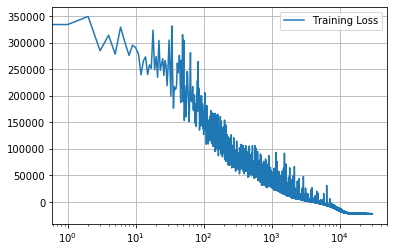

In [30]:
plot_history(history)

In [31]:
test_data = data_sets.test.get_data()

In [32]:
model.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]])

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[array([[-0.9780148 ,  2.6129231 ],
        [-0.7344066 , -3.1080022 ],
        [ 0.21977174, -2.7706327 ],
        ...,
        [ 0.04638398,  1.6535234 ],
        [-0.18999064,  0.40926594],
        [ 0.5700333 ,  0.35532308]], dtype=float32),
 array([[ 7.5349212e-04, -8.8515878e-04],
        [ 8.2261860e-04, -7.1817636e-04],
        [ 8.3510578e-04, -4.4178963e-04],
        ...,
        [ 8.2512200e-04,  6.7323446e-05],
        [ 8.3039701e-04, -9.6723437e-05],
        [ 7.0936978e-04,  1.5251338e-04]], dtype=float32),
 array([[ 0.04647661,  0.07510889],
        [ 0.02925644,  0.03267482],
        [-0.04551278,  0.07064885],
        ...,
        [ 0.01574843,  0.00991216],
        [ 0.03906616,  0.05086914],
        [ 0.04725501,  0.07717098]], dtype=float32)]

In [33]:
t = model.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]])

In [34]:
test_data

{'inputs': array([[-5.78139499e-02, -1.77073292e-02,  5.24139396e-05, ...,
         -3.53392363e-01, -7.82606661e-01, -2.70707011e-02],
        [ 1.27914809e-02, -9.28117335e-02,  1.73986815e-02, ...,
          6.60053253e-01, -1.31689265e-01, -2.70847142e-01],
        [ 1.19008441e-02,  1.15471974e-01, -7.18189217e-03, ...,
          7.21604824e-01, -5.31669036e-02, -3.81619900e-01],
        ...,
        [ 3.52432253e-03,  7.62999356e-02,  3.52432253e-03, ...,
          5.90382397e-01,  3.15048367e-01,  5.72271645e-01],
        [-6.32991781e-03,  1.89393992e-03, -6.32991781e-03, ...,
          5.57917774e-01,  3.23127329e-01,  7.47278750e-01],
        [ 1.41666196e-02,  3.65008526e-02, -1.81117933e-02, ...,
         -1.11499265e-01, -9.57322940e-02,  4.66616988e-01]], dtype=float32),
 'labels': array([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 'modvel': array([[ 0.09444809, -0.05531563],
        [-0.01159504,  0.